In [2]:
from IPython.display import clear_output
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import time

import seaborn as sns

import itertools
import scipy.stats as stats

from sklearn.ensemble import ExtraTreesRegressor as etr#, RandomForestRegressor as rfr, BaggingRegressor
from sklearn.ensemble import ExtraTreesClassifier as etc#, RandomForestClassifier as rfc, BaggingClassifier
#from sklearn.ensemble import GradientBoostingClassifier as gbc, AdaBoostClassifier as abc

from sklearn.preprocessing import LabelEncoder as le, StandardScaler as ss, MinMaxScaler as mms
from sklearn.metrics import r2_score, confusion_matrix as cm, classification_report as cr, accuracy_score as acc_scr

# All Functions

In [281]:
def sample_model(x, y, n_estimators=1, seed=None, verbose=0, n_jobs=-1, mode='classifier', score=True, cls_score=True, test_size=0.2, random_state=None, label_encode=False, confusion_matrix=True, cls_metric='f1-score', bootstrap=False):
        
    if label_encode: y = pd.DataFrame(le().fit_transform(y), index=y.index)
    
    msk = np.random.rand(len(y))<(1-test_size)
    #if type(seed)!=type(None): msk = seed

    x_train, x_test, y_train, y_test = x[msk], x[~msk], np.array(y)[msk], np.array(y)[~msk]

    #rf = rfr(n_estimators=50)
    #bg = BaggingRegressor(n_estimators=50)

    if mode=='classifier': 
        et = etc(verbose=verbose, n_estimators=n_estimators, n_jobs=n_jobs, bootstrap=bootstrap, random_state=random_state)
    else: 
        et = etr(verbose=verbose, n_estimators=n_estimators, n_jobs=n_jobs, bootstrap=bootstrap, random_state=random_state)
    
    #et.set_params(n_estimators=10)
    et.fit(x_train,y_train)
    y_pred = et.predict(x_test)
    
    if score:
        if mode=='classifier':
            acc = acc_scr(y_test, y_pred)
        else:
            acc = r2_score(y_test, y_pred)        
            
    if confusion_matrix: conf_matrix = cm(y_test, y_pred)
    else: conf_matrix=0

    if cls_score: 
        cls_report = cr(y_test, y_pred, output_dict=True)
        cls_acc = pd.DataFrame(cls_report).T.head(-3)[cls_metric].tolist()
    else: cls_acc=0
        
    output_control = [score, cls_score, confusion_matrix]
    outputs = [output for output in pd.Series([acc, cls_acc, conf_matrix])[output_control]]
    
    return et, outputs


def play_game(model_p1='random', model_p2='random', avg_out=False):
    
    plays_keys = [7,8,9,4,5,6,1,2,3]
    actions_dict = {board_key:game_key for board_key, game_key in zip(plays_keys, range(9))}
    
    clear_output(wait=True)
         
    table = np.array([[0,0,0], [0,0,0], [0,0,0]])
    table_flat = table.ravel().tolist()

    game_memory1, game_memory2 = [], []

    action_history1, action_history2  = [], []
    action1, action2 = -1, -1
    reward1, reward2 = 0, 0
    fatal_move1, fatal_move2 = 0, 0
    end_game = 0
    round_cnt = 0
    done=False
    
    while not done:
        
    #-------- Action 1 ------------
        
        if end_game!=1:

            
            if model_p1=='random':

                action1 = int(np.random.sample()*10)
                while action1 in action_history1+[9]:
                    action1 = int(np.random.sample()*10)
 
            elif model_p1=='human':
                #clear_output(wait=True)
                print(table)
                time.sleep(0.4)
                print('Ok')
                action1 = input('Entre sua Jogada: ')
                action1 = int(action1)
                if action1=='exit': break
                action1 = actions_dict[action1]
                
            else:

                obs_pred = (int(''.join([str(j) for j in action_history1])) if len(action_history1)!=0 else -1)   
                pred_in = [[round_cnt+1, obs_pred, i] for i in range(9)]       

                action1 = np.argmax(model_p1.predict(pred_in))

                choice_cnt=0
                while action1 in action_history1+[9]:
                    action1 = pd.Series(model_p1.predict(pred_in)).sort_values(ascending=False).index[choice_cnt]
                    choice_cnt+=1
    
            action_history1.append(action1)                   
            table_flat[action1]='o'

            table = np.array(table_flat).reshape(3,3)
            for i in range(3):
                if (table[i].tolist()==['o', 'o', 'o']) or (table[:, i].tolist()==['o', 'o', 'o']) or (np.diag(table).tolist()==['o', 'o', 'o']) or ([table[0][2], table[1,1], table[2,0]]==['o', 'o', 'o']):
                    reward1=1
                    fatal_move2=1

        if round_cnt>0:
            if avg_out: game_memory2.append([reward2, fatal_move2])
            else:
                
                obs2 = (int(''.join([str(j) for j in action_history2[:-1]])) if len(action_history2[:-1])!=0 else -1)
                game_memory2.append([round_cnt, obs2, action2, reward2, fatal_move2])
        
        action_history2.append(action1)
                   
        round_cnt+=1
            
        if 0 not in table_flat or reward1==1 or reward2==1: end_game+=1   
        if end_game==2 or reward2==1: break
        
    #----- Action 2 ---------

        if end_game!=1:

            if model_p2=='random':

                action2 = int(np.random.sample()*10)
                while action2 in action_history2+[9]:
                    action2 = int(np.random.sample()*10)
            
            elif model_p2=='human':
                #clear_output(wait=True)
                print(table)
                action2 = input('Entre Sua Jogada: ')
                action2 = int(action2)
                if action2=='exit': break
                action2 = actions_dict[action2]
                                            
            else:
                
                obs_pred = (int(''.join([str(j) for j in action_history2])) if len(action_history2)!=0 else -1)   
                pred_in = [[round_cnt, obs_pred, i] for i in range(9)]       

                action2 = np.argmax(model_p2.predict(pred_in))

                choice_cnt=0
                while action2 in action_history2+[9]:
                    action2 = pd.Series(model_p2.predict(pred_in)).sort_values(ascending=False).index[choice_cnt]
                    choice_cnt+=1
               
            action_history2.append(action2)       
            table_flat[action2] = 'x' 

            #----

            table = np.array(table_flat).reshape(3,3)
            for i in range(3):
                if (table[i].tolist()==['x', 'x', 'x']) or (table[:, i].tolist()==['x', 'x', 'x']) or (np.diag(table).tolist()==['x','x','x']) or ([table[0][2], table[1,1], table[2,0]]==['x', 'x', 'x']):
                    winner = 'x'
                    reward2 = 1
                    fatal_move1 = 1
        
        if avg_out: game_memory1.append([reward1, fatal_move1])
        else:
            
            obs1 = (int(''.join([str(j) for j in action_history1[:-1]])) if len(action_history1[:-1])!=0 else -1)
            game_memory1.append([round_cnt, obs1, action1, reward1, fatal_move1])            
        
        action_history1.append(action2)
        
        if 0 not in table_flat or reward1==2 or reward2==1: end_game+=1
        if end_game==2 or reward1==1: break

#------------ Total and Decay Rewards and Fatal Moves -------------------------
            
    if not avg_out:

        for i, row in enumerate(game_memory1):

            game_memory1[i].append(reward1)
            game_memory1[i].append(reward1*(i+1)/(len(game_memory1)))
            game_memory1[i].append(reward2)
            game_memory1[i].append(reward2*(i+1)/(len(game_memory1)))

        for i, row in enumerate(game_memory2):

            game_memory2[i].append(reward2)
            game_memory2[i].append(reward2*(i+1)/(len(game_memory2)))
            game_memory2[i].append(reward1)
            game_memory2[i].append(reward1*(i+1)/(len(game_memory2)))
        
        game_df1 = pd.DataFrame(game_memory1, columns=['round', 'obs', 'action', 'reward', 'fatal_move', 'reward_ttl', 'reward_decay', 'fatal_move_ttl', 'fatal_move_decay'])
        game_df2 = pd.DataFrame(game_memory2, columns=['round', 'obs', 'action', 'reward', 'fatal_move', 'reward_ttl', 'reward_decay', 'fatal_move_ttl', 'fatal_move_decay'])
    
    else: 
        game_df1 = pd.DataFrame(game_memory1, columns=['reward', 'fatal_move'])
        game_df2 = pd.DataFrame(game_memory2, columns=['reward', 'fatal_move'])
    
    return game_df1, game_df2

def play_n_games(n_games=100, n_games_start=1, model_p1='random', model_p2='random', avg_out=False, retraining=None, report=True, return_df1=True, return_df2=True, alfa=0.05, e_min=0.02):
    
    return_control=np.array([return_df1, return_df2])
    
    if type(retraining)!=type(None): 
        try: n_games_start = retraining[0].game.max() + 1
        except: n_games_start = retraining[1].game.max() + 1
    z_a2 = stats.norm.ppf(alfa/2)
    
    memory_p1 = []
    memory_p2 = []    
    for game in range(n_games_start, n_games_start + n_games):
        if report:
            clear_output(wait=True)
            print('n_games in training sets: {}/{}'.format(game, n_games_start + n_games-1))      
        
        df1, df2 = play_game(model_p1=model_p1, model_p2=model_p2, avg_out=avg_out)        
                
        dfs_lst = pd.Series([df1, df2])[return_control]
                    
#-------------------------------------------------------------------------------------------------

        for df in dfs_lst:             

            reward = df.reward.tolist()[-1]
            fatal_move = df.fatal_move.tolist()[-1]
            tight = reward==0 and fatal_move==0
            
            df_len = len(df)
            if tight:
                df['tight'] = np.zeros(df_len-1).tolist() + [1]               
                if not avg_out:
                    df['tight_ttl'] = np.ones(df_len)
                    df['tight_decay'] = np.linspace(0, 1, df_len)            
            else: 
                df['tight'] = np.zeros(df_len)
                if not avg_out:
                    df['tight_ttl'] = np.zeros(df_len)
                    df['tight_decay'] = np.zeros(df_len)

#--------------------------------------------------------------------------------------
                    
            if not avg_out:
                df['game'] = game
                df_cols = df.drop('game', axis=1).columns.tolist()            
                df = df[['game'] + df_cols]

#---------------------------------------------------------------
        if avg_out:
            if return_df1:
                memory_p1.append(df1.sum().tolist())
            if return_df2:
                memory_p2.append(df2.sum().tolist())
        else:   
            if return_df1:
                memory_p1.append(df1)
            if return_df2:
                memory_p2.append(df2)
#--------------------------------------------------------------

    #time.sleep(1)
    if avg_out:
        if return_df1:
            print('Converting First Dataframe...')
            #time.sleep(1)
            
            df1 = pd.DataFrame(memory_p1, columns=['reward', 'fatal_move', 'tight'])

            p_i = df1.mean().tolist()
            
            s_i = [(p*(1-p)/n_games)**(1/2) for p in p_i]
            e_i = [z_a2 * si for si in s_i]
            n_i = [((z_a2/e_min)**2) * p * (1-p) for p in p_i]
            
            df1 = p_i + s_i + e_i + n_i
                        
        if return_df2:
            print('Converting Second Dataframe...')
            #time.sleep(1)

            df2 = pd.DataFrame(memory_p2, columns=['reward', 'fatal_move', 'tight'])
            p_i = df2.mean().tolist()

            s_i = [(p*(1-p)/n_games)**(1/2) for p in p_i]
            e_i = [z_a2 * si for si in s_i]
            n_i = [((z_a2/e_min)**2) * p * (1-p) for p in p_i]
            
            df2 = p_i + s_i + e_i + n_i            
        
    else:
        if return_df1:
            print('Converting First Dataframe...')
            #time.sleep(1)
            df1 = pd.concat(memory_p1, axis=0).reset_index(drop=True)
        if return_df2:
            print('Converting Second Dataframe...')
            #time.sleep(1)
            df2 = pd.concat(memory_p2, axis=0).reset_index(drop=True)

        if type(retraining)!=type(None): 
            if return_df1:
                print('Concatenating Retraining DataFrame...')
                #time.sleep(1)
                df1 = pd.concat([retraining[0], df1], axis=0).reset_index(drop=True)
            if return_df2:
                print('Concatenating Retraining DataFrame...')
                #time.sleep(1)
                df2 = pd.concat([retraining[1], df2], axis=0).reset_index(drop=True)
    
    dfs = np.array([df1, df2])[return_control] 
    return [df for df in dfs]

def n_games_progression(n_games_df, bins=25, alfa=0.05, e_min=0.02):

    prog = []
    z_a2 = stats.norm.ppf(alfa/2)
    p_cols = ['reward', 'fatal_move', 'tight']
    cols = ['game', 'reward', 'fatal_move', 'tight', 'obs', 'action']
    
    n_games_grp = n_games_df.groupby('game').sum()
    n_games = len(n_games_grp)
    avgs = n_games_grp.mean()[p_cols].tolist()
    stds = [(p*(1-p)/n_games)**(1/2) for p in avgs]
    n_games_grp.std()[p_cols].tolist()

    interval = int(n_games/bins)   
    for game in range(interval, n_games+1, interval):
        
        clear_output(wait=True)
        print('Game: {}/{}'.format(game, n_games))
        
        n_df = n_games_df[n_games_df.game<=game][cols]
        
        unique_rounds = len(n_df['obs'].unique())
        unique_moves = len(n_df.drop_duplicates(subset=['obs', 'action']))
        rounds = len(n_df)
        n = game
        prog_row = [n]
        n_df_grp = n_df.groupby('game').sum()
        for i, col in enumerate(p_cols):

            p = n_df_grp[col].mean()
            q = 1-p
            p_dif = p - avgs[i]
            s = (p*(1-p)/n)**(1/2)
            s_dif = s - stds[i]
            e = s*z_a2
            n_min =  (p*q*z_a2**2)/(e_min**2)
            prog_row.extend([p, p_dif, s, s_dif, e, n_min])
            
        prog.append(prog_row + [rounds, unique_rounds, unique_moves])
        
#--------------------------
                          
    prog = pd.DataFrame(prog, columns=['game']+ [col+' - '+stat for col in p_cols for stat in ['p', 'p_dif', 's', 's_dif', 'e', 'n_min']] + ['rounds', 'unique_rounds', 'unique_moves'])
    
    return prog

def play_n_times(n_times=10, n_games=100, model_p1='random', model_p2='random', avg_out=True, reuse_dfs=False, old_dfs=None, avg_twice=False, report=True, n_games_report=False):
    
    dfs_p1, dfs_p2 = [], []
    n_games_start = 0
    for time in range(n_times):
        df1, df2 = play_n_games(n_games=n_games, n_games_start=n_games_start+1, model_p1=model_p1, model_p2=model_p2, avg_out=avg_out, report=n_games_report)
        
        dfs_p1.append(df1)
        dfs_p2.append(df2)
        n_games_start+=n_games
        print(time+1, '/', n_times+1)
        
    new_dfs = [0,0]
    for i, dfs in enumerate([dfs_p1, dfs_p2]):

        if avg_out:
            new_dfs[i] = pd.DataFrame(dfs, columns=['reward_avg', 'fatal_move_avg', 'tight_avg', 'reward_std', 'fatal_move_std', 'tight_std'])
            if avg_twice: new_dfs[i] = new_dfs[i].mean()
        else:
            new_dfs[i] = pd.concat(dfs, axis=0).reset_index(drop=True)
         
    df1 = new_dfs[0]
    df2 = new_dfs[1]
    
    if reuse_dfs:
        df1 = pd.concat(old_dfs[0], df1)
        df2 = pd.concat(old_dfs[1], df2)
    
    return df1, df2

def n_times_progression(n_times_df, alfa=0.05, e_min=0.01):
    
    p_cols = ['reward_avg', 'fatal_move_avg', 'tight_avg']
    stats_cols = ['p', 'p_dif', 's', 's_dif', 'e', 'n_min']
    avgs = n_times_df[p_cols].mean().tolist()
    stds = n_times_df[p_cols].std().tolist()
    n_times = len(n_times_df)
    rows = []
    for n in range(3, n_times):
        
        n_df = n_times_df.iloc[:n]

        row = [n]
        for i, col in enumerate(p_cols):
            
            t_a2 = stats.t.ppf(alfa/2, n-1)
            p = n_df[col].mean()
            p_dif = p - avgs[i]
            s = n_df[col].std()
            s_dif = s - stds[i]
            e = t_a2*s/(n**(1/2))
            n_min = (t_a2*s/e_min)**2

            row.extend([p, p_dif, s, s_dif, e, n_min])
        rows.append(row)
        clear_output(wait=True)
        print(n, '/', n_times)
        
    df = pd.DataFrame(rows, columns=['n'] + [col[:-4]+' - '+stat for col in p_cols for stat in stats_cols])
    return df


def system_progression(x, y, n_games_df, n_times=5, prog_func='uniform', prog_degree=2, retraining=None, player='p2', bins=8, alfa=0.05, e_min=0.02, seed=None, verbose=0, n_jobs=-1, mode='classifier', score=True, cls_score=True, cls_metric='f1-score', test_size=0.2, label_encode=False, confusion_matrix=False, n_games=500, n_games_start=1, avg_out=True, report=False, bootstrap=False):
    
    model_p1, model_p2 ='random', 'random'
    
    stats_names = ['p', 's', 'e', 'n_min']
    p_names = ['reward', 'fatal_move', 'tight']
    stats_cols = ['n'] + [col+' - '+stat for col in p_names for stat in stats_names]
    acc_cols = ['class {}'.format(clss) for clss in range(len(y.unique()))]
    rounds_cols = ['rounds', 'unique rounds', 'unique_moves']
    
    z_a2 = stats.norm.ppf(alfa/2)
    df_grp = n_games_df.groupby('game').sum()
    last_game = len(df_grp)
    games_col = n_games_df.game
    interval = int(last_game/bins)
    
    games_list = range(interval, last_game+1, interval)
    if prog_func=='polynomial': games_list = [int(i*j**prog_degree-1) for i,j in zip(games_list, np.linspace(1/bins, 1, bins))]
    
    rows = []
    for bin_, game in enumerate(games_list):
        print('Scoring Model Trained on {}% of the Dataset Playing {} Games... ({}/{})'.format(round(game*100/last_game, 2), n_games, bin_+1, bins))
        msk = games_col<=game
        
        new_x = x[msk]
        new_y = y[msk]
        n_df = n_games_df[['obs', 'action']][msk]
      
        rounds = len(n_df)        
        unique_rounds = len(n_df['obs'].unique())
        unique_moves = len(n_df.drop_duplicates(subset=['obs', 'action']))
        rounds_info = [rounds, unique_rounds, unique_moves]
        
        if cls_score: y_model, [acc, cls_acc] = sample_model(new_x, new_y, seed=seed, verbose=verbose, n_jobs=n_jobs, mode=mode, score=score, cls_score=cls_score, cls_metric=cls_metric, test_size=test_size, label_encode=label_encode, confusion_matrix=confusion_matrix, bootstrap=bootstrap)
        else:
            y_model, acc = sample_model(new_x, new_y, seed=seed, verbose=verbose, n_jobs=n_jobs, mode=mode, score=score, cls_score=cls_score, cls_metric=cls_metric, test_size=test_size, label_encode=label_encode, confusion_matrix=confusion_matrix, bootstrap=bootstrap)
            acc = acc[0]
        if player=='p2': model_p2 = y_model
        else: model_p1 = y_model
        
 
        for n_time in range(n_times):
            df1, df2 = play_n_games(n_games=n_games, n_games_start=n_games_start, model_p1=model_p1, model_p2=model_p2, avg_out=avg_out, retraining=None, report=report)

            if player=='p2': df = df2
            else: df = df1


            stats_row = [game]
            for i in range(3):

                p = df[i]        
                q = 1-p
                s = (p*q/n_games)**(1/2)
                e = z_a2*s
                n_min = p*q*(z_a2/e_min)**2
                stats_row.extend([p, s, e, n_min])


            rows.append(stats_row + [acc] + (cls_acc if cls_score else []) + rounds_info)

            print('Progression Advancement: ({}/{})  n_times: ({}/{})'.format(bin_+1, bins, n_time+1, n_times))
            clear_output(wait=True)
    df = pd.DataFrame(rows, columns=stats_cols + ['acc'] + (acc_cols if cls_score else []) + rounds_cols)
    
    if type(retraining!=type(None)):
        df = pd.concat([retraining, df], axis=0).sort_values('n').reset_index(drop=True)
        
    return df
    


def n_system_progression(x, y, df, n_progs=3, player='p2', prog_func='uniform', prog_degree=2,
                              bins=7, n_games=300, e_min=0.025, alfa=0.05, retraining=None,
                              mode='classifier', bootstrap=True, cls_score=True):    

    for prog in range(n_progs):
        top_prog = system_progression(x, y, df, player=player, prog_func=prog_func, prog_degree=prog_degree,
                              bins=bins, n_games=n_games, e_min=e_min, alfa=alfa, retraining=(top_prog if prog!=0 else retraining),
                              mode=mode, bootstrap=True, cls_score=cls_score)
    return top_prog.reset_index(drop=True)

def compare_classifiers(system_name, df2, n_games=250, return_models=True, return_xy=False, a_i = [1, 1, 1, -1, -1, -1, -1, -1, -1]):

    system_rewards = system_name.split(' + ')
    rewards_names = ['reward',
     'reward_ttl',
     'reward_decay',
     'fatal_move',
     'fatal_move_ttl',
     'fatal_move_decay',
     'tight', 'tight_ttl',
     'tight_decay']

    a_i = [a for a, reward in zip(a_i, rewards_names) if reward in system_rewards]

    x_2 = df2[['round', 'obs', 'action']].copy()
    yi_2 = [df2[name]*a for name, a in zip(system_rewards, a_i)]

    y_top = pd.Series(le().fit_transform(sum(yi_2)), index=df2.index, name=system_name)
    y_top_cont = sum(yi_2)
    y_top_cont.name=system_name
    
    if return_xy: return x_2, (y_top, y_top_cont)

    #---------------------------- Modeling ----------------------------------

    print('Building Model 1 ...')
    top_model, (acc, cls_acc) = sample_model(x_2, y_top, mode='classifier', confusion_matrix=False, cls_score=True)
    print('Building Model 2 ...')
    top_model_reg, (acc_reg) = sample_model(x_2, y_top, mode='regressor', confusion_matrix=False, cls_score=False)
    print('Building Model 3 ...')
    top_model_reg_cont, (acc_reg_cont) = sample_model(x_2, y_top_cont, mode='regressor', confusion_matrix=False, cls_score=False)

    print('Accuracy - Classifier Using Enlabeled Rewards: ', round(acc,3))
    print('Accuracy - Regressor Using Enlabeled Rewards: ', round(acc_reg[0],3))
    print('Accuracy - Regressor Using Continuous Rewards: ', round(acc_reg_cont[0],3))
    time.sleep(5)
    top_df2 = play_n_games(n_games=n_games, model_p2=top_model, return_df1=False, retraining=None)[0]
    top_df2_reg = play_n_games(n_games=n_games, model_p2=top_model_reg, return_df1=False, retraining=None)[0]
    top_df2_reg_cont = play_n_games(n_games=n_games, model_p2=top_model_reg_cont, return_df1=False, retraining=None)[0]
    
    if return_models: return (top_df2, top_df2_reg, top_df2_reg_cont), (top_model, top_model_reg, top_model_reg_cont)
    else: return top_df2, top_df2_reg, top_df2_reg_cont

def score_system(x, y, n_games, n_times=5, player='p2', mode='classifier', test_size=0.2, bootstrap=False, seed=None, e_min=0.2, alfa=0.05, avg_out=False, retraining=None, cls_score=True):
    n_classes = len(y.unique())
    print('Building Model {} ...'.format(y.name))
    model, (model_outputs) = sample_model(x, y, mode=mode, seed=seed,
                                         score=True, cls_score=cls_score, cls_metric='f1-score',
                                         test_size=test_size, confusion_matrix=False, bootstrap=bootstrap)
    
    acc = model_outputs[0]
    if mode=='classifier': cls_acc=model_outputs[1]
    
    
    model_p1, model_p2 = 'random', 'random'
    if player=='p1': model_p1 = model
    else: model_p2 = model

    rows = []
    for time in range(n_times):
        print('Playing {} games: ({}/{})'.format(n_games, time+1, n_times))
    
        n_games_avg_std = play_n_games(n_games=n_games,
                                   model_p1=model_p1, model_p2=model_p2,
                                   e_min=e_min, alfa=alfa,
                                   avg_out=True, report=False,
                                   return_df1=(True if player=='p1' else False),
                                   return_df2=(True if player=='p2' else False))[0]

        rows.append([y.name, n_classes, n_games] + n_games_avg_std + [acc] + (cls_acc if mode=='classifier' else []))
        
    cls_cols = ['class - {}'.format(cls_int) for cls_int in sorted(y.unique())]
    cols = ['name', 'n_classes', 'n_games',
            'reward - p', 'fatal_move - p', 'tight - p',
            'reward - s', 'fatal_move - s', 'tight - s', 
            'reward - e', 'fatal_move - e', 'tight - e',
            'reward - n_min', 'fatal_move - n_min', 'tight - n_min',
            'acc'] + (cls_cols if mode=='classifier' else [])
    
    Model_Series = pd.DataFrame(rows, columns=cols)   # Calling pandas.DataFrame method on loop list 'rows'.
    
    if avg_out: Model_Series = Model_Series.mean().to_frame().T
    if type(retraining)!=type(None): Model_Series = pd.concat([retraining, Model_Series], axis=0).reset_index(drop=True)
    
    return Model_Series
    

def system_progression(top_sys_reg, alfa=0.05, e_min=0.025, test_normality=False):

    n_samples = len(top_sys_reg)
    s_avg_true = top_sys_reg.mean()['reward - s']

    rows=[]
    for n in range(3, n_samples+1):

        n_df = top_sys_reg.iloc[:n]

        p_i = n_df['reward - p']
        p_min = p_i.min()
        p_max = p_i.max()
        A = p_min - p_max

        u = p_i.mean()
        s = (sum([(pi - u)**2 for pi in p_i]) / (n-1))**0.5
        s_avg = n_df.mean()['reward - s']

        t_a2 = stats.t.ppf(alfa/2, df=n-1)
        e = t_a2 * s / (n**0.5)
        e_pred = t_a2 * s / ((1+1/n)**0.5)    
        n_min = (t_a2 * s_avg / e_min)**2
        n_min_est = (t_a2 * s / e_min)**2
        n_min_true = (t_a2 * s_avg_true / e_min)**2

        if test_normality: normal_test, p_normal = stats.normaltest(p_i)

        rows.append([n, u, s, s_avg, e, e_pred, n_min, n_min_est, n_min_true]+([p_normal] if test_normality else []))

    prog_df = pd.DataFrame(rows, columns=['n', 'u', 's', 's_binomial', 'e', 'e_pred', 'n_min', 'n_min_est', 'n_min_true']+(['p_normal'] if test_normality else []))
    
    return prog_df

def build_reward_systems(n_games_df, min_rewards=2, max_rewards=None, label_encode=False, a_i = [1, 1, 1, -1, -1, -1, -1, -1, -1]):

    if max_rewards==None: max_rewards = min_rewards+1
    else: max_rewards+=1

    rewards_names = ['reward', 'reward_ttl', 'reward_decay',
                     'fatal_move', 'fatal_move_ttl', 'fatal_move_decay',
                     'tight', 'tight_ttl', 'tight_decay']

    yi = [n_games_df[name]*a for name, a in zip(rewards_names, a_i)]
    x = n_games_df[['round', 'obs', 'action']]

    combs = []
    for comb_size in range(min_rewards, max_rewards):
        combs += list(itertools.combinations(range(9), comb_size))

    y_comb = []
    combs_names = []
    n_combs = len(combs)
    for i, comb in enumerate(combs):

        clear_output(wait=True)
        print('Calculating Reward Variables: ')
        print('{}/{}'.format(i+1, n_combs))
        time.sleep(0.1)
        for j, comb_index in enumerate(comb):
            if j==0: 
                sys_series = yi[comb_index]    
            else: 
                sys_series += yi[comb_index]    

        sys_name = ' + '.join([rewards_names[k] for k in comb])
        sys_series.name = sys_name    
        
        y_comb.append(sys_series.copy())
        combs_names.append(sys_name)
    
    if label_encode: 

        print('Label Encoding Reward Variables: ')
        y_comb_le = []
        cnt=0
        n_models = len(combs_names)
        for y, name in zip(y_comb, combs_names):
            
            print('Label Encoding Reward Variables: ')
            print(cnt, '/', n_models)
            clear_output(wait=True)
            
            cnt+=1        
            y_enc = le().fit_transform(y)
            y_enc_series = pd.Series(y_enc, index=y.index, name=name)
            y_comb_le.append(y_enc_series)
    
    if label_encode: return x, y_comb_le, combs_names
    else: return x, y_comb, combs_names

def score_n_systems(x, yi, n_games=150, n_times=5, player='p2', mode='classifier', test_size=0.2, bootstrap=False, seed=None, avg_out=False, retraining=None, cls_score=False, e_min=0.2, alfa=0.05):
    
    for n_model, y in enumerate(yi):
        print(n_model+1, '/', len(yi))    
        sys_scrs = score_system(x, y, n_games=n_games, n_times=n_times, player=player, mode=mode, test_size=test_size, bootstrap=bootstrap, seed=seed, e_min=e_min, alfa=alfa, avg_out=avg_out, retraining=(sys_scrs if n_model!=0 else retraining), cls_score=cls_score)

    return sys_scrs
        

### Columns

In [3]:
p_cols = ['reward', 'fatal_move', 'tight']
(reward_cols, fatal_move_cols, tight_cols) = ([col+' - '+stat for col in p_cols[:i] for stat in ['p', 'p_dif', 's', 's_dif', 'e', 'n_min']] for i in [1,2,3])
stats_cols = {['p', 'p_dif', 's', 's_dif', 'e', 'n_min'][i]:[col+' - '+stat for col in p_cols for stat in [['p', 'p_dif', 's', 's_dif', 'e', 'n_min'][i]]] for i in range(6)}

# Data Collection

# Data Collection: 3000000 Games

In [301]:
df2 = pd.read_csv('random_games_p2_fixed.csv')#.iloc[:int(4e6)]

In [ ]:
df2 = play_n_games(n_games=500000, return_df1=False, retraining=[0, df2])[0]

In [8]:
#df2.to_csv('random_games_p2_fixed.csv', index=False)
print('3.5e6 df2 saved. (23/02 - 04:47)')

3.5e6 df2 saved. (23/02 - 04:47)


In [220]:
#df1 = pd.concat([retraining[0], df1_new], axis=0).reset_index(drop=True)

#df2 = pd.concat([retraining[1], df2_new], axis=0).reset_index(drop=True)

In [222]:
#df1.to_csv('random_games_p1_1000000.csv', index=False)

#df2.to_csv('random_games_p2_3000000.csv', index=False)

print(len(df1.game.unique()), len(df2.game.unique()))

In [1528]:
df2.groupby('game').sum()[['reward', 'fatal_move', 'tight']].mean()

reward        0.287564
fatal_move    0.585355
tight         0.127080
dtype: float64

### Sorting Training n_games Dataset, unique moves games first

In [302]:
uni_moves_games = df2.drop_duplicates(subset=['obs', 'action'])['game'].unique()

uni_moves_df2 = df2[df2['game'].isin(uni_moves_games)]
repeated_moves_df2 = df2.drop(uni_moves_df2.index)

df2=0

df2_uni = pd.concat([uni_moves_df2, repeated_moves_df2], 0)
df2_uni.reset_index(drop=True, inplace=True)

uni_games = df2_uni['game'].unique()
sorted_uni_games = sorted(uni_games)

uni_games_dict = {game:sorted_game for game, sorted_game in zip(uni_games, sorted_uni_games)}

df2_uni_games = df2_uni['game'].tolist()
df2_uni_games_sorted = [uni_games_dict[game] for game in df2_uni_games]

df2_uni['game'] = df2_uni_games_sorted

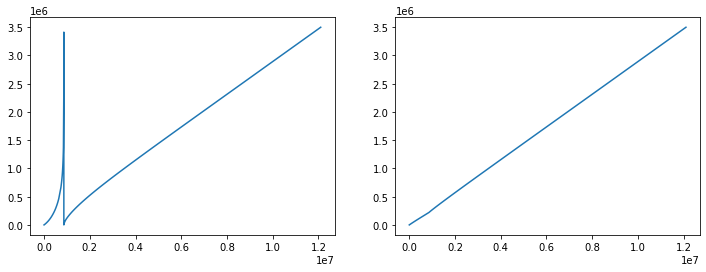

In [22]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(df2_uni_games)
axs[1].plot(df2_uni.game)

plt.show()

# n Games Progresssion

## Evaluating Randon, and Model Playing Game Progresion

In [121]:
top_df2 = play_n_games(n_games=5000, model_p2=sample_model(x, y_comb_top[0], mode='regressor', cls_score=False, confusion_matrix=False)[0], return_df1=False, avg_out=False)[0]

Converting Second Dataframe...


#### Calling Function

In [28]:
prog = n_games_progression(df2_uni, bins=100)

Game: 3500000/3500000


In [128]:
prog = n_games_progression(top_df2, bins=500)

Game: 5000/5000


In [129]:
prog_copy = prog.copy().set_index('game')

In [130]:
p_cols = ['reward', 'fatal_move', 'tight']
(reward_cols, fatal_move_cols, tight_cols) = ([col+' - '+stat for col in p_cols[:i] for stat in ['p', 'p_dif', 's', 's_dif', 'e', 'n_min']] for i in [1,2,3])
stats_cols = {['p', 'p_dif', 's', 's_dif', 'e', 'n_min'][i]:[col+' - '+stat for col in p_cols for stat in [['p', 'p_dif', 's', 's_dif', 'e', 'n_min'][i]]] for i in range(6)}

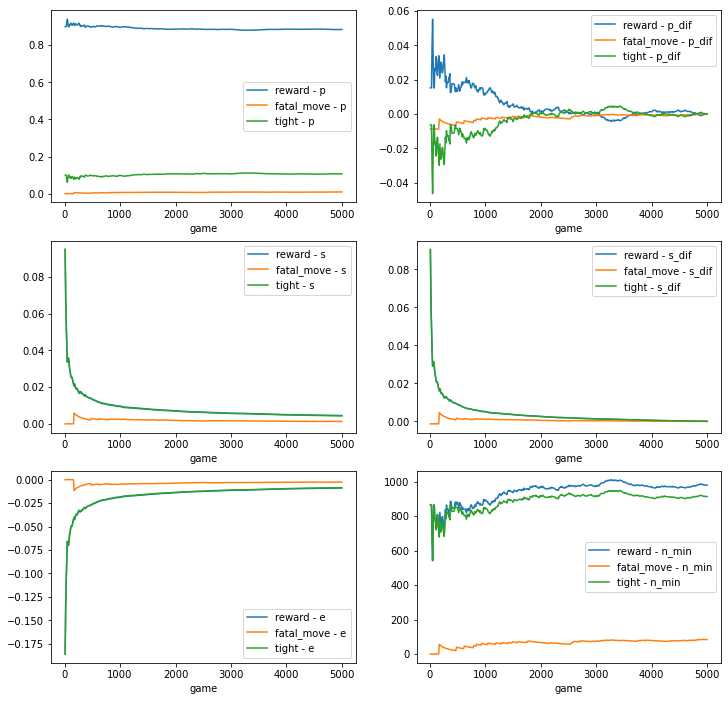

In [136]:
colors = ['blue', 'orange', 'green']
fig, axs = plt.subplots(3,2, figsize=(12,12))

cols = [['p', 'p_dif'], ['s', 's_dif'], ['e', 'n_min']]

for i in range(3):

    prog_copy[stats_cols[cols[i][0]]].plot(ax=axs[i][0])
    prog_copy[stats_cols[cols[i][1]]].plot(ax=axs[i][1])

    ax0.grid()
    ax1.grid()
#for i, y in enumerate(yi.mean()):

#   ax0.plot(x, [y for j in range(len(x))], color=colors[i], linewidth=2)

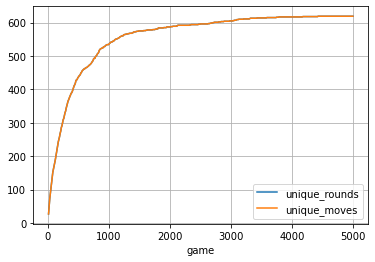

In [137]:
fig, axs = plt.subplots(1,1,figsize=(6,4))

prog_copy.iloc[:, -2:].plot(ax=axs)

axs.grid()
plt.show()


# Classifier vs Regressor Trees Comparison

In [154]:
(top_df2, top_df2_reg, top_df2_reg_cont), (model_label, model_reg, model_reg_cont) = compare_classifiers(top_sys[0], df2_uni, n_games=1500, return_models=True)

Converting Second Dataframe...


In [152]:
df2_uni[['round', 'obs', 'action']]

round      obs  action
0             1        0       7
1             2       71       5
2             3     7154       8
3             4   715486       3
4             1        5       4
...         ...      ...     ...
12099117      3     7164       8
12099118      1        5       6
12099119      2      561       3
12099120      3    56134       7
12099121      4  5613470       8

[12099122 rows x 3 columns]

### Retraining

In [1380]:
n_games = int(input('n_games: '))
top_df2 = play_n_games(n_games=n_games, model_p2=model_label, return_df1=False, retraining=[0,top_df2])[0]
top_df2_reg = play_n_games(n_games=n_games, model_p2=model_reg, return_df1=False, retraining=[0,top_df2_reg])[0]
top_df2_reg_cont = play_n_games(n_games=n_games, model_p2=model_reg_cont, return_df1=False, retraining=[0,top_df2_reg_cont])[0]

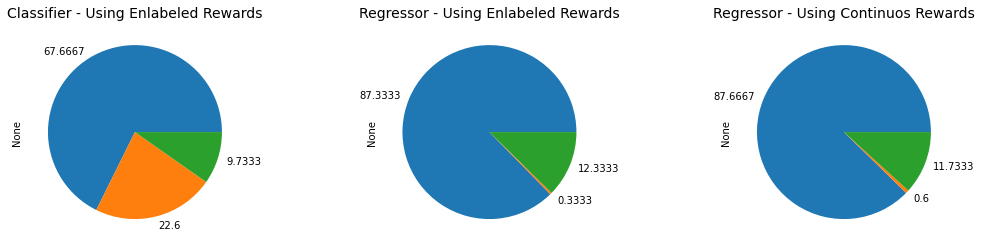

In [155]:
fig, axs = plt.subplots(1,3,figsize=(18,4))

avgs = top_df2.groupby('game').sum().mean()[['reward', 'fatal_move', 'tight']]
avgs.plot.pie(ax=axs[0], labels=(avgs*100).round(4))

avgs = top_df2_reg.groupby('game').sum().mean()[['reward', 'fatal_move', 'tight']]
avgs.plot.pie(ax=axs[1], labels=(avgs*100).round(4))

avgs = top_df2_reg_cont.groupby('game').sum().mean()[['reward', 'fatal_move', 'tight']]
avgs.plot.pie(ax=axs[2], labels=(avgs*100).round(4))

axs[0].set_title('Classifier - Using Enlabeled Rewards')
axs[1].set_title('Regressor - Using Enlabeled Rewards')
axs[2].set_title('Regressor - Using Continuos Rewards')

try: print(y_top.name)
except: pass
plt.show()

# Idea: Model that plays both sides

In [366]:
delta = 16**2 - 4*136/100*(-168)

In [367]:
(16+delta**0.5)/(136/50)

18.457387250842324

In [369]:
(16-delta**0.5)/(136/50)

-6.692681368489382

In [402]:
a = 64/100
b = -16
c = 100-14**2

delta = b**2 - 4*c*a

x1 = (-b + delta**0.5)/(2*a)
x2 = (-b - delta**0.5)/(2*a)

In [403]:
x1, x2

(30.0, -4.999999999999999)

In [382]:
y = np.linspace(-7, 7, 10000)
x = (100 - (100/36) * y**2)**0.5

In [399]:
xc = np.linspace(8-15, 8+15, 10000)
yc = (-(xc-8)**2 + 14**2)**0.5

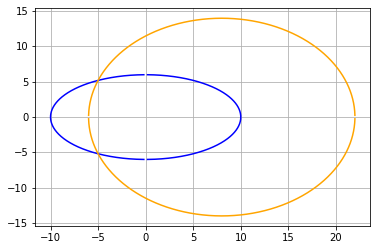

In [401]:
plt.plot(x, y, color='blue')
plt.plot(-x, y, color='blue')

plt.plot(xc, yc, color='orange')
plt.plot(xc, -yc, color='orange')


plt.grid()

In [409]:
(14**2-(30-8)**2)**0.5

(1.0391472674825918e-15+16.97056274847714j)

In [408]:
(36-(36/100)*(30)**2)**0.5

(1.0391472674825918e-15+16.97056274847714j)

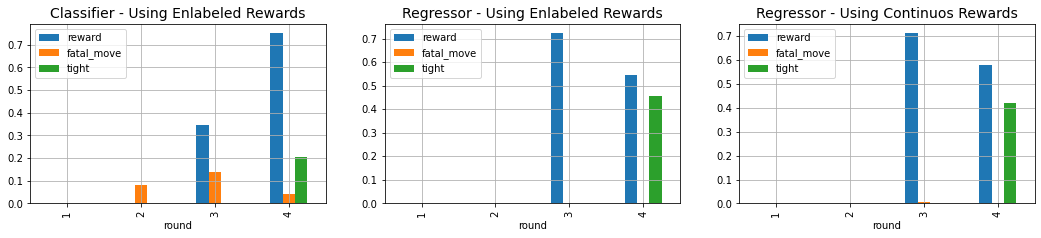

In [156]:
#print(y_top.name)
fig, axs = plt.subplots(1,3,figsize=(18,3.3))

top_df2.groupby('round').mean()[['reward', 'fatal_move', 'tight']].plot.bar(ax=axs[0])
top_df2_reg.groupby('round').mean()[['reward', 'fatal_move', 'tight']].plot.bar(ax=axs[1])
top_df2_reg_cont.groupby('round').mean()[['reward', 'fatal_move', 'tight']].plot.bar(ax=axs[2])

axs[1].set_title('Regressor - Using Enlabeled Rewards')
axs[2].set_title('Regressor - Using Continuos Rewards')
axs[0].set_title('Classifier - Using Enlabeled Rewards')
axs[0].grid()
axs[1].grid()
axs[2].grid()
plt.show()

# Retraining Model

In [164]:
df_retrain = play_n_games(n_games = 3, model_p1='human', model_p2=model_reg)[1]

[[0 0 0]
 [0 0 0]
 [0 0 0]]
Ok


Entre sua Jogada:  3


[['0' '0' '0']
 ['0' 'x' '0']
 ['0' '0' 'o']]
Ok


Entre sua Jogada:  7


[['o' '0' 'x']
 ['0' 'x' '0']
 ['0' '0' 'o']]
Ok


Entre sua Jogada:  1


[['o' '0' 'x']
 ['x' 'x' '0']
 ['o' '0' 'o']]
Ok


Entre sua Jogada:  2


Converting First Dataframe...
Converting Second Dataframe...


In [252]:
x = df2_uni[['round', 'obs', 'action']]
y_clever = sum([df2_uni[p_cols[i]+'_ttl'] * j for i, j in enumerate([1,-1,0])])

In [299]:
seed = np.random.rand(len(y_comb_top[0]))<0.8

In [300]:
baseline_model = sample_model(x, y_comb_top[0], seed=seed, random_state=1, mode='regressor', cls_score=False, confusion_matrix=False)[0]

retraining_model = sample_model(x, y_comb_top[0], seed=seed, random_state=1, mode='regressor', cls_score=False, confusion_matrix=False)[0]

ValueError: Item wrong length 4000000 instead of 12099122.

In [189]:
etc_model = sample_model(x, y_comb_top[0], seed=seed, random_state=1, mode='regressor', cls_score=False, confusion_matrix=False, n_estimators=10, verbose=1)[0]

clever_model = sample_model(x, y_clever, seed=seed, random_state=1, mode='regressor', cls_score=False, confusion_matrix=False)[0]

In [198]:
baseline_df = play_n_games(n_games=1000, model_p2=baseline_model, return_df1=False, e_min=0.025)

retraining_df = play_n_games(n_games=1000, model_p2=retraining_model, return_df1=False, e_min=0.025)

etc_model_df = play_n_games(n_games=1000, model_p2=etc_model, return_df1=False, e_min=0.025)

clever_model_df = play_n_games(n_games=1000, model_p2=clever_model, return_df1=False, e_min=0.025)

In [255]:
models_dfs = [baseline_df, retraining_df, etc_model_df, clever_model_df]

models_dfs_names = ['baseline_df', 'retraining_df', 'etc_model_df', 'clever_model_df']

In [410]:
3-(3**0.5)/2

2.1339745962155616

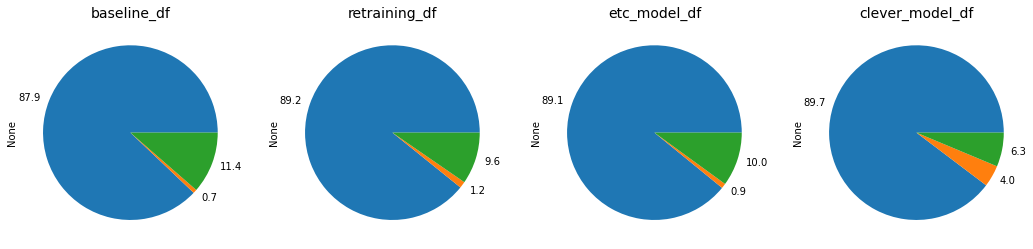

In [256]:
fig, axs = plt.subplots(1,4,figsize=(18,5))

for i, model_df, name in zip(range(len(models_dfs)), models_dfs, models_dfs_names):

    avgs = model_df[0].groupby('game').sum().mean()[p_cols]

    avgs.plot.pie(ax=axs[i], labels=(avgs*100).round(4))
    axs[i].set_title(name)
plt.show()

In [269]:
df_retrain_ext = pd.concat([df_retrain for i in range(200)], axis=0).reset_index()

In [285]:
len(df_retrain_ext)

1800

In [ ]:
baseline_model

In [277]:
play_n_games?

Signature:
play_n_games(
    n_games=100,
    n_games_start=1,
    model_p1='random',
    model_p2='random',
    avg_out=False,
    retraining=None,
    report=True,
    return_df1=True,
    return_df2=True,
    alfa=0.05,
    e_min=0.02,
)
Docstring: <no docstring>
File:      c:\users\luisr\desktop\repository\ibm_courses\personal work\notebooks\machine learning basics\reinforcement learning\<ipython-input-263-820374405de3>
Type:      function


# Applying System Progression

top_prog = system_progression(x_2, y_top_cont, df2, player='p2',
                              bins=10, n_games=, e_min=0.025, alfa=0.05, retraining=None,
                              mode='classifier', bootstrap=True, cls_score=True)

In [42]:
x_2, (y_top, y_top_cont) = compare_classifiers('reward_ttl + fatal_move + fatal_move_ttl + fatal_move_decay + tight + tight_decay + tight_decay', df2_uni, return_xy=True)

In [63]:
top_prog = system_progression(x_2, y_top_cont, df2_uni,
                              n_games=1000, n_times=10,
                              prog_func='polynomial', prog_degree=2, bins=9,
                              mode='regressor', cls_score=False,
                              retraining=top_prog)

Converting First Dataframe...
Converting Second Dataframe...
Progression Advancement: (9/9)  n_times: (10/10)


In [317]:
#top_prog.to_csv(y_top.name+'_system_progression_10bins_1150games.csv')

In [8]:
p_cols = ['reward', 'fatal_move', 'tight']
(reward_cols, fatal_move_cols, tight_cols) = ([col+' - '+stat for col in p_cols[:i] for stat in ['p', 's', 'e', 'n_min']] for i in [1,2,3])
stats_cols = {['p', 's', 'e', 'n_min'][i]:[col+' - '+stat for col in p_cols for stat in [['p',  's', 'e', 'n_min'][i]]] for i in range(4)}

In [61]:
acc_cols = ['acc'] + ['class {}'.format(clss) for clss in range(len(y_top.unique()))]
round_cols = ['rounds', 'unique rounds', 'unique_moves']

NameError: name 'y_top' is not defined

# As The Training Set for the Model Increases in Size

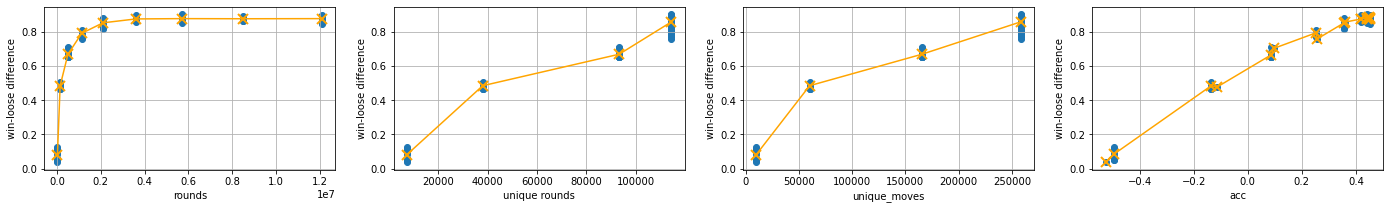

In [129]:
fig, axs = plt.subplots(1,4, figsize=(24,3))

for j, xcol in enumerate(round_cols+['acc']):

    prog_dif = top_prog.groupby(xcol).mean()[stats_cols['p'][0]] - top_prog.groupby(xcol).mean()[stats_cols['p'][1]]

    axs[j].scatter(top_prog[xcol], top_prog[stats_cols['p'][0]]-top_prog[stats_cols['p'][1]])
    axs[j].plot(top_prog.groupby(xcol).mean().index, prog_dif, marker='x', markersize=10, mew=2, mec='orange', color='orange')
    
    axs[j].set(xlabel=xcol, ylabel='win-loose difference')
    axs[j].grid()
    
plt.show()

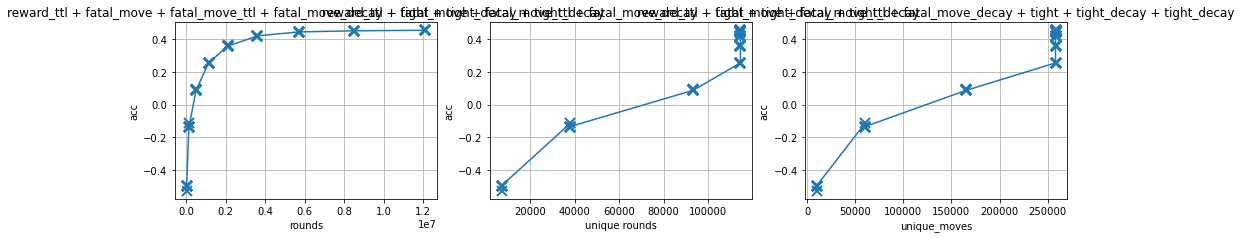

In [128]:
fig, axs = plt.subplots(1,3,figsize=(16,3.25))
ys = top_prog.sort_values('rounds')['acc']

for i in range(3):
    xs = top_prog.sort_values('rounds')[round_cols[i]]
    axs[i].plot(xs, ys, marker='x', ms=10, mew=2)
    axs[i].set(xlabel=round_cols[i], ylabel='acc')
    axs[i].grid()
    axs[i].set(title=y_top.name, ylabel=ys.name, xlabel=round_cols[i])

plt.show()

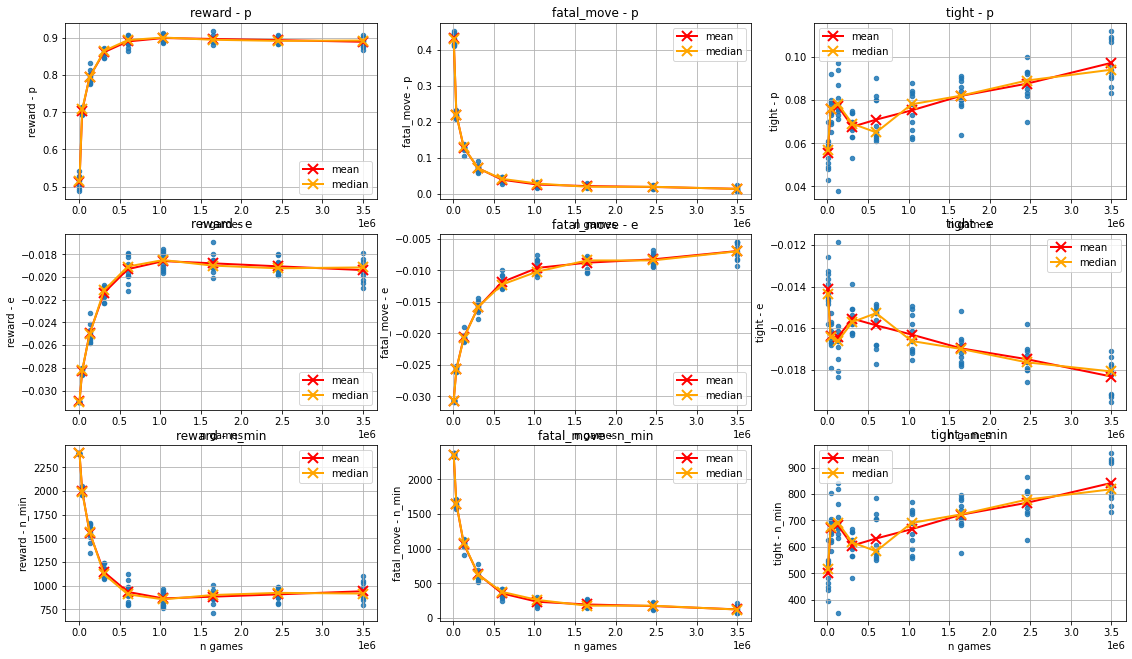

In [92]:
fig, axs = plt.subplots(3,3,figsize=(19,11))

for j, y in enumerate(['p', 'e', 'n_min']):

    for i in range(3):
        xs = 'n'
        ys = stats_cols[y][i]
        axs[j][i].scatter(top_prog[xs], top_prog[ys], alpha=0.85, s=20)
        axs[j][i].plot(top_prog.groupby(xs).mean().index, top_prog.groupby(xs).mean()[ys], marker='x', markersize=10, mew=2, mec='red', color='red', lw=2)
        axs[j][i].plot(top_prog.groupby(xs).median().index, top_prog.groupby(xs).median()[ys], marker='x', markersize=10, mew=2, mec='orange', color='orange', lw=2)
        axs[j][i].set(title=ys, ylabel=ys, xlabel='n games')
        axs[j][i].legend(['mean', 'median'])

        axs[j][i].grid()
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,3))

xs = 'n'
ys = acc_cols[0]


axs[0].plot(top_prog.groupby(xs).mean().index, top_prog.groupby(xs).mean()[ys], marker='o')
axs[0].set(xticks=top_prog.groupby(xs).mean().index)
axs[0].set_title('acc')
for col in acc_cols[1:]:
    axs[1].plot(top_prog.groupby(xs).mean().index, top_prog.groupby(xs).mean()[col], marker='o')

axs[1].set_title('classes accs')
axs[0].grid()
axs[1].grid()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,4))

xs='n'
ys = acc_cols[0]

for col in acc_cols[1:]:
    axs[0].plot(top_prog.groupby(xs).mean().index, ss().fit_transform(top_prog.groupby(xs).mean()[[col]]))
    axs[1].plot(top_prog.groupby(xs).mean().index, top_prog.groupby(xs).mean()[[col]])

axs[0].set(title='classes accs', xlabel=xs, ylabel='normalized '+ys)
axs[1].set(title='classes accs', xlabel=xs, ylabel=ys)
axs[0].grid()
axs[1].grid()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,4))

xs='unique_moves'
ys = acc_cols[0]

for col in acc_cols[1:]:
    axs[0].plot(top_prog.groupby(xs).mean().index, ss().fit_transform(top_prog.groupby(xs).mean()[[col]]))
    axs[1].plot(top_prog.groupby(xs).mean().index, top_prog.groupby(xs).mean()[[col]])

axs[0].set(title='classes accs', xlabel=xs, ylabel='normalized '+ys)
axs[1].set(title='classes accs', xlabel=xs, ylabel=ys)

axs[0].grid()
axs[1].grid()                

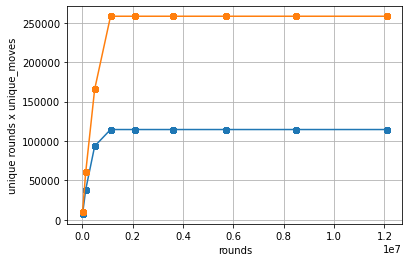

In [86]:
plt.plot(top_prog.sort_values('rounds')['rounds'], top_prog.sort_values('rounds')[round_cols[1]], marker='o')
plt.plot(top_prog.sort_values('rounds')['rounds'], top_prog.sort_values('rounds')[round_cols[2]], marker='o')

plt.ylabel(round_cols[1]+' x '+round_cols[2])
plt.xlabel('rounds')
plt.grid()
plt.show()

# Variables Crossed Out

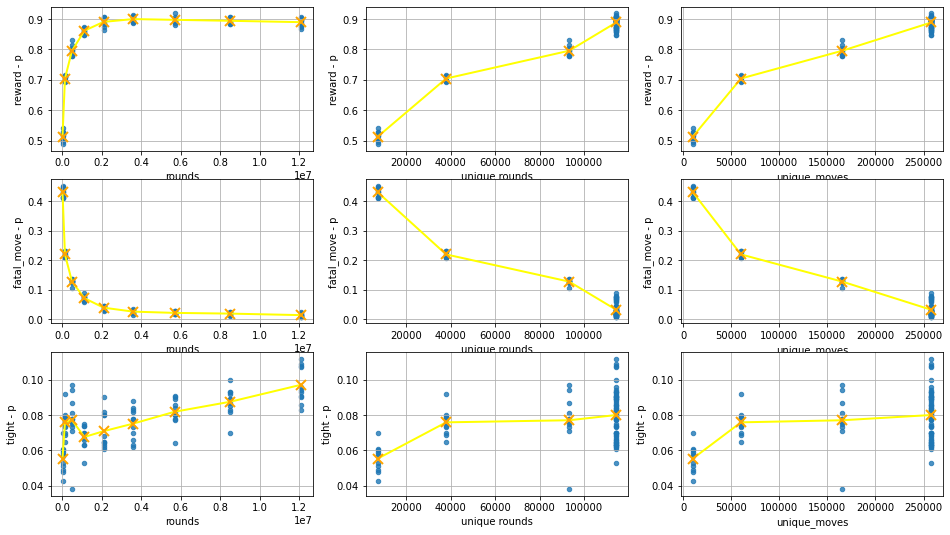

In [124]:
fig, axs = plt.subplots(3,3,figsize=(16,9))
col='p'

for j in range(3):

    for i in range(3):

        xs = top_prog.groupby(round_cols[j]).mean().index
        ys = top_prog.groupby(round_cols[j]).mean()[stats_cols[col][i]] 
        top_prog.plot.scatter(round_cols[j], stats_cols[col][i], ax=axs[i][j], alpha=0.8)

        axs[i][j].plot(xs, ys, marker='x', mec='orange', mew=2, ms=10, lw=2, color='yellow')
        axs[i][j].set(xlabel=round_cols[j], ylabel=stats_cols[col][i])
        axs[i][j].grid()
    #    axs[i].set_xlim(2.578e5, 2.584e5)

plt.show()

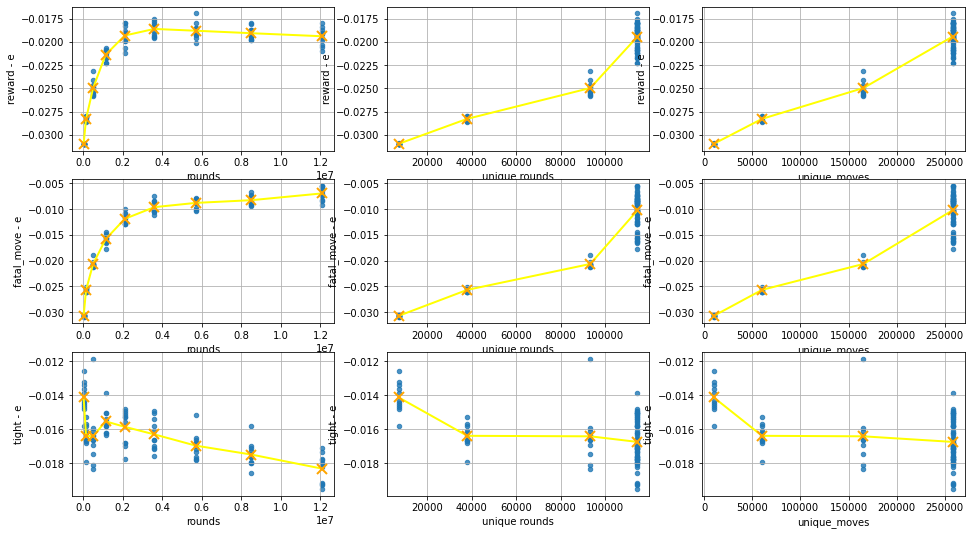

In [123]:
fig, axs = plt.subplots(3,3,figsize=(16,9))
col='e'

for j in range(3):

    for i in range(3):

        xs = top_prog.groupby(round_cols[j]).mean().index
        ys = top_prog.groupby(round_cols[j]).mean()[stats_cols[col][i]] 
        top_prog.plot.scatter(round_cols[j], stats_cols[col][i], ax=axs[i][j], alpha=0.8)

        axs[i][j].plot(xs, ys, marker='x', mec='orange', mew=2, ms=10, lw=2, color='yellow')
        axs[i][j].set(xlabel=round_cols[j], ylabel=stats_cols[col][i])
        axs[i][j].grid()
    #    axs[i].set_xlim(2.578e5, 2.584e5)

plt.show()

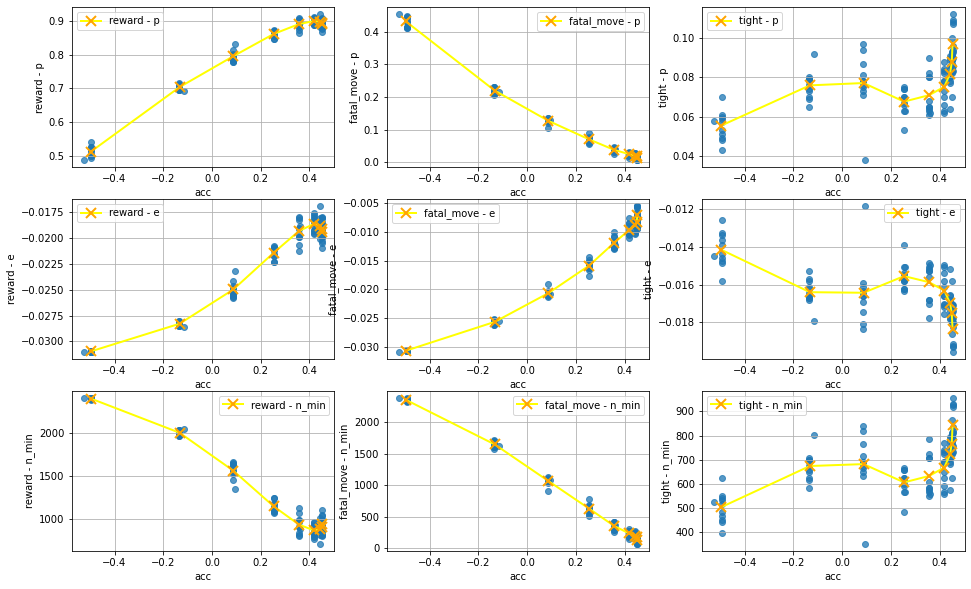

In [122]:
fig, axs = plt.subplots(3,3,figsize=(16,10))

for j, col in enumerate(['p', 'e', 'n_min']):

    for i in range(3):

        xs = top_prog.sort_values('acc')['acc']
        ys = top_prog.sort_values('acc')[stats_cols[col][i]] 
        axs[j][i].scatter(xs, ys, marker='o', alpha=0.75)
        top_prog.groupby('n').mean().plot(x='acc', y=stats_cols[col][i], ax=axs[j][i], marker='x', mec='orange', mew=2, ms=10, lw=2, color='yellow')

        axs[j][i].set(xlabel='acc', ylabel=stats_cols[col][i])
        axs[j][i].grid()

plt.show()

In [61]:
pair_cols = stats_cols['p'] + ['n', acc_cols[0]] + round_cols

#sns.pairplot(top_prog[pair_cols])

# Systems Comparison

In [ ]:
top_sys_reg = score_system(x_2, y_top_cont, n_games=100, n_times=50, player='p2', mode='regressor', cls_score=False, retraining=top_sys_reg)

### Plotting System Progression

In [ ]:
p_cols = top_sys_reg.columns[3:6]
s_cols = top_sys_reg.columns[6:9]
e_cols = top_sys_reg.columns[9:12]
n_min_cols = top_sys_reg.columns[12:15]

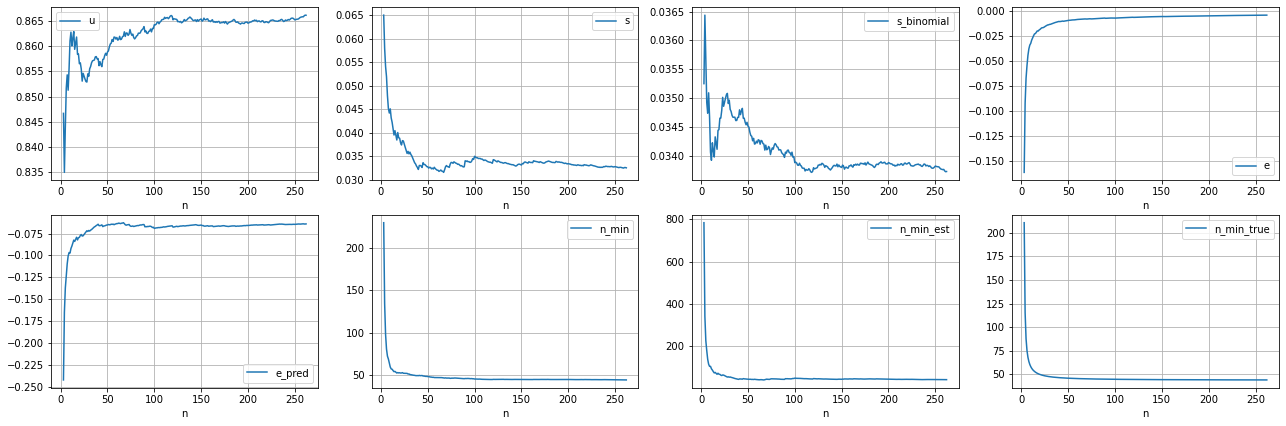

In [683]:
prog_df = system_progression(top_sys_reg, e_min=0.01, )

fig, axs = plt.subplots(2,4, figsize=(22,7))

for i, col in enumerate(prog_df.columns[1:]):

    prog_df.plot('n', col, ax=axs[(0 if i<4 else 1)][(i if i<4 else i-4)])
    axs[(0 if i<4 else 1)][(i if i<4 else i-4)].grid()
plt.show()

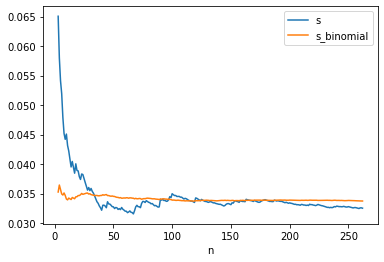

In [685]:
fig, ax = plt.subplots()
prog_df.plot('n', 's', ax=ax)
prog_df.plot('n', 's_binomial', ax=ax)

In [704]:
top_avg = top_sys_reg.groupby('name').mean()

p_i = top_sys_reg['reward - p']
u = top_avg['reward - p'].values[0]
s = top_avg['reward - s'].values[0]
print('Avg winning rate:', round(u,3))
print('Avg winning std', round(s,3))

p_min = p_i.min()
p_max=p_i.max()

x_min = u-5*s
x_max = u+5*s

s_32 = u+s*1.5
s_32_neg = u-s*1.5

xi = np.linspace(x_min, x_max, 100)
P_xi = stats.norm.pdf(xi, u, s)

P_min = P_xi.min()
P_max = P_xi.max()
Pi = np.linspace(P_min, P_max+(P_max - P_min)/3, 10)

Avg winning rate: 0.866
Avg winning std 0.034


In [705]:
a = [u, u+s, u-s, p_min, p_max, s_32, s_32_neg]
ai = [[ai for i in range(10)] for ai in a]

colors = ['blue', 'red', 'red', 'green', 'green', 'orange', 'orange']
a_str = ['u', 'u+s', 'u-s', 'p_min', 'p_max', 's_32', 's_32_neg']

ai_dict = {label:round(aj, 3) for aj, label in zip(a, a_str)}


{'u': 0.866, 'u+s': 0.9, 'u-s': 0.832, 'p_min': 0.77, 'p_max': 0.94, 's_32': 0.917, 's_32_neg': 0.815}


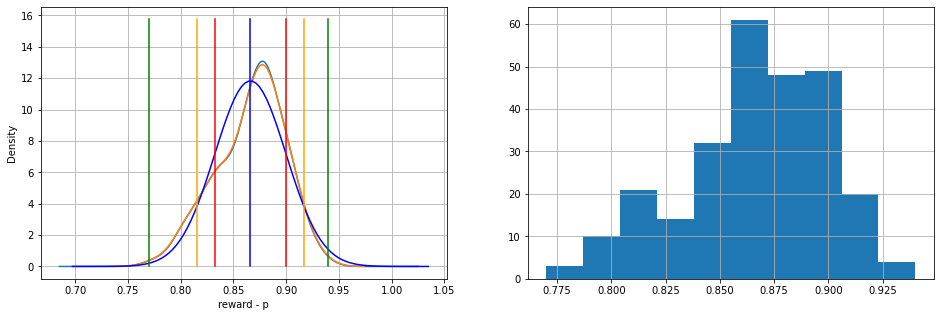

In [706]:
fig, ax = plt.subplots(1,2, figsize=(16,5))

p_i.plot.kde(ax=ax[0])
sns.distplot(p_i, kde=True, hist=False, ax=ax[0])
ax[0].plot(xi, P_xi,  color='blue')

[ax[0].plot(ai[i], Pi, color=color) for i, color in enumerate(colors)]

ax[1].hist(p_i)

[ax[i].grid() for i in [0,1]]

print(ai_dict)
plt.show()

from statsmodels.graphics.gofplots import qqplot

qqplot(p_i, line='s')
plt.show()

# Building Reward Systems as Combinations of Individual Rewards

In [303]:
df2_uni = df2_uni.iloc[:int(4e6)]

In [178]:
x = df2_uni[['round', 'obs', 'action']]

In [304]:
x, y_comb, combs_names = build_reward_systems(df2_uni, min_rewards=1, max_rewards=3, label_encode=True)

Calculating Reward Variables: 
1/129


AttributeError: 'int' object has no attribute 'sleep'

In [305]:
df2_uni=0

### Save Reward Systems in DataFrame

n_combs = len(y_comb)
for i, comb in enumerate(y_comb):
    if i==0:
        
        combs_5to6_uni = comb
    
    else:
        
        combs_5to6_uni = pd.concat([combs_5to6_uni, comb], axis=1)
        clear_output(wait=True)
        print(i, '/', n_combs)

# Calling Function to Compare Combinations of rewards

In [120]:
y_comb[0].index

RangeIndex(start=0, stop=4000000, step=1)

In [90]:
y_comb_retrain = [y_comb[combs_names.index(name)] for name in top_sys]

In [114]:
y_comb_top = [y_comb[combs_names.index(name)] for name in top_sys[:3]]

In [92]:
sys_scrs_retrain = score_n_systems(x, y_comb_retrain, n_games=1000, n_times=3, e_min=0.02, mode='regressor', retraining=None)

Converting Second Dataframe...


## Retraining

In [ ]:
sys_scrs = score_n_systems(x_2, y_comb_top, n_games=1250, n_times=5, e_min=0.015, player='p2', mode='regressor', test_size=0.2, bootstrap=False, seed=None, avg_out=False, retraining=sys_scrs, cls_score=False)

### Saving/Loading

In [42]:
#sys_scrs.to_csv('systems_comparison_6to9_900games_10_times.csv', index=False)

In [86]:
#sys_scrs.to_csv('systems_comparison_2to4_1000games_regressor_cont.csv')

#### lattest fixed

In [816]:
#sys_scrs.to_csv('systems_comparison_2to4_1500games_regressor_cont_fixed.csv')

In [1343]:
#sys_scrs.to_csv('systems_comparison_2to4_1750games_5times_regressor_cont_fixed.csv', index=False)

In [20]:
#sys_scrs.to_csv('systems_comparison_1to4_1000games_3times_regressor_cont_fixed.csv', index=False)    # 25/02/2021 - 15:48 

### df2_uni Based:

In [35]:
#sys_scrs.to_csv('systems_comparison_5to6_1000games_3times_regressor_cont_fixed_uni.csv', index=False)    # 25/02/2021 - 22:00 

In [135]:
#sys_scrs.to_csv('systems_comparison_7to9_1000games_3times_regressor_cont_fixed_uni.csv', index=False)    # 25/02/2021 - 22:00 

In [29]:
import datetime

In [605]:
#sys_scrs.to_csv('systems_comparison_4to4_1000games_3times_regressor_cont_fixed_uni.csv', index=False)  # 2021-02-26 06:00:32.207720
#print(datetime.datetime.now())

2021-02-26 06:00:32.207720


In [608]:
#sys_scrs.to_csv('systems_comparison_1to3_1000games_3times_regressor_cont_fixed_uni.csv', index=False)   # 2021-02-26 07:26:05.879735
#print(datetime.datetime.now())

2021-02-26 07:26:05.879735


In [129]:
#sys_scrs.to_csv('systems_comparison_5to9_1000games_5times_regressor_cont_fixed_uni.csv', index=False)   
print(datetime.datetime.now())

2021-02-26 14:05:45.574289


In [136]:
#sys_scrs.to_csv('systems_comparison_1to9_1000games_3times_regressor_cont_fixed_uni.csv', index=False) # Concatenated
print(datetime.datetime.now())

2021-02-26 14:16:14.752018


In [49]:
#sys_scrs.to_csv('systems_comparison_1to3_1000games_5times_regressor_cont_fixed_uni.csv', index=False)   
print(datetime.datetime.now())

2021-02-26 18:57:03.327909


In [38]:
#sys_scrs.to_csv('systems_comparison_4to4_1000games_5times_regressor_cont_fixed_uni.csv', index=False)   
print(datetime.datetime.now())

2021-02-27 10:24:46.141640


In [35]:
sys_scrs['n_rewards'].unique()

array([1, 2, 3], dtype=int64)

### Regressor Enlabeld Comparison Dataframes

In [196]:
#sys_scrs.to_csv('systems_comparison_5to9_1000games_3times_regressor', index=False)   
print(datetime.datetime.now())

2021-02-27 15:21:56.874010


## Loading

In [7]:
sys_scrs = pd.read_csv('systems_comparison_5to9_1000games_3times_regressor')

### df2_uni Based:

In [40]:
sys_scrs_1to3 = pd.read_csv('systems_comparison_1to3_1000games_3times_regressor_cont_fixed_uni.csv')    #Relateed to Regressor Classifier Using Continuous Variables.
sys_scrs_4to4 = pd.read_csv('systems_comparison_4to4_1000games_3times_regressor_cont_fixed_uni.csv')   
sys_scrs_5to6 = pd.read_csv('systems_comparison_5to6_1000games_3times_regressor_cont_fixed_uni.csv')   
sys_scrs_7to9 = pd.read_csv('systems_comparison_7to9_1000games_3times_regressor_cont_fixed_uni.csv')    
sys_scrs_1to3_5t = pd.read_csv('systems_comparison_1to3_1000games_5times_regressor_cont_fixed_uni.csv')     
sys_scrs_4to4_5t = pd.read_csv('systems_comparison_4to4_1000games_5times_regressor_cont_fixed_uni.csv')     
sys_scrs_5to9 = pd.read_csv('systems_comparison_5to9_1000games_5times_regressor_cont_fixed_uni.csv')     
    

In [41]:
sys_scrs = pd.concat([sys_scrs_1to3, sys_scrs_4to4, sys_scrs_5to6, sys_scrs_7to9,
                      sys_scrs_1to3_5t, sys_scrs_4to4_5t, sys_scrs_5to9], axis=0).reset_index(drop=True)

### Labeling Models By n_rewards and n_classes

In [96]:
sys_scrs['n_rewards'] =  [len(name.split(' + ')) for name in sys_scrs.name.tolist()]

index = sys_scrs.set_index(['n_rewards', 'n_classes']).index
index_dict = {ind_uni:i for i, ind_uni in enumerate(index.unique())}
model_label = [index_dict[ind] for ind in index]

sys_scrs['model_label'] = model_label

sys_scrs['p_dif'] = sys_scrs['reward - p'] - sys_scrs['fatal_move - p']

p_dif_top = sys_scrs.groupby('name').mean().sort_values('p_dif', ascending=False).index[:25]

# Plotting Systems Comparison

### Setting Columns

In [9]:
(reward_cols, fatal_move_cols, tight_cols) = [col + pd.Series([' - p', ' - s', ' - e', ' - n_min']) for col in ['reward', 'fatal_move', 'tight']]
stts_cols = sys_scrs.columns[3:9].tolist()
acc_cols = sys_scrs.columns[15:].tolist()

In [10]:
p_cols = ['reward', 'fatal_move', 'tight']
(reward_cols, fatal_move_cols, tight_cols) = ([col+' - '+stat for col in p_cols[:i] for stat in ['p', 'p_dif', 's', 's_dif', 'e', 'n_min']] for i in [1,2,3])
stats_cols = {['p', 'p_dif', 's', 's_dif', 'e', 'n_min'][i]:[col+' - '+stat for col in p_cols for stat in [['p', 'p_dif', 's', 's_dif', 'e', 'n_min'][i]]] for i in range(6)}

### ('n_classes', 'n_rewards', 'model_label')  VS  ('acc', 'reward - p', 'fatal_move - p', 'tight - p')

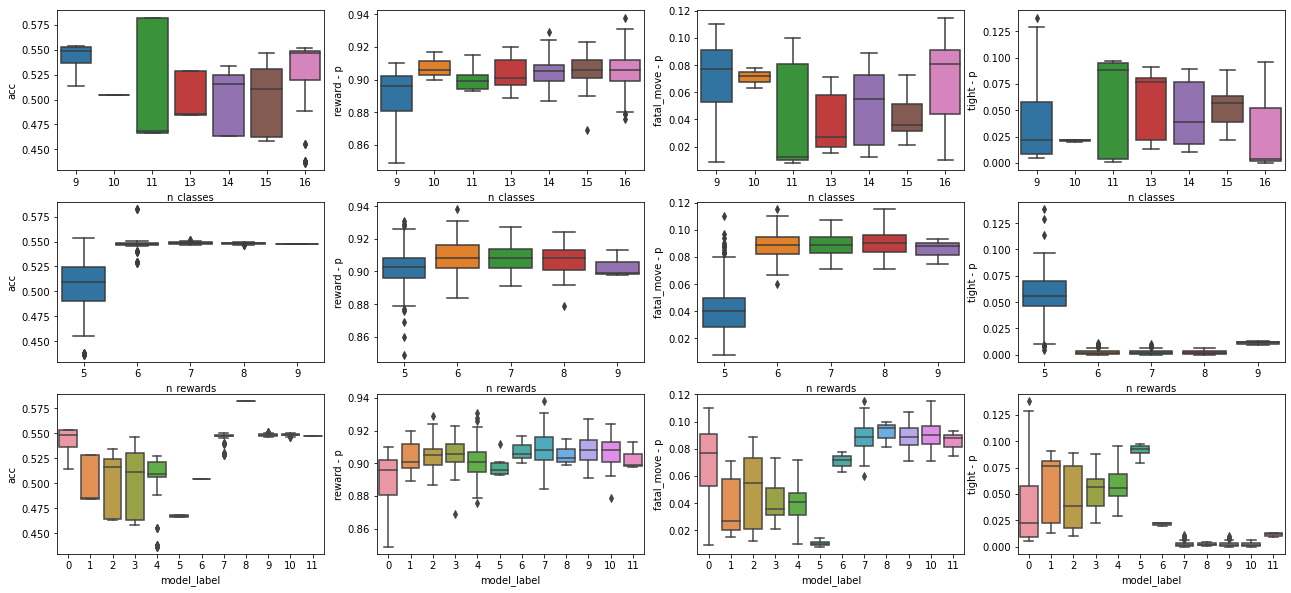

In [31]:
fig, axs = plt.subplots(3,4,figsize=(22,10))

for j, x_col in enumerate(['n_classes', 'n_rewards', 'model_label']):

    for i, y in enumerate(['acc', 'reward - p', 'fatal_move - p', 'tight - p']):

        sns.boxplot(sys_scrs[x_col], sys_scrs[y], ax=axs[j][i])
        

# Boxplot Comparisons

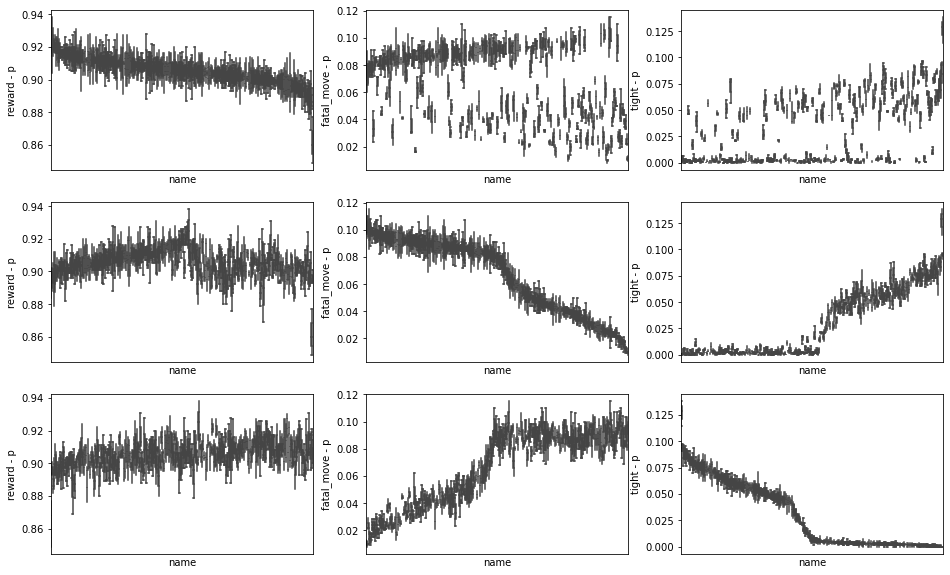

In [202]:
fig, axs = plt.subplots(3,3,figsize=(16,10))
for j in range(3):

    for i in range(3):

        sns.boxplot(data=sys_scrs[stts_cols[i:i+1]+['name']], x='name', y=stts_cols[i], ax=axs[j][i], order=sys_scrs.groupby('name').mean().sort_values(stts_cols[j], ascending=False).index)  
        axs[j][i].set_xticks([])

    # Sorted by reward

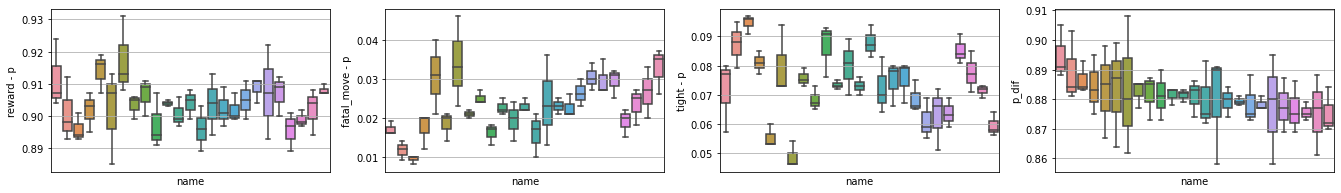

In [203]:
fig, axs = plt.subplots(1,4,figsize=(23,3))

for i, col in enumerate(stts_cols[:3]+['p_dif']):
    
    sns.boxplot(data=sys_scrs[[col, 'name']][sys_scrs.name.isin(p_dif_top)], x='name', y=col, ax=axs[i], order=p_dif_top)  # Sorted by avg_dif descending, head(50)
    axs[i].set_xticks([])
    axs[i].grid()

# Filtering Systems (Outliers)

In [42]:
quants = []
for col in stats_cols['p']+['acc']:
    quants.append(np.quantile(sys_scrs[col], np.linspace(0, 1,21)))

quants = pd.DataFrame(quants, index=stats_cols['p']+['acc'], columns=['{}%'.format(int(round(i, 2)*100)) for i in np.linspace(0, 1,21)]).T
quants.index.name = 'quantile'


In [43]:
quants.T

quantile              0%        5%       10%       15%       20%       25%  \
reward - p      0.849000  0.890000  0.894000  0.896000  0.898000  0.899000   
fatal_move - p  0.008000  0.021000  0.026000  0.032000  0.036000  0.041000   
tight - p       0.000000  0.000000  0.001000  0.001000  0.002000  0.002000   
acc             0.436473  0.463705  0.489276  0.504052  0.509027  0.509783   

quantile             30%       35%       40%       45%  ...       55%  \
reward - p      0.900000  0.902000  0.903000  0.904000  ...  0.907000   
fatal_move - p  0.044000  0.049000  0.055000  0.064150  ...  0.080000   
tight - p       0.002000  0.003000  0.004000  0.005000  ...  0.024850   
acc             0.519203  0.521388  0.525957  0.528508  ...  0.546432   

quantile             60%       65%       70%       75%       80%      85%  \
reward - p      0.908000  0.909000  0.910000  0.912000  0.914000  0.91600   
fatal_move - p  0.082000  0.085000  0.087000  0.090000  0.092000  0.09400   
tight - p       0.041000  0.047550  0.052000  0.056000  0.061000  0.06600   
acc             0.547059  0.547556  0.547707  0.548083  0.548384  0.54875   

quantile             90%       95%      100%  
reward - p      0.918000  0.921000  0.938000  
fatal_move - p  0.097000  0.100000  0.115000  
tight - p       0.073000  0.080000  0.138000  
acc             0.549047  0.549525  0.582164  

[4 rows x 21 columns]

In [97]:
sys_avgs = sys_scrs.groupby('name').mean()

top_sys = sys_avgs[(sys_avgs['fatal_move - p']<quants['fatal_move - p']['5%']) & 
                   (sys_avgs['tight - p']>quants['tight - p']['95%']) & 
                   (sys_avgs['acc']>quants['acc']['0%']) & 
                   (sys_avgs['acc']<quants['acc']['100%'])].sort_values('p_dif', ascending=False).index.tolist()


data = sys_scrs[(sys_scrs.name.isin(top_sys))]

colors = ['lightblue', 'darkblue', 'darkgreen', 'red', 'orange', 'yellow', 'brown', 'lightgreen', 'pink', 'grey']
colors_dict = {name:color for name, color in zip(top_sys, colors*10)}

len(top_sys)

4

In [98]:
top_sys = sys_scrs_retrain.name.unique().tolist()

In [99]:
#data=sys_scrs

data = sys_scrs[sys_scrs.name.isin(top_sys)]

Only top systems? y


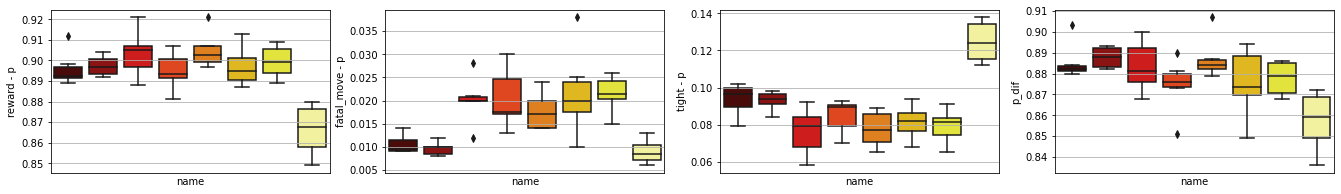

In [113]:
top = (True if input('Only top systems?')=='y' else False)
fig, axs = plt.subplots(1,4,figsize=(23,3))
for i, col in zip(range(4), stts_cols[:3]+['p_dif']):
    
    boxplot = sns.boxplot(data=data[[col, 'name']], x='name', y=col, ax=axs[i], order=(top_sys if top else None), palette='hot')  # Filtered by fatal_move, tight. Sorted by p_dif descending.
    axs[i].grid()
    axs[i].set_xticks([])
    

# Top Systems Variation

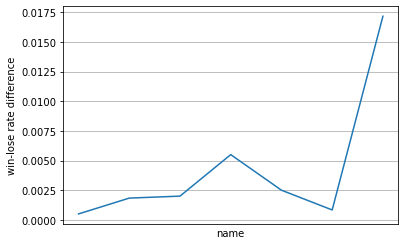

In [103]:
xs = data.groupby('name').mean()['p_dif'].sort_values(ascending=False)[:20]

ys = np.diff(xs)
ys = pd.Series(ys, index=xs.index[:-1])

(-ys).plot()
plt.xticks([])
plt.grid()
plt.ylabel('win-lose rate difference')
plt.show()

# Top Systems 3D Scatter Plot

In [104]:
colors_dict_full = {name:np.random.rand(3) for name in sys_scrs.name.unique()}

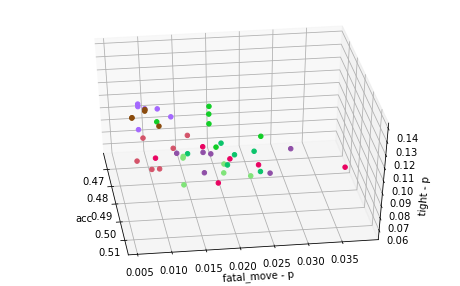

show accuracy? 


In [105]:
x_s = [stats_cols['p'][0], 'acc']
for i in range(2):

    for angle in range(1,360,9):

        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(projection='3d')

        ax.scatter(data[x_s[i]], data[stats_cols['p'][1]], data[stats_cols['p'][2]], alpha=1, c=[colors_dict_full[name] for name in data['name']])
        ax.set(xlabel=x_s[i], ylabel=stats_cols['p'][1], zlabel=stats_cols['p'][2])
        
        ax.view_init(41, angle)
        clear_output(wait=True)
        plt.show()
        plt.pause(0.001)
        
    if input('show accuracy?')=='exit': break

In [16]:
cols = ['acc']+stts_cols
cols_comb = list(itertools.combinations(cols, 3))

len(cols_comb)

35

# Cluster Evaluation

In [17]:
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from clusteval import clusteval

In [18]:
cluster = ('agglomerative',
           'kmeans',
           'dbscan',
           'hdbscan',
           'optics')

method = ('silhouette',
          'dbindex',
          'derivative',)

metric = ('euclidean',
         'hamming',
         'etc',)

linkage = ('ward',
           'single',
           'complete',
           'average',
           'weighted',
           'centroid',
           'median')

In [19]:
args = (cluster, method, metric, linkage)
args_tuple = [[(item) for item in args[i]] for i in range(4)]

config_products = list(itertools.product(metric, linkage))
len(config_products)

21

In [20]:
clusteval_args_5to6 = { 20 : dict(cluster=cluster[0], method=method[1], metric=metric[0], linkage=linkage[2], max_clust=24),          # On 5 to 6 rewards in the system:
                         4 : dict(cluster=cluster[0], method=method[0], metric=metric[0], linkage=linkage[0], max_clust=50) }

clusteval_args_filt = { 4 : dict(cluster=cluster[1], method=method[0], metric=metric[0], linkage=linkage[0], max_clust=50),           # Filtered by quantiles:
                         6 : dict(cluster=cluster[0], method=method[2], metric=metric[0], linkage=linkage[5], max_clust=50),   # Log Transformed  (or 7 clusters if not log transformed)
                         5 : dict(cluster=cluster[0], method=method[0], metric=metric[0], linkage=linkage[5], max_clust=50),   # Log Transformed
                         3 : dict(cluster=cluster[0], method=method[0], metric=metric[0], linkage=linkage[6], max_clust=50) }   # Log Transformed

In [21]:
ce = clusteval(**clusteval_args_filt[6])

X = data[['acc']+stats_cols['p'][1:]]#.apply(np.log1p)
#X['tight - p'] = (X['tight - p']*100).apply(np.log1p)
#X = data[stats_cols['p']]

results = ce.fit(np.array(X))

data['cluster'] = results['labx']


[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: centroid
[clusteval] >Evaluate using derivatives.
[clusteval] >Determining optimal clustering by derivatives..
[clusteval] >Clusters: 4
[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [4].
[clusteval] >Fin.


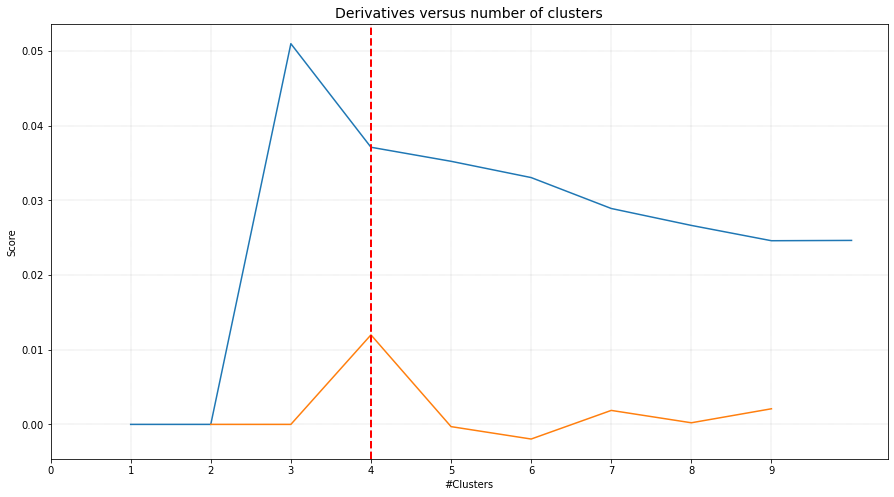

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x272581858e0>)

In [22]:
ce.plot()

[clusteval] >Estimated number of n_clusters: 4, average silhouette_score=0.657


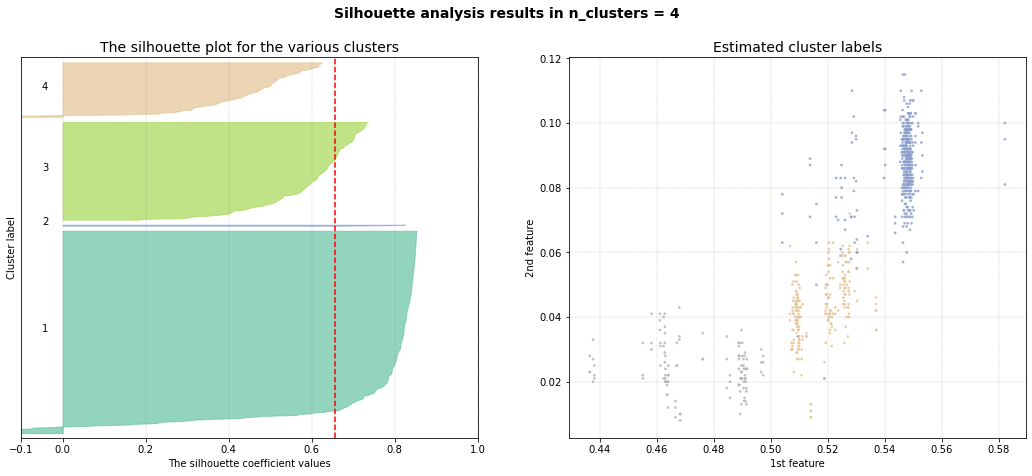

In [23]:
ce.scatter(np.array(X))

#### Dictionary with combination of arguments to plot reward as 4th dimension using dot size (s and s degree params included)

In [73]:
#s_arg_reward_param_dict = dict(sys_scrs, cols=['acc']+stts_cols, color_col='cluster', figsize=(14,8), angle_start=0, angle_stop=300, angle_rate=7, z_angle=7, scale=False, plot_axis=False, plot_diag=False, plot_wireframe=False, legend=True, s=stats_cols['p'][0], s_dgr=30, s_coef=1.25)
s_arg_reward_param_dict = 0

### Plotting 3D Scatter Plot

In [24]:
stts_cols = sys_scrs.columns[3:9].tolist()

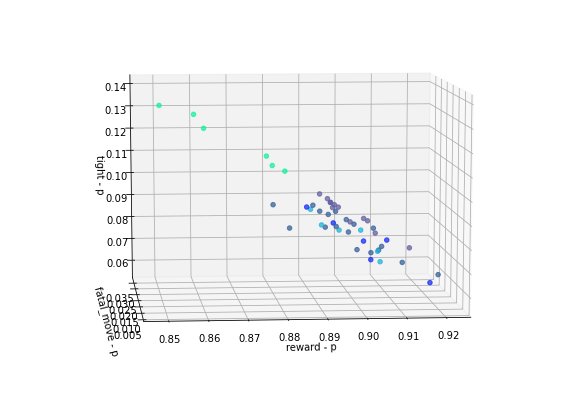

Combination 15 of 35. Combination key:  exit


In [106]:
scatter_3d_comb(data, cols=['acc']+stts_cols, color_col='model_label', alpha=0.73, z_angle=9, angle_stop=270)#, xy_lim=[(0.35,0.7), (0,0.21)])

# 3D Scatter Combinations

In [27]:
def scatter_3d_comb(sys_scrs, cols,
                    color_col='name', figsize=(10,7),
                    angle_start=1, angle_stop=360, angle_rate=8, z_angle=8,
                    scale=False, plot_axis=False, plot_diag=False, plot_wireframe=False,
                    alpha=1, s=20, s_dgr=1, s_coef=1, xy_lim=None):
    
    cols_dict = {i:col for i, col in enumerate(cols)}
    name = color_col
    colors_dict_full = {name:np.random.rand(3) for name in sys_scrs[name].unique()}
    cols_comb = list(itertools.combinations(cols, 3))
    if s!=20: s = np.array((s_coef*sys_scrs[s])**s_dgr)
    else: s = s_coef*(s**s_dgr)
    n_comb = len(cols_comb)
    control=-1
    while control!='exit':    
        
        if control==-1: 
            control_new = input('Combination {} of {}. Type "cols" to see options. Combination key: '.format('"None"', n_comb))  
            if control_new=='':control+=1
            elif control_new=='exit': break
                
            elif control_new=='cols':
                
                input_text = str(cols_dict)+'\n\n Insert in the format "458": \n\n'
                raw_cols = input(input_text)
                                
                cols_names = (cols_dict[int(digit)] for digit in raw_cols)
                cols_names_permut = itertools.permutations(cols_names, 3)
                for permutation in cols_names_permut:
                    try: control = cols_comb.index(permutation)
                    except: pass
            
            else: control = int(control_new)

        
        for angle in range(angle_start, angle_stop+1, angle_rate):

            clear_output(wait=True)
            fig = plt.figure(figsize=figsize)
            axs = fig.add_subplot(1,1,1, projection='3d')

            xlabel, ylabel, zlabel = (cols_comb[control][i] for i in range(3))
            labels = [xlabel, ylabel, zlabel]

            x_max, y_max, z_max = ((1 if not scale else sys_scrs[label].max()) for label in labels)
            x_min, y_min, z_min = ((1 if not scale else sys_scrs[label].min()) for label in labels)
            
            if plot_axis:
                OX = pd.DataFrame([(xi, 0, 0) for xi in np.linspace(x_min, x_max, 100)], columns=['x', 'y', 'z'])
                OY = pd.DataFrame([(0, yi, 0) for yi in np.linspace(y_min, y_max, 100)], columns=['x', 'y', 'z'])
                OZ = pd.DataFrame([(0, 0, zi) for zi in np.linspace(z_min, z_max, 100)], columns=['x', 'y', 'z'])
                [axs.plot(O_ax['x'], O_ax['y'], O_ax['z'], color='black', linewidth = 1.5) for O_ax in [OX, OY, OZ]]
            
            x_45 = np.linspace(x_min, x_max, 100)
            y_45 = np.linspace(y_min, y_max, 100)
            z_45 = np.linspace(z_min, z_max, 100)
            z_scale = np.linspace(1-x_min, 1-x_max, 100)
            zeros = np.zeros(100)
            
            if plot_diag:
                axs.plot(x_45, 1-x_45, zeros, color='black', linewidth = 1.5)
                if not scale: axs.plot(zeros, y_45, 1-y_45, color='black', linewidth = 1.5)
                axs.plot(1-z_scale, zeros, z_scale, color='black', linewidth = 1.5)

            if plot_wireframe:
                x1, y1 = np.meshgrid(x_45, np.linspace(0, 1-x_min, 100))
                z1 = 1 - x1 - y1
                axs.plot_wireframe(x1, y1, z1, cstride=10, rstride=10, alpha=0.45)
                axs.set(ylim=(0), zlim=(0))
            
            axs.scatter(sys_scrs[xlabel], sys_scrs[ylabel], sys_scrs[zlabel], c=[colors_dict_full[name] for name in sys_scrs[name]], alpha=alpha, s=s)        
            
            axs.set(xlabel=xlabel, ylabel=ylabel, zlabel=zlabel)
            if type(xy_lim)!=type(None): axs.set(xlim=xy_lim[0], ylim=xy_lim[1])
                
            axs.view_init(z_angle, angle)
            plt.show()
            plt.pause(0.001)

        control_new = input('Combination {} of {}. Combination key: '.format(control, n_comb))  

        if control_new=='':control+=1
        elif control_new=='exit': break
            
        elif control_new=='cols':

            input_text = str(cols_dict)+'\n\n Insert in the format "458": \n\n'
            raw_cols = input(input_text)

            cols_names = (cols_dict[int(digit)] for digit in raw_cols)
            cols_names_permut = itertools.permutations(cols_names, 3)
            for permutation in cols_names_permut:
                try: control = cols_comb.index(permutation)
                except: pass
            
        else: control = int(control_new)


In [28]:
import warnings
warnings.filterwarnings("ignore")

In [87]:
colors_dict_full = {name:np.random.rand(3) for name in sys_scrs.name.unique()}

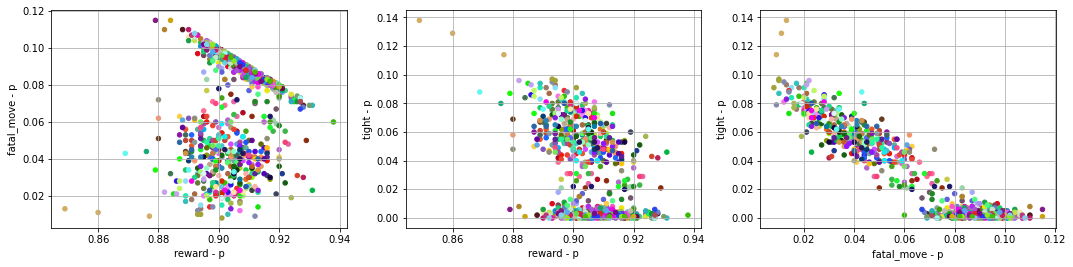

In [66]:
fig, axs = plt.subplots(1,3,figsize=(18,4))
cnt=0
for i in range(3):
    for j in range(3):
        if i<j:
            
            sys_scrs.plot.scatter(stats_cols['p'][i], stats_cols['p'][j], ax=axs[cnt], c=[colors_dict_full[name] for name in sys_scrs.name])
         
            axs[cnt].grid()
            cnt+=1

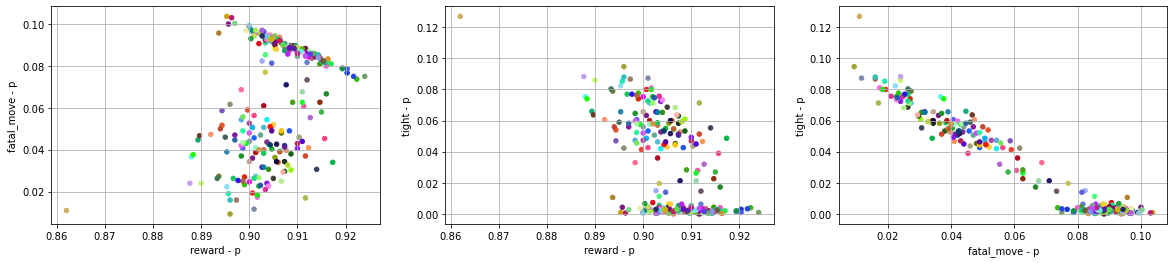

In [57]:
sys_avg = sys_scrs.groupby('name').mean()
fig, axs = plt.subplots(1,3,figsize=(20,4))
cnt=0
for i in range(3):
    for j in range(3):
        if i<j:
            
            sys_avg.plot.scatter(stats_cols['p'][i], stats_cols['p'][j], ax=axs[cnt], c=[colors_dict_full[name] for name in sys_avg.index])
            
            axs[cnt].grid()
            cnt+=1

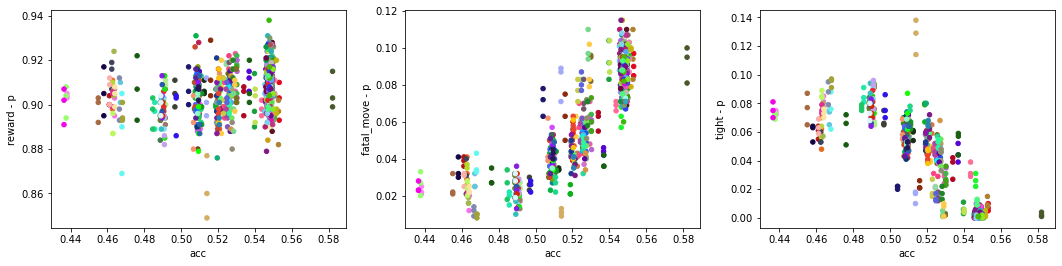

In [35]:
fig, axs = plt.subplots(1,3,figsize=(18,4))
cnt=0
for i in range(3):
    sys_scrs.plot.scatter('acc', stats_cols['p'][i], ax=axs[i], c=[colors_dict_full[name] for name in sys_scrs.name])
    cnt+=1

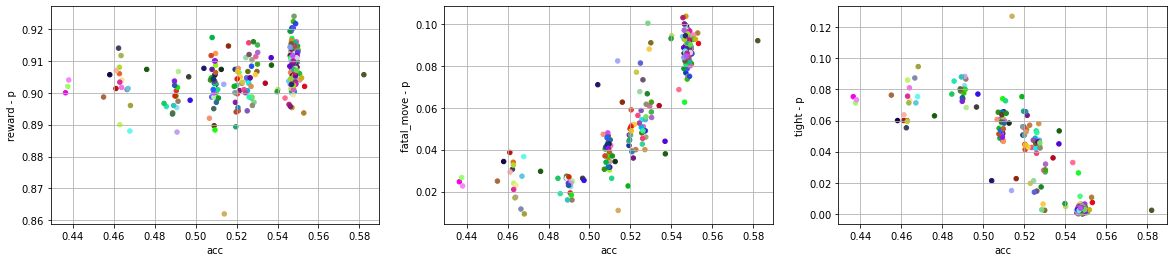

In [36]:
sys_avg = sys_scrs.groupby('name').mean()
fig, axs = plt.subplots(1,3,figsize=(20,4))
cnt=0
for i in range(3):

    sys_avg.plot.scatter('acc', stats_cols['p'][i], ax=axs[cnt], c=[colors_dict_full[name] for name in sys_avg.index])

    axs[cnt].grid()
    cnt+=1

In [ ]:
sns.pairplot(data[['acc', 'cluster']+stts_cols], hue='cluster')
plt.show()

# Top System Definition

In [21]:
import itertools

In [53]:

rewards_names = ['reward',
 'reward_ttl',
 'reward_decay',
 'fatal_move',
 'fatal_move_ttl',
 'fatal_move_decay',
 'tight',
 'tight_ttl',
 'tight_decay']

a_i = [1, 1, 1, -1, -1, -1, -1, -1, -1]
yi_2 = [df2[name]*a for name, a in zip(rewards_names, a_i)]

combs_2to8 = []
for comb_size in range(2,9):
    combs_2to8 = combs_2to8 + list(itertools.combinations(range(9), comb_size))

y_comb28 = []
combs_names28 = []
n_combs = len(combs_2to8)
for i, comb in enumerate(combs_2to8):
    y_comb28.append(sum([yi_2[i] for i in comb]))
    combs_names28.append(' + '.join([rewards_names[i] for i in comb]))
    print('{}/{}'.format(i+1, n_combs))
    clear_output(wait=True)
yi_2 = [pd.Series(le().fit_transform(y), index=y.index, name=name) for y, name in zip(yi_2, rewards_names)]
y_comb28 = [pd.Series(le().fit_transform(y), index=y.index, name=name) for y, name in zip(y_comb28, combs_names28)]


501/501


In [73]:
play_n_games(100, avg_out=True)[1]

Converting First Dataframe...
Converting Second Dataframe...


array([0.27      , 0.56      , 0.17      , 0.44619604, 0.49888765,
       0.37752517])

In [75]:
top_y_top

0           4
1           2
2           0
3           7
4           7
           ..
10586786    6
10586787    6
10586788    6
10586789    6
10586790    6
Name: reward + reward_ttl + fatal_move + fatal_move_decay, Length: 10586791, dtype: int64

In [ ]:
top_n_games = play_n_games(100, avg_out=True)[1]

# Sample Model

### Create Extra Three Model Using Random Split Sample given x and y

In [12]:
from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [26]:
x_2.shape[1]

3

In [29]:
nn = Sequential()
nn.add(Dense(10, input_shape = (x_2.shape[1],), activation='sigmoid'))
nn.add(Dense(len(y_top.unique())-1, activation='sigmoid'))

nn.compile(SGD(lr=0.001), loss='safbs', metrics=['accuracy'])

In [18]:
def neural_nets(x, y, layers=[10], activation='sigmoid', learning_rate=0.001, loss='categorical_crossentropy', metrics=['accuracy'], epochs=200, test_size=0.2, score=True, classification_matrix=False, cls_score=True):

    n_classes = len(y.unique())
    msk = np.random.rand(len(y))<(1-test_size)
    
    x_train, x_test, y_train, y_test = x[msk], x[~msk], y[msk], y[~msk]

    model = Sequential()
    
    for step, layer in enumerate(layers):
        
        model.add(Dense(layer, input_shape = (x.shape[1],), activation = activation))
    
    model.add(Dense( n_classes-1 , activation='sigmoid'))
    print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
   
    model.compile(SGD(lr = learning_rate), loss, metrics=metrics)    
    
    run_hist = model.fit(x_train, y_train, validation_data=[x_test, y_test], epochs=epochs)
    
    
    y_pred = model.predict(x_test)
    
    if score: acc = acc_scr(y_test, y_pred)
    else: acc=0
        
    if confusion_matrix: conf_matrix = cm(y_test, y_pred)
    else: conf_matrix=0

    if cls_score: cls_acc = pd.DataFrame(cls_report).T.head(-3)[cls_metric].tolist()
    else: cls_acc=0
        
    output_control = [score, cls_score, confusion_matrix]
    outputs = [output for output in pd.Series([acc, cls_acc, conf_matrix])[output_control]]
    
    return model, outputs, run_hist


In [ ]:
top_nn, (nn_acc, nn_cls_acc), top_hist = neural_nets(x_2, y_top, layers=[10], learning_rate=0.001, epochs=200, test_size=0.2, score=True, classification_matrix=False, cls_score=True)


# Proportion Estimation

# N Systems Comparison

In [22]:
import scipy.stats as stats

In [13]:
def score_n_systems(x, y_sys, n_models=5, n_seeds=None, reuse_seeds=True,
                    verbose=0,
                    n_jobs=-1,
                    mode='classifier',
                    score=True,
                    test_size=0.2,
                    label_encode=False,
                    n_times=5,
                    n_games=100,
                    player='p2',
                    reuse_dfs=False,
                    retraining=None,
                    n_games_start=1,
                    avg_out=True,
                    old_dfs=None, 
                    avg_twice=True,
                    n_times_report=True,
                    n_games_report=False):
    
    sys_len = len(y_sys)
    y_len = len(y_sys[0])
    model_p1='random'
    model_p2='random'
    n_models1 = []
    n_models2 = []
    cls_cols = ['class {}'.format(n_cls) for n_cls in range(1, max([len(y.unique()) for y in y_sys])+1)]
    
    if reuse_seeds: n_seeds = [np.random.rand(y_len)<(1-test_size) for i in range(n_models)]
    for y, model in zip(y_sys, range(1, sys_len+1)):
        
        name = y.name
        n_classes = len(y.unique())
        if type(n_seeds)==type(None): n_seeds = [np.random.rand(y_len)<(1-test_size) for i in range(n_models)]           
        seeds_names = [name+' - seed {}'.format(j) for j in range(n_models+1)]
        clear_output(wait=True)
        
        cnt=0
        for seed, seed_name in zip(n_seeds, seeds_names):
            cnt+=1
            print('seed {} of {} of system {} of {}'.format(cnt, n_models, model, sys_len))
                
            #-------- Building Player Model Using Random Split for Reward System --------
            y_model, acc, acc_cls = sample_model(x, y, seed=seed, verbose=verbose, n_jobs=n_jobs, mode=mode, score=score, test_size=test_size, label_encode=label_encode)            
            accs = [acc] + acc_cls
            
            
            if player=='p1': model_p1 = y_model
            else: model_p2 = y_model
                
            #--------- Playing Game with New Model ----------------
            
            df1, df2 = play_n_times(n_times=n_times, n_games=n_games, model_p1=model_p1, model_p2=model_p2, avg_out=avg_out, reuse_dfs=reuse_dfs, old_dfs=old_dfs, avg_twice=avg_twice, report=n_times_report, n_games_report=n_games_report)            
            df1['name'], df2['name'] = name, name
            df1['seed'], df2['seed'] = seed_name, seed_name
            df1['n_classes'], df2['n_classes'] = n_classes, n_classes
            
            for acc, cls_col in zip(accs, ['acc']+cls_cols):
                df1[cls_col] = acc
                df2[cls_col] = acc
            if avg_twice:
                n_models1.append(df1.tolist())
                n_models2.append(df2.tolist())
            else:
                n_models1.append(df1)
                n_models2.append(df2)

#    df1 = pd.concat(n_models1, axis=(1 if type(n_models1[0])==type(pd.Series()) else 0))
 #   df2 = pd.concat(n_models2, axis=(1 if type(n_models1[0])==type(pd.Series()) else 0))               
    if avg_twice:        
        cols = ['reward_avg', 'fatal_move_avg', 'tight_avg', 'reward_std', 'fatal_move_std', 'tight_std', 'name', 'seed', 'n_classes', 'acc'] + cls_cols
        df1 = pd.DataFrame(n_models1, columns=cols)
        df2 = pd.DataFrame(n_models2, columns=cols)
            
    else:
        df1 = pd.concat(n_models1, axis=0)
        df2 = pd.concat(n_models2, axis=0)
        
    re_col = ['name', 'n_classes', 'seed', 'reward_avg', 'fatal_move_avg', 'tight_avg', 'reward_std', 'fatal_move_std', 'tight_std', 'acc'] + cls_cols
    df1 = df1[re_col]
    df2 = df2[re_col]
    
    if type(retraining)!=type(None):
        df1 = pd.concat([retraining[0], df1], axis=0).sort_values(by=['name', 'seed']).reset_index(drop=True)
        df2 = pd.concat([retraining[1], df2], axis=0).sort_values(by=['name', 'seed']).reset_index(drop=True)
    
    return df1, df2   
            

# Rewardss Systems Definitions

In [1596]:
yi_all = []
names_all = []
x_2 = df2[['round', 'obs', 'action']]

In [501]:
rewards_names = ['reward',
 'reward_ttl',
 'reward_decay',
 'fatal_move',
 'fatal_move_ttl',
 'fatal_move_decay',
 'tight',
 'tight_ttl',
 'tight_decay']

In [502]:
rewards = {name:df2[name] for name in rewards_names}
rewards = {name:pd.Series(le().fit_transform(y_i), index=y_i.index, name=name) for name, y_i in zip(rewards.keys(), rewards.values())}

a_i = [1, 1, 1, -1, -1, -1, -1, -1, -1]
yi_2 = [y*a for y, a in zip(rewards.values(), a_i)]

for y, name in zip(yi_2, rewards_names):
    yi_all.append(y)
    names_all.append(name)

In [503]:
[a, b, c, d, e, f, g, h, k] = [df2[name] for name in rewards_names]

In [504]:
rewards_names = ['all', 'simple', 'ttl', 'decay']

yi_2 = [a+b+c-d-e-f-g-h-k,
        a-d-g,
        b-e-h,
        c-f-k]
yi_2 = [pd.Series(le().fit_transform(y), index=y.index, name=name) for y, name in zip(yi_2, rewards_names)]

for y, name in zip(yi_2, rewards_names):
    yi_all.append(y)
    names_all.append(name)

In [505]:
rewards_names = ['only_rewards', 'only_fatal_moves', 'only_tights']

yi_2 = [a+b+c,
        -d-e-f,
        -g-h-k]

yi_2 = [pd.Series(le().fit_transform(y), index=y.index, name=name) for y, name in zip(yi_2, rewards_names)]

for y, name in zip(yi_2, rewards_names):
    yi_all.append(y)
    names_all.append(name)

In [506]:
rewards_names = ['all_prod', 'all+all_prod', 'reward_prod', 'fatal_move_prod', 'tight_prod']

yi_2 = [(a+b)*c - (d+e)*f - (g+h)*k,
        a+b+c-d-e-f-g-h-k + (a+b)*c - (d+e)*f - (g+h)*k,
        (a+b)*c,
        - (d+e)*f,
        - (g+h)*k]

yi_2 = [pd.Series(le().fit_transform(y), index=y.index, name=name) for y, name in zip(yi_2, rewards_names)]

for y, name in zip(yi_2, rewards_names):
    yi_all.append(y)
    names_all.append(name)

In [489]:
rewards_names = ['all+all_prod']

y_sum = a+b+c-d-e-f-g-h-k
y_sum += (a+b)*c
y_sum += -(d+e)*f 
y_sum += -(g+h)*k
yi_2 = [y_sum]
yi_2 = [pd.Series(le().fit_transform(y), index=y.index, name=name) for y, name in zip(yi_2, rewards_names)]

for y, name in zip(yi_2, rewards_names):
    yi_all.append(y)
    names_all.append(name)

In [749]:
import itertools

rewards_names = ['all_prod', 'all+all_prod', 'all', 'decay']

yi_2 = [(a+b)*c - (d+e)*f - (g+h)*k,
        a+b+c-d-e-f-g-h-k + (a+b)*c - (d+e)*f - (g+h)*k,
        a+b+c-d-e-f-g-h-k,
        c-f-k]

y_comb = []
combs_names = []
combinations = list(itertools.combinations(range(4), 2)) + list(itertools.combinations(range(4), 3))
for comb in combinations:
    y_comb.append(sum([yi_2[i] for i in comb]))
    combs_names.append(' + '.join([rewards_names[i] for i in comb]))

yi_2 = [pd.Series(le().fit_transform(y), index=y.index, name=name) for y, name in zip(yi_2, rewards_names)]
y_comb = [pd.Series(le().fit_transform(y), index=y.index, name=name) for y, name in zip(y_comb, combs_names)]


In [786]:
rewards_names = ['reward',
 'reward_ttl',
 'reward_decay',
 'fatal_move',
 'fatal_move_ttl',
 'fatal_move_decay']

a_i = [1, 1, 1, -1, -1, -1, -1, -1, -1]
yi_2 = [df2[name]*a for name, a in zip(rewards_names, a_i)]

combs_2to5 = []
for comb_size in range(2,6):
    combs_2to5 = combs_2to5 + list(itertools.combinations(range(6), comb_size))

y_comb = []
combs_names = []
for comb in combs_2to5:
    y_comb.append(sum([yi_2[i] for i in comb]))
    combs_names.append(' + '.join([rewards_names[i] for i in comb]))

yi_2 = [pd.Series(le().fit_transform(y), index=y.index, name=name) for y, name in zip(yi_2, rewards_names)]
y_comb = [pd.Series(le().fit_transform(y), index=y.index, name=name) for y, name in zip(y_comb, combs_names)]


In [76]:
top_model, (acc, cls_acc, conf_matrix) = sample_model(x_2, y_top, score=True, cls_score=True, confusion_matrix=True)

C:\Users\luisr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
a = play_game(model_p2=top_model, model_p1='human')

[[0 0 0]
 [0 0 0]
 [0 0 0]]
Ok


Entre sua Jogada:  7


[['o' '0' '0']
 ['0' '0' '0']
 ['0' '0' 'x']]
Ok


Entre sua Jogada:  4


[['o' '0' 'x']
 ['o' '0' '0']
 ['0' '0' 'x']]
Ok


Entre sua Jogada:  1


In [30]:
top_sys_old = pd.read_csv('reward + reward_ttl + fatal_move + fatal_move_decayrandom_seeds.csv', index_col=0)

In [31]:
sys_comb_df1 = pd.read_csv('/Users/luisr/Desktop/Repository/IBM_courses/Personal Work/Notebooks/Machine Learning Basics/Reinforcement Learning/comb_systems_comparison_df1.csv')
sys_comb_df2 = pd.read_csv('/Users/luisr/Desktop/Repository/IBM_courses/Personal Work/Notebooks/Machine Learning Basics/Reinforcement Learning/comb_systems_comparison_df2.csv')

In [32]:
sys_comb_top4_df1 = pd.read_csv('/Users/luisr/Desktop/Repository/IBM_courses/Personal Work/Notebooks/Machine Learning Basics/Reinforcement Learning/top4_comb_systems_comparison_df1.csv')
sys_comb_top4_df2 = pd.read_csv('/Users/luisr/Desktop/Repository/IBM_courses/Personal Work/Notebooks/Machine Learning Basics/Reinforcement Learning/top4_comb_systems_comparison_df2.csv')

# Combinations Comparison

In [34]:
1e1

10.0

In [157]:
df2_lite = df2[df2.game<1e6+1].copy()

In [161]:
x_2_lite = df2_lite[['round', 'obs', 'action']]

rewards_names = ['reward',
 'reward_ttl',
 'reward_decay',
 'fatal_move',
 'fatal_move_ttl',
 'fatal_move_decay',
 'tight',
 'tight_ttl',
 'tight_decay']

a_i = [1, 1, 1, -1, -1, -1, -1, -1, -1]
yi_2 = [df2_lite[name]*a for name, a in zip(rewards_names, a_i)]

combs = []
for comb_size in range(6,9):
    combs = combs + list(itertools.combinations(range(9), comb_size))

len(combs)

129

In [162]:
len(yi_2)

9

In [47]:
y_comb = []
combs_names = []
n_combs = len(combs)
for i, comb in enumerate(combs):
    y_comb.append(sum([yi_2[i] for i in comb]))
    combs_names.append(' + '.join([rewards_names[i] for i in comb]))
    print('{}/{}'.format(i+1, n_combs))
    clear_output(wait=True)

129/129


In [49]:
yi_2 = [pd.Series(le().fit_transform(y), index=y.index, name=name) for y, name in zip(yi_2, rewards_names)]

In [50]:
y_comb48 = [pd.Series(le().fit_transform(y), index=y.index, name=name) for y, name in zip(y_comb48, combs_names48)]

In [52]:
sys = score_n_systems(x_2, y_comb48, n_models=1, n_times=1, n_games=100, n_seeds=None, reuse_seeds=True, avg_out=True, avg_twice=True, retraining=None)

seed 1 of 1 of system 1 of 129


C:\Users\luisr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: not enough values to unpack (expected 3, got 2)

In [19]:
sys[1].groupby('name').mean().head()

NameError: name 'sys' is not defined

# 501 combinations systems comparison

In [904]:
#sys[0].to_csv('comb_systems_comparison_df1.csv')
#sys[1].to_csv('comb_systems_comparison_df2.csv')

# 21 systems comparison

In [602]:
#sys[0].to_csv('21_systems_comparison_df1.csv')

#sys[1].to_csv('21_systems_comparison_df2.csv')

# reward and loss combination comparison

In [810]:
#sys[0].to_csv('reward_loss_comb_systems_comparison_df1.csv')
#sys[1].to_csv('reward_loss_comb_systems_comparison_df2.csv')

# top 4 systems comparison

In [688]:
#sys[0].to_csv('top4_systems_comparison_df1.csv')
#sys[1].to_csv('top4_systems_comparison_df2.csv')

# top 4 systems combinations comparison

In [781]:
#sys[0].to_csv('top4_comb_systems_comparison_df1.csv')
#sys[1].to_csv('top4_comb_systems_comparison_df2.csv')

In [912]:
df2

round      obs  action  reward  fatal_move  reward_ttl  reward_decay  \
0           1        4       3       0           0           0          0.00   
1           2      430       8       0           0           0          0.00   
2           3    43087       5       0           1           0          0.00   
3           1        3       0       0           0           1          0.25   
4           2      306       8       0           0           1          0.50   
...       ...      ...     ...     ...         ...         ...           ...   
264958      2      502       7       0           0           0          0.00   
264959      3    50276       3       0           0           0          0.00   
264960      4  5027631       8       0           0           0          0.00   
264961      1        1       0       0           0           0          0.00   
264962      2      104       3       0           1           0          0.00   

        fatal_move_ttl  fatal_move_decay  tight  tight_ttl  tight_decay   game  
0                    1          0.333333    0.0        0.0     0.000000      1  
1                    1          0.666667    0.0        0.0     0.000000      1  
2                    1          1.000000    0.0        0.0     0.000000      1  
3                    0          0.000000    0.0        0.0     0.000000      2  
4                    0          0.000000    0.0        0.0     0.000000      2  
...                ...               ...    ...        ...          ...    ...  
264958               0          0.000000    0.0        1.0     0.333333  74999  
264959               0          0.000000    0.0        1.0     0.666667  74999  
264960               0          0.000000    1.0        1.0     1.000000  74999  
264961               1          0.500000    0.0        0.0     0.000000  75000  
264962               1          1.000000    0.0        0.0     0.000000  75000  

[264963 rows x 13 columns]

# add avg_dif

In [888]:
colors = ['darkred', 'purple', 'pink', 'lightblue', 'darkblue', 'olive', 'yellow', 'grey', 'orange', 'violet', 'darkgreen', 'lightgreen', 'green']*1000

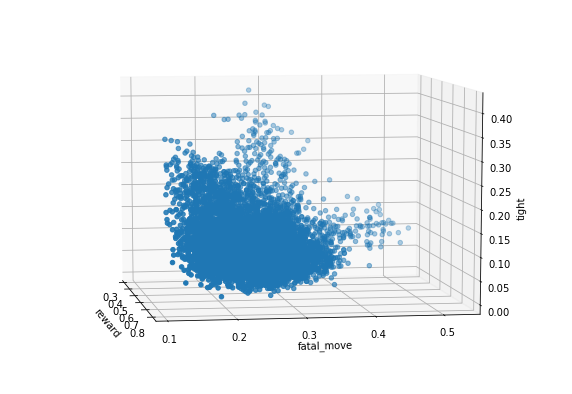

In [1009]:
for angle in range(1,360,10):

    fig = plt.figure(figsize=(10,7))
    ax0 = fig.add_subplot(1,1,1, projection='3d')

    ax0.scatter(sys[1]['reward_avg'], sys[1]['fatal_move_avg'], sys[1]['tight_avg'])#, c=[colors[label] for label in le().fit_transform(sys[1]['name'])], alpha=1)
    ax0.view_init(8, angle)
    ax0.set(xlabel='reward', ylabel='fatal_move', zlabel='tight')
    
    plt.show()
    plt.pause(0.001)
    clear_output(wait=True)
    


In [963]:
x = np.linspace(sys[1]['reward_std'].min(), sys[1]['reward_std'].max(), 500)
y = np.linspace(sys[1]['fatal_move_std'].min(), sys[1]['fatal_move_std'].max(), 500)
#x = np.linspace(-1,1,500)
#y = np.linspace(-1,1,500)

x1, y1 = np.meshgrid(x,y)
z = x1/y1



In [944]:
x1

array([[-7.        , -6.98196393, -6.96392786, ...,  1.96392786,
         1.98196393,  2.        ],
       [-7.        , -6.98196393, -6.96392786, ...,  1.96392786,
         1.98196393,  2.        ],
       [-7.        , -6.98196393, -6.96392786, ...,  1.96392786,
         1.98196393,  2.        ],
       ...,
       [-7.        , -6.98196393, -6.96392786, ...,  1.96392786,
         1.98196393,  2.        ],
       [-7.        , -6.98196393, -6.96392786, ...,  1.96392786,
         1.98196393,  2.        ],
       [-7.        , -6.98196393, -6.96392786, ...,  1.96392786,
         1.98196393,  2.        ]])

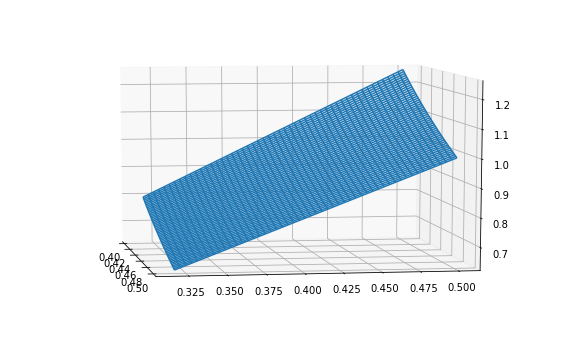

In [959]:
for angle in range(1,360,10):

    fig = plt.figure(figsize=(10,6))
    ax0 = fig.add_subplot(1,1,1, projection='3d')

    ax0.plot_wireframe(x1,y1,z)
    ax0.view_init(8,angle)
    plt.show()
    plt.pause(0.001)
    clear_output(wait=True)
    
    

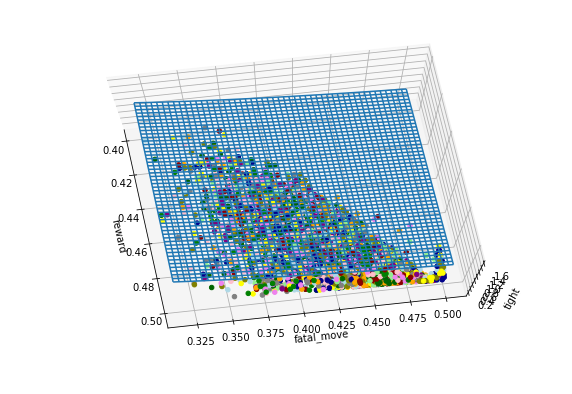

In [964]:
for angle in range(1,360,10):

    fig = plt.figure(figsize=(10,7))
    ax0 = fig.add_subplot(1,1,1, projection='3d')

    ax0.scatter(sys[1]['reward_std'], sys[1]['fatal_move_std'], sys[1]['tight_std'], c=[colors[label] for label in le().fit_transform(sys[1]['name'])], alpha=1)
    ax0.view_init(8+angle/5, angle)
    ax0.set(xlabel='reward', ylabel='fatal_move', zlabel='tight')
    ax0.plot_wireframe(x1,y1,z, rstride=10, cstride=10)

    plt.show()
    plt.pause(0.001)
    clear_output(wait=True)
    


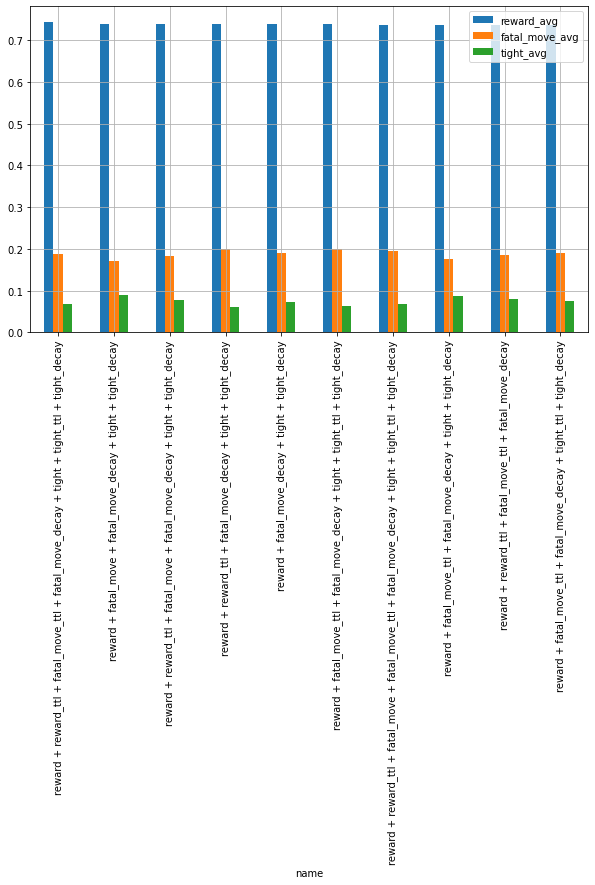

In [1023]:
sys[1].groupby('name').mean()[['reward_avg', 'fatal_move_avg', 'tight_avg']].sort_values(by=['reward_avg', 'fatal_move_avg', 'tight_avg'], ascending=False).head(10).plot.bar(figsize=(10,6))
plt.grid()
plt.show()

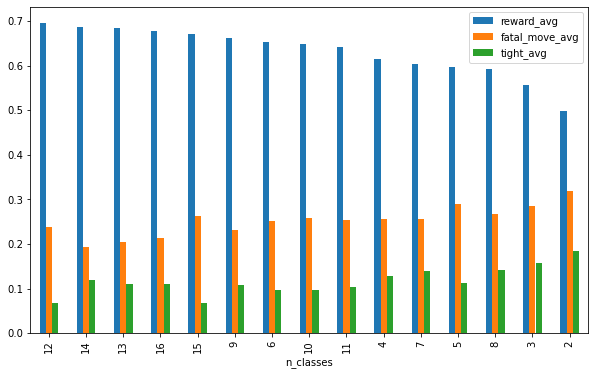

In [995]:
sys[1].groupby('n_classes').mean()[['reward_avg', 'fatal_move_avg', 'tight_avg']].sort_values(by=['reward_avg', 'fatal_move_avg', 'tight_avg'], ascending=False).plot.bar(figsize=(10,6))

In [1004]:
len(sys[1][sys[1].n_classes.isin([12,14])].name.unique())

41

C:\Users\luisr\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\luisr\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\luisr\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or s

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002CFEC701C70>,
      dtype=object)

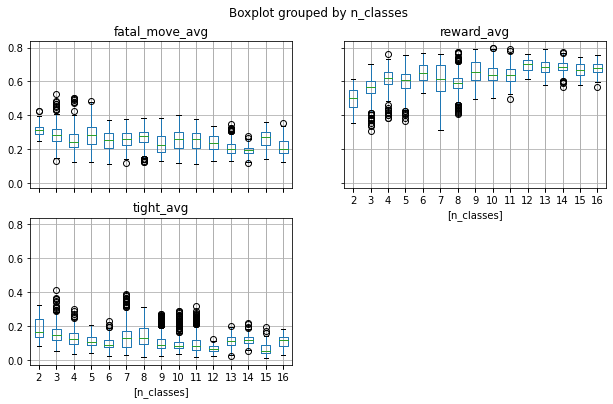

In [999]:
sys[1][['n_classes', 'reward_avg', 'fatal_move_avg', 'tight_avg']].boxplot(by='n_classes', figsize=(10,6))

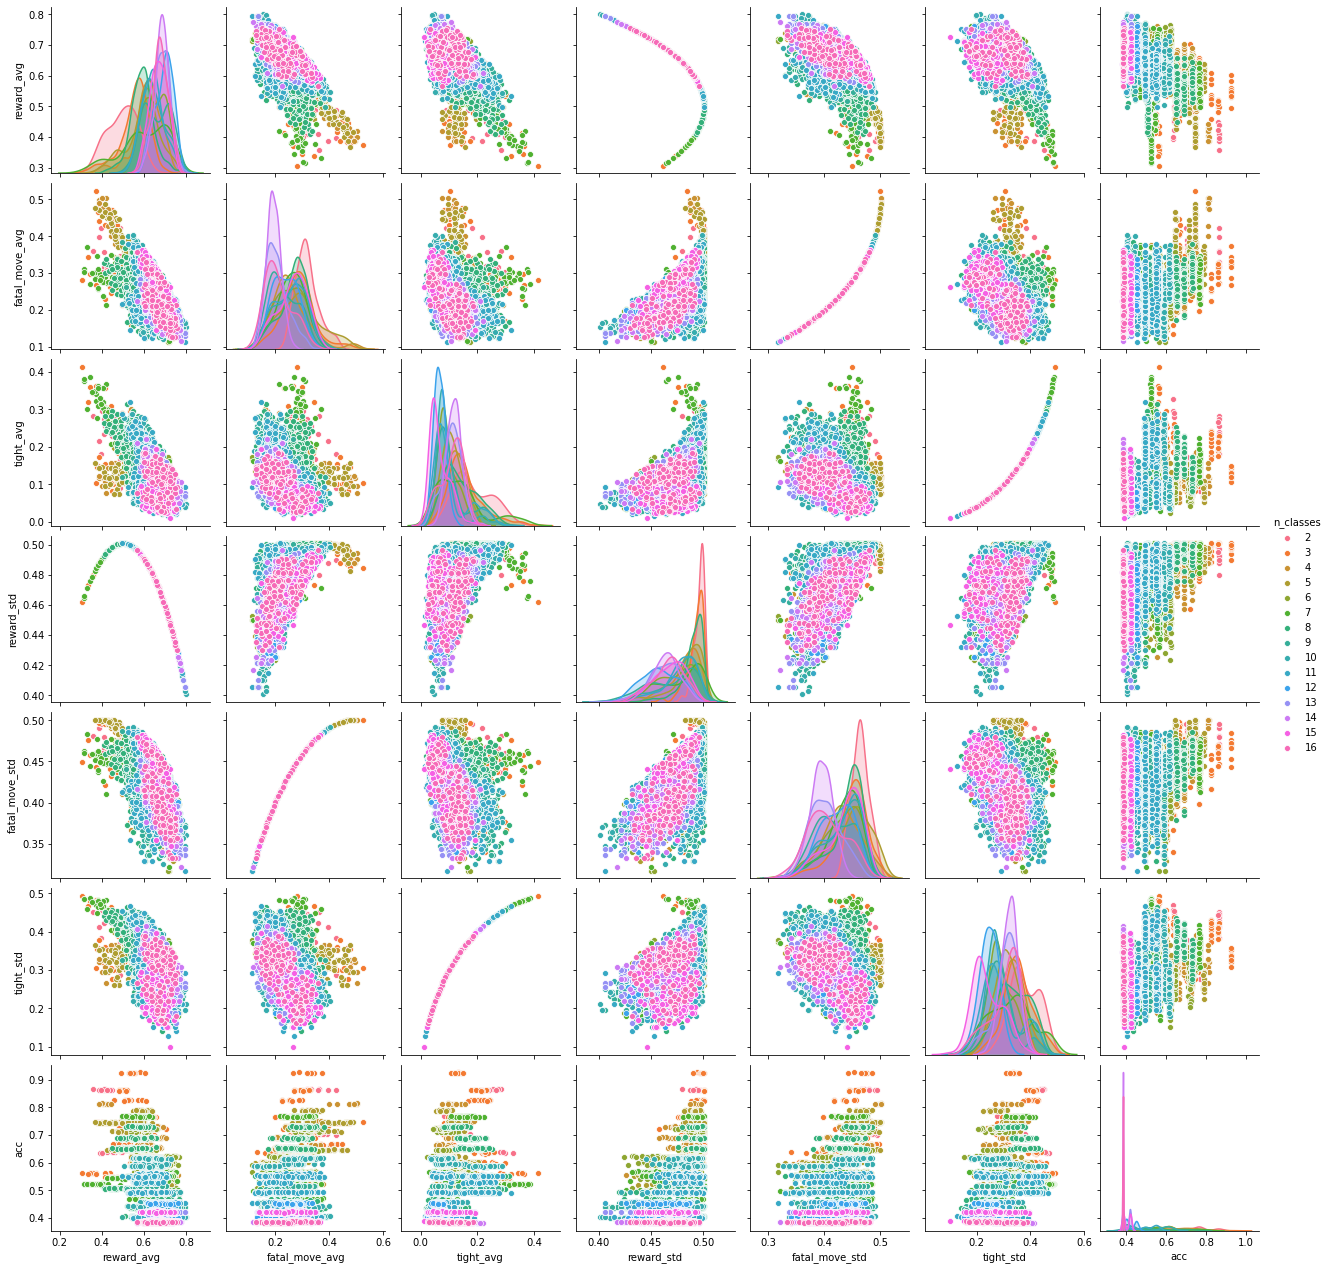

In [972]:
sns.pairplot(sys[1][sys[1].columns[1:10].tolist()].drop('seed', axis=1), hue='n_classes')

In [978]:
sys[1].columns[3:9]

Index(['reward_avg', 'fatal_move_avg', 'tight_avg', 'reward_std',
       'fatal_move_std', 'tight_std'],
      dtype='object')

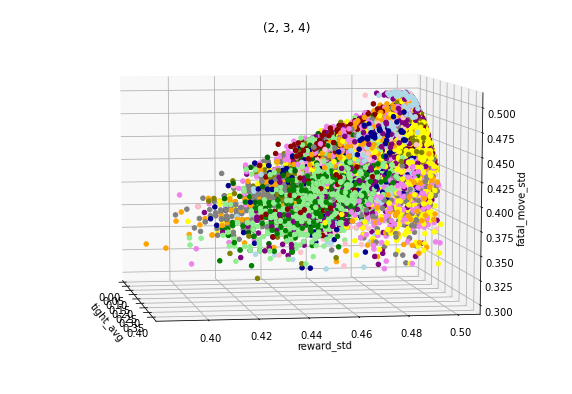

exit to stop exit


In [1012]:
iter_cols = sys[1].columns[3:9].tolist()
comb_lst = list(itertools.combinations([0,1,2,3,4,5], 3))

for comb in comb_lst:
    print(comb)
    for angle in range(1,360,10):

        fig = plt.figure(figsize=(10,7))
        ax0 = fig.add_subplot(1,1,1, projection='3d')

        ax0.scatter(sys[1][iter_cols[comb[0]]], sys[1][iter_cols[comb[1]]], sys[1][iter_cols[comb[2]]], c=[colors[label] for label in le().fit_transform(sys[1]['n_classes'])], alpha=1)
        ax0.view_init(8, angle)
        ax0.set(xlabel=iter_cols[comb[0]], ylabel=iter_cols[comb[1]], zlabel=iter_cols[comb[2]])
        ax0.set_title(str(comb))
        
        clear_output(wait=True)
        plt.show()

        plt.pause(0.001)
    time.sleep(0.3)
    a=input('exit to stop')
    if a=='exit': break


# Testing Top Model

In [1030]:
top_system_name = sys[1].groupby('name').mean()[['reward_avg']].sort_values(by='reward_avg', ascending=False).index[0]

In [1005]:
y_top_comb = y_comb[combs_names.index(sys[1].groupby('name').mean()['reward_avg'].sort_values(ascending=False).head(1).index[0])]

IndexError: list index out of range

In [830]:
top_model, acc, cls_acc = sample_model(x_2, y_top_comb, score=True)

# Old Stuff

In [14]:
mode=input('type "plot" to visualize the winning rate: ')
keep=input('Reuse last training set? ')
if keep=='no':
    memory = []
    scrs=[]
    num_eps_old = 1

num_eps = int(input('Type the number of turns: '))

print(len(memory))
time.sleep(2)


for ep in range(num_eps_old, num_eps_old + num_eps):
    
    if ep in range(num_eps_old, num_eps_old + num_eps ,int(num_eps/25)): print(ep)
    clear_output(wait=True)
         
    table = np.array([[0,0,0], [0,0,0], [0,0,0]])
    table_flat = table.ravel().tolist()

    ep_memory = []
    
    play_cnt = 0
    obs = []
    winner=0
    reward, reward2 = 0, 0
    action_history = []
    
    action1, action2 = -1, -1
    fatal_move1, fatal_move2 = 0, 0
    
    done=False
    while not done:

    #-------- Action 1 ------------
    
        action1 = int(np.random.sample()*10)
        while action1 in action_history+[9]:
            action1 = int(np.random.sample()*10)
        
        action_history.append(action1)       
        table_flat[action1]='o'
        play_cnt+=1
#        obs.extend([str(action1), str(action2)])        

           
        table = np.array(table_flat).reshape(3,3)
     
        for i in range(3):
            if (table[i].tolist()==['o', 'o', 'o']) or (table[:, i].tolist()==['o', 'o', 'o']) or (np.diag(table).tolist()==['o', 'o', 'o']) or (np.diag(table.T).tolist()==['o', 'o', 'o']):
                winner='o'
                done=True 
                reward=1
                fatal_move2=1
        
        
        #print(table)
        #print('winner', winner)
        #print('done', done)
        #print('reward', reward)
        #if input()=='exit': break
        #clear_output(wait=True)
                
        ep_memory.append([ep, play_cnt, (int(''.join([str(j) for j in action_history[:-1]])) if len(action_history[:-1])!=0 else 0), action1, reward, action2, reward2])
 
        if 0 not in table_flat or reward==1: break
        
    #----- Action 2 ---------

        action2 = int(np.random.sample()*10)
        while action2 in action_history+[9]:
            action2 = int(np.random.sample()*10)
        
        action_history.append(action2)
        table_flat[action2] = 'x' 
        play_cnt += 1

        table = np.array(table_flat).reshape(3,3)
        
        for i in range(3):
            if (table[i].tolist()==['x', 'x', 'x']) or (table[:, i].tolist()==['x', 'x', 'x']) or (np.diag(table).tolist()==['x','x','x']) or (np.diag(table.T).tolist()==['x', 'x', 'x']):
                winner = 'x'
                reward2 = 1
                fatal_move1 = 1
                done = True
        
        ep_memory.append([ep, play_cnt, (int(''.join([str(j) for j in action_history[:-1]])) if len(action_history[:-1])!=0 else 0), action1, reward, fatal_move1, action2, reward2, fatal_move2])
         
        if 0 not in table_flat or reward2==1: break

#------------ Total and Decay Rewards ------------
            
    for i, row in enumerate(ep_memory):
            
        ep_memory[i].append(reward)
        ep_memory[i].append(reward*i*2/(len(ep_memory)-1))
        ep_memory[i].append(reward2)
        ep_memory[i].append(reward2*i*2/(len(ep_memory)-1))
        
    memory.extend(ep_memory)
    
#------ Plotting -----
    
    if mode=='plot':
        scrs.append([ep, pd.DataFrame(memory, columns=['ep', 'round', 'obs', 'action', 'reward', 'action2', 'reward2', 'ttl_reward', 'decay_reward', 'ttl_reward2', 'decay_reward2']).groupby('ep').sum()['reward'].mean()])
        pd.DataFrame(scrs, columns=['ep', 'acc']).set_index('ep').plot()
        plt.show()
        plt.pause(0.001)
    
    
#---------- Dataframe Conversion ---------------

num_eps_old = num_eps_old + num_eps    

memory_df = pd.DataFrame(memory, columns=['ep', 'round', 'obs', 'action', 'reward', 'action2', 'reward2', 'ttl_reward', 'decay_reward', 'ttl_reward2', 'decay_reward2'])        

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
memory_df['fatal_move'] = pd.Series(memory_df['reward2'].iloc[1:].tolist()+[0], index=memory_df.index)

In [7]:
memory_df['fatal_move2'] = pd.Series(memory_df['reward'].iloc[1:].tolist()+[0], index=memory_df.index)

In [10]:
memory_df

ep  round      obs  action  reward  action2  reward2  \
0              1      1        0       6       0       -1        0   
1              1      2        6       6       0        3        0   
2              1      3       63       4       0        3        0   
3              1      4      634       4       0        8        0   
4              1      5     6348       5       0        8        0   
...          ...    ...      ...     ...     ...      ...      ...   
8910438  1140000      4      820       0       0        3        0   
8910439  1140000      5     8203       1       0        3        0   
8910440  1140000      6    82031       1       0        5        0   
8910441  1140000      7   820315       6       0        5        0   
8910442  1140000      8  8203156       6       0        4        1   

         ttl_reward  decay_reward  ttl_reward2  decay_reward2  fatal_move  \
0                 1      0.000000            0           0.00           0   
1                 1      0.222222            0           0.00           0   
2                 1      0.444444            0           0.00           0   
3                 1      0.666667            0           0.00           0   
4                 1      0.888889            0           0.00           0   
...             ...           ...          ...            ...         ...   
8910438           0      0.000000            1           0.75           0   
8910439           0      0.000000            1           1.00           0   
8910440           0      0.000000            1           1.25           0   
8910441           0      0.000000            1           1.50           1   
8910442           0      0.000000            1           1.75           0   

         fatal_move2  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
8910438            0  
8910439            0  
8910440            0  
8910441            0  
8910442            0  

[8910443 rows x 13 columns]

In [ ]:
iter_num = len(memory_df.ep.unique())
for ep in memory_df.ep.unique():
    
    memory_df[memory_df.ep==ep]['player'] = [0 if i//2==0 else 1 for i in range(len(memory_df[memory_df.ep==ep]))]
    
    print('iterations: ', str(ep)+'/'+str(iter_num), '   progress: ', str(ep/iter_num))
    clear_output(wait=True)

    #if ep in range(1,20000,250):
     #   a = input('wanna stop?')
      #  if a=='exit': break

iterations:  7034/1140000    progress:  0.0061701754385964916


In [6]:
eps = memory_df.ep.unique()

In [10]:
lengths = []
n_eps = len(eps)
for epi in eps:
    
    lengths.append(memory_df[memory_df.ep==epi].shape[0])
    
    clear_output(wait=True)
    print('iterations: ', str(epi)+'/'+str(n_eps), '   progress: ', str(epi/n_eps))
    
    if epi in range(1,10000,200): 
        if input()=='exit': break

iterations:  401/1140000    progress:  0.0003517543859649123


KeyboardInterrupt: Interrupted by user

In [ ]:
memory_df

### Saving and Loading Data

In [15]:
#memory_df.to_csv('jogo_da_velha_ext2.csv', index=False)

In [4]:
memory_copy = pd.read_csv('jogo_da_velha.csv')

In [4]:
memory_ext_copy = pd.read_csv('jogo_da_velha_ext2.csv')

memory_df = memory_ext_copy.copy()

# Tree Classification Model Training: First Player

In [38]:
a = memory_df['reward']
b = memory_df['ttl_reward']
c =  memory_df['decay_reward']
d = memory_df['reward2']
e = memory_df['ttl_reward2']
f =  memory_df['decay_reward2']

In [39]:
    
    y = (a  + (b * c) - d - (e * f)).sample(100000)
    x = memory_df[['round', 'obs', 'action', 'action2']].loc[y.index]
    y = pd.Series(le().fit_transform(y))

In [58]:
    #  win_rate = 0.9724

    y = a  + c/2
    x = memory_df[['round', 'obs', 'action', 'action2']]
    y = pd.Series(le().fit_transform(y))
    
    name='reward+decay'

In [59]:
    msk_new = np.random.rand(len(y))<0.8
    msk = msk_new
    x_train, x_test, y_train, y_test = x[msk], x[~msk], y[msk], y[~msk]

    #et = etr(n_estimators=50)
    #rf = rfr(n_estimators=50)
    #bg = BaggingRegressor(n_estimators=50)

    et = etc(verbose=1, n_jobs=-1, n_estimators=1)

    #et.set_params(n_estimators=10)
    et.fit(x_train,y_train)

    #cm(y_test, et.predict(x_test)), print(cr(y_test, et.predict(x_test)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.3s finished


ExtraTreesClassifier(n_estimators=1, n_jobs=-1, verbose=1)

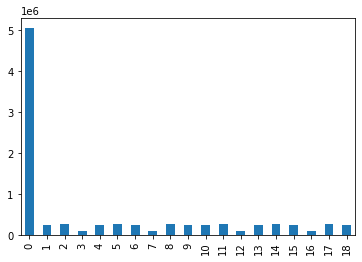

In [60]:
y.value_counts().loc[sorted(y.value_counts().index.values)].plot.bar()

<BarContainer object of 4 artists>

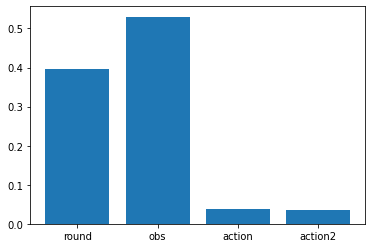

In [61]:
plt.bar(x.columns, et.feature_importances_)

# Scoring First Player: Avg and Std winning rate when playing multiple times

In [40]:
#stats_dict = dict()

In [41]:
et.set_params(verbose=0)

num_eps_old = 1
num_eps = int(input('Number of mathes per iteration: ')) + num_eps_old
times = int(input('Number of iterations: '))
mode = input('Type "plot" to visualize victory proportion in real time: ')
keep = input('Want to reuse the set? ')
if input('Type "exit" to leave')=='exit': pd.levantaoerro
    
if keep=='no': stats = []
for time in range(times):

    memory1 = []
    num_eps_old = 1

    scrs=[]

    num_eps = num_eps
    for ep in range(num_eps_old, num_eps):

        clear_output(wait=True)
        if ep in range(num_eps_old, num_eps, int(num_eps/40)+1): 
            print('iteration: ', str(time)+'/'+str(times), ' -  games: ', str(ep)+'/'+str(num_eps))

        table = np.array([[0,0,0], [0,0,0], [0,0,0]])
        table_flat = table.ravel().tolist()

        ep_memory = []

        play_cnt = 0
        obs = []
        winner=0
        reward=0
        action_history = []
        action1, action2 = 0, -1

        done=False
        while not done:

        #-------- Action 1 ------------

            play_cnt+=1
            #obs = le_obj.transform(np.array([(int(''.join([str(j) for j in action_history[1:][:-1]])) if len(action_history)!=1 else 0)]))[0]   
            #obs = (int(''.join([str(j) for j in action_history[1:][:-1]])) if len(action_history)!=1 else 0)   
            obs = (int(''.join([str(j) for j in action_history])) if len(action_history)!=0 else 0)   
            pred_in = [[play_cnt, obs, i, action2] for i in range(9)]       

        #------

            action1 = np.argmax(et.predict(pred_in))

            choice_cnt=0
            while action1 in action_history+[9]:
                action1 = pd.Series(et.predict(pred_in)).sort_values(ascending=False).index[choice_cnt]
                choice_cnt+=1

            action_history.append(action1)       
            table_flat[action1]='o'

        #-------------------------------------------------------

            #action1 = int(np.random.sample()*10)
            #while action1 in action_history+[9]:
             #   action1 = int(np.random.sample()*10)

            #action_history.append(action1)
            #table_flat[action1]='o' 
            #play_cnt+=1


        #---------------- Checking victory -------------------------

            table = np.array(table_flat).reshape(3,3)

            for i in range(3):
                if (table[i].tolist()==['o', 'o', 'o']) or (table[:, i].tolist()==['o', 'o', 'o']) or (np.diag(table).tolist()==['o', 'o', 'o']) or (np.diag(table.T).tolist()==['o', 'o', 'o']):
                    winner='o'
                    done=True 
                    reward=1


            #print(table)
            #print('winner', winner)
            #print('done', done)
            #print('reward', reward)
            #if input()=='exit': break
            #clear_output(wait=True)


    #        ep_memory.append([ep, play_cnt, obs, action1, reward])
            ep_memory.append([ep, reward])

            if 0 not in table_flat or reward==1: break

        #------------------------------ Action 2 ---------------------------------------


            #print(table)
            #action2 = int(input())
            #if action2=='exit': break

            action2 = int(np.random.sample()*10)
            while action2 in action_history+[9]:
                action2 = int(np.random.sample()*10)

            action_history.append(action2)
            table_flat[action2]='x' 
            play_cnt+=1

        #---------------------------------------------------------------------------

            #play_cnt+=1
            #obs = le_obj.transform(np.array([(int(''.join([str(j) for j in action_history[1:][:-1]])) if len(action_history)!=1 else 0)]))[0]   
            #obs = (int(''.join([str(j) for j in action_history])) if len(action_history)!=0 else 0)   
            #pred_in = [[play_cnt, obs, i] for i in range(9)]       

            #action2 = np.argmax(et.predict(pred_in))

            #choice_cnt=0
            #while action2 in action_history:
             #   action2 = pd.Series(et.predict(pred_in)).sort_values(ascending=False).index[choice_cnt]
              #  choice_cnt+=1
            #if action1 != np.argmax(et.predict(pred_in)): random_cnt+=1

            #action_history.append(action2)       
            #table_flat[action2]='x'

        #---------------------------------------------------------------- Checking victory condition --------------

            table = np.array(table_flat).reshape(3,3)

            for i in range(3):
                if (table[i].tolist()==['x', 'x', 'x']) or (table[:, i].tolist()==['x', 'x', 'x']) or (np.diag(table).tolist()==['x','x','x']) or (np.diag(table.T).tolist()==['x', 'x', 'x']):
                    winner='x'
                    done=True

            if 0 not in table_flat: break

    #------------ Total and Decay Rewards ------------

        #for i, row in enumerate(ep_memory):

         #   ep_memory[i].append(reward)
          #  ep_memory[i].append(reward*i/len(ep_memory))

        memory1.extend(ep_memory)

    #----- Plotting ----------

        if mode=='plot':

            scrs.append([ep, pd.DataFrame(memory1, columns=['ep', 'reward']).groupby('ep').sum()['reward'].mean()])
            pd.DataFrame(scrs, columns=['ep', 'acc']).set_index('ep').plot()
            plt.grid()
            plt.show()
            plt.pause(0.001)

    #---------- Dataframe Conversion ---------------

    num_eps_old = ep+1

    #memory1_df = pd.DataFrame(memory1, columns=['ep', 'round', 'obs', 'action', 'reward', 'ttl_reward', 'decay_reward'])     
    memory1_df = pd.DataFrame(memory1, columns=['ep', 'reward'])     
    
    u = memory1_df.groupby('ep').sum().mean()[0] * len(memory1_df.groupby('ep').sum())
    p = memory1_df.groupby('ep').sum().mean()[0]
    n = len(memory1_df.groupby('ep').sum())
    s = memory1_df.groupby('ep').sum().std()[0]
    stats.append([p, s, n, u])
    
    #print(times)
    
stats_df = pd.DataFrame(stats, columns=['p', 's', 'n', 'u'])
stats_dict[name] = stats_df

iteration:  14/15  -  games:  989/1001


In [53]:
a = memory_df['reward']
b = memory_df['ttl_reward']
c =  memory_df['decay_reward']
d = memory_df['reward2']
e = memory_df['ttl_reward2']
f =  memory_df['decay_reward2']

In [54]:
    
    y = a  + (b * c) - d - (e * f)
    x = memory_df[['round', 'obs', 'action', 'action2']]
    y = pd.Series(le().fit_transform(y))

In [58]:
    #  win_rate = 0.9724

    y = a  + c/2
    x = memory_df[['round', 'obs', 'action', 'action2']]
    y = pd.Series(le().fit_transform(y))
    
    name='reward+decay'

In [59]:
    msk_new = np.random.rand(len(y))<0.8
    msk = msk_new
    x_train, x_test, y_train, y_test = x[msk], x[~msk], y[msk], y[~msk]

    #et = etr(n_estimators=50)
    #rf = rfr(n_estimators=50)
    #bg = BaggingRegressor(n_estimators=50)

    et = etc(verbose=1, n_jobs=-1, n_estimators=1)

    #et.set_params(n_estimators=10)
    et.fit(x_train,y_train)

    #cm(y_test, et.predict(x_test)), print(cr(y_test, et.predict(x_test)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.3s finished


ExtraTreesClassifier(n_estimators=1, n_jobs=-1, verbose=1)

In [62]:
stats_df, stats_dict = play_model(et, stats_dict, name, times=10)

iteration:  9/10  -  games:  989/1001


In [81]:
stats_df.describe()

p          s       n           u
count  10.000000  10.000000    10.0   10.000000
mean    0.905300   0.292763  1000.0  905.300000
std     0.006567   0.008733     0.0    6.566751
min     0.888000   0.283437  1000.0  888.000000
25%     0.905000   0.288459  1000.0  905.000000
50%     0.906500   0.291276  1000.0  906.500000
75%     0.908500   0.293362  1000.0  908.500000
max     0.912000   0.315524  1000.0  912.000000

In [88]:
bin_lst = []
for i in range(1,500):
    
    bin_sample = np.random.binomial(1000, 0.9053, i)
    bin_lst.append([i, np.std(bin_sample)])
    

In [90]:
bin_df = pd.DataFrame(bin_lst, columns=['n_samples', 'std'])

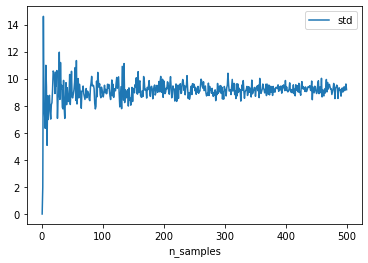

In [92]:
bin_df.set_index('n_samples').plot()

In [65]:
stats_dict.keys()

dict_keys(['reward+decay'])

In [52]:
def play_model(et, stats_dict, name, num_eps=1000, times=5, mode='simple', stats=None, keep='no'):

    et.set_params(verbose=0)

    num_eps_old = 1
    num_eps = num_eps + num_eps_old
    times = times
    mode = mode
    keep = keep
    
    if keep=='no': stats = []
    for time in range(times):

        memory1 = []
        num_eps_old = 1

        scrs=[]

        num_eps = num_eps
        for ep in range(num_eps_old, num_eps):

            clear_output(wait=True)
            if ep in range(num_eps_old, num_eps, int(num_eps/40)+1): 
                print('iteration: ', str(time)+'/'+str(times), ' -  games: ', str(ep)+'/'+str(num_eps))

            table = np.array([[0,0,0], [0,0,0], [0,0,0]])
            table_flat = table.ravel().tolist()

            ep_memory = []

            play_cnt = 0
            obs = []
            winner=0
            reward=0
            action_history = []
            action1, action2 = 0, -1

            done=False
            while not done:

            #-------- Action 1 ------------

                play_cnt+=1
                #obs = le_obj.transform(np.array([(int(''.join([str(j) for j in action_history[1:][:-1]])) if len(action_history)!=1 else 0)]))[0]   
                #obs = (int(''.join([str(j) for j in action_history[1:][:-1]])) if len(action_history)!=1 else 0)   
                obs = (int(''.join([str(j) for j in action_history])) if len(action_history)!=0 else 0)   
                pred_in = [[play_cnt, obs, i, action2] for i in range(9)]       

            #------

                action1 = np.argmax(et.predict(pred_in))

                choice_cnt=0
                while action1 in action_history+[9]:
                    action1 = pd.Series(et.predict(pred_in)).sort_values(ascending=False).index[choice_cnt]
                    choice_cnt+=1

                action_history.append(action1)       
                table_flat[action1]='o'

            #-------------------------------------------------------

                #action1 = int(np.random.sample()*10)
                #while action1 in action_history+[9]:
                 #   action1 = int(np.random.sample()*10)

                #action_history.append(action1)
                #table_flat[action1]='o' 
                #play_cnt+=1


            #---------------- Checking victory -------------------------

                table = np.array(table_flat).reshape(3,3)

                for i in range(3):
                    if (table[i].tolist()==['o', 'o', 'o']) or (table[:, i].tolist()==['o', 'o', 'o']) or (np.diag(table).tolist()==['o', 'o', 'o']) or (np.diag(table.T).tolist()==['o', 'o', 'o']):
                        winner='o'
                        done=True 
                        reward=1


                #print(table)
                #print('winner', winner)
                #print('done', done)
                #print('reward', reward)
                #if input()=='exit': break
                #clear_output(wait=True)


        #        ep_memory.append([ep, play_cnt, obs, action1, reward])
                ep_memory.append([ep, reward])

                if 0 not in table_flat or reward==1: break

            #------------------------------ Action 2 ---------------------------------------


                #print(table)
                #action2 = int(input())
                #if action2=='exit': break

                action2 = int(np.random.sample()*10)
                while action2 in action_history+[9]:
                    action2 = int(np.random.sample()*10)

                action_history.append(action2)
                table_flat[action2]='x' 
                play_cnt+=1

            #---------------------------------------------------------------------------

                #play_cnt+=1
                #obs = le_obj.transform(np.array([(int(''.join([str(j) for j in action_history[1:][:-1]])) if len(action_history)!=1 else 0)]))[0]   
                #obs = (int(''.join([str(j) for j in action_history])) if len(action_history)!=0 else 0)   
                #pred_in = [[play_cnt, obs, i] for i in range(9)]       

                #action2 = np.argmax(et.predict(pred_in))

                #choice_cnt=0
                #while action2 in action_history:
                 #   action2 = pd.Series(et.predict(pred_in)).sort_values(ascending=False).index[choice_cnt]
                  #  choice_cnt+=1
                #if action1 != np.argmax(et.predict(pred_in)): random_cnt+=1

                #action_history.append(action2)       
                #table_flat[action2]='x'

            #---------------------------------------------------------------- Checking victory condition --------------

                table = np.array(table_flat).reshape(3,3)

                for i in range(3):
                    if (table[i].tolist()==['x', 'x', 'x']) or (table[:, i].tolist()==['x', 'x', 'x']) or (np.diag(table).tolist()==['x','x','x']) or (np.diag(table.T).tolist()==['x', 'x', 'x']):
                        winner='x'
                        done=True

                if 0 not in table_flat: break

        #------------ Total and Decay Rewards ------------

            #for i, row in enumerate(ep_memory):

             #   ep_memory[i].append(reward)
              #  ep_memory[i].append(reward*i/len(ep_memory))

            memory1.extend(ep_memory)

        #----- Plotting ----------

            if mode=='plot':

                scrs.append([ep, pd.DataFrame(memory1, columns=['ep', 'reward']).groupby('ep').sum()['reward'].mean()])
                pd.DataFrame(scrs, columns=['ep', 'acc']).set_index('ep').plot()
                plt.grid()
                plt.show()
                plt.pause(0.001)

        #---------- Dataframe Conversion ---------------

        num_eps_old = ep+1

        #memory1_df = pd.DataFrame(memory1, columns=['ep', 'round', 'obs', 'action', 'reward', 'ttl_reward', 'decay_reward'])     
        memory1_df = pd.DataFrame(memory1, columns=['ep', 'reward'])     

        u = memory1_df.groupby('ep').sum().mean()[0] * len(memory1_df.groupby('ep').sum())
        p = memory1_df.groupby('ep').sum().mean()[0]
        n = len(memory1_df.groupby('ep').sum())
        s = memory1_df.groupby('ep').sum().std()[0]
        stats.append([p, s, n, u])

        #print(times)

    stats_df = pd.DataFrame(stats, columns=['p', 's', 'n', 'u'])
    stats_dict[name] = stats_df
    
    if keep=='no':
        return  stats_df, stats_dict
    else:
        return stats, stats_df, stats_dict

In [51]:
stats_dict.keys()

dict_keys(['reward+decay'])

## Saving/Loading

In [46]:
#stats_df.to_csv('variancia_modelo_aleatório.csv', index=False)

In [6]:
stats_df = pd.read_csv('variancia_modelo_aleatório.csv')

## Plotting Result

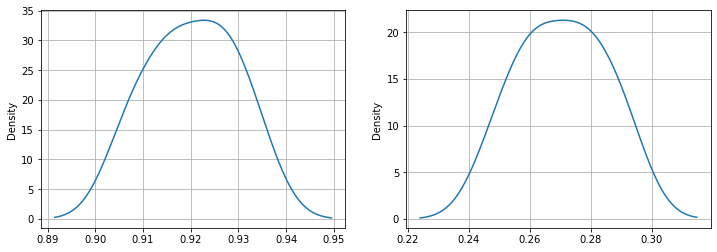

In [42]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

stats_df.iloc[:, 0].plot.kde(ax=axs[0])
stats_df.iloc[:, 1].plot.kde(ax=axs[1])

axs[0].grid()
axs[1].grid()

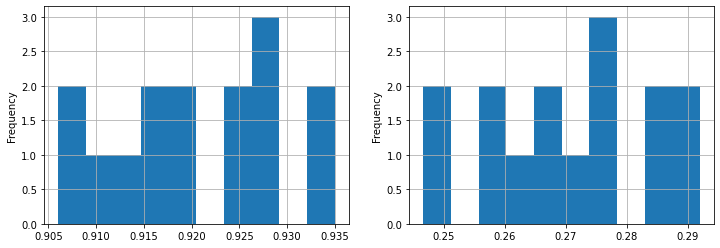

In [43]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

stats_df.iloc[:, 0].plot.hist(ax=axs[0])
stats_df.iloc[:, 1].plot.hist(ax=axs[1])

axs[0].grid()
axs[1].grid()

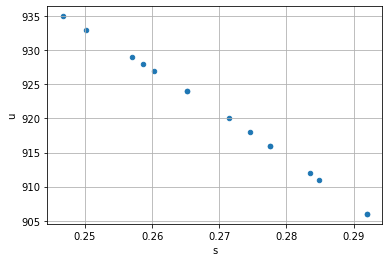

In [44]:
#fig, axs = plt.subplots(1,1, figsize=(6,5))

stats_df.plot.scatter(x='s', y='u')
plt.grid()

In [45]:
stats_df.describe()

p          s       n           u
count  15.000000  15.000000    15.0   15.000000
mean    0.920333   0.270410  1000.0  920.333333
std     0.009225   0.014349     0.0    9.224708
min     0.906000   0.246649  1000.0  906.000000
25%     0.914000   0.259442  1000.0  914.000000
50%     0.920000   0.271429  1000.0  920.000000
75%     0.927500   0.280482  1000.0  927.500000
max     0.935000   0.291975  1000.0  935.000000

# Evaluating Across Random Train Samples

In [72]:
y = memory_df['reward']  + (memory_df['ttl_reward'] * memory_df['decay_reward']) - memory_df['reward2'] - (memory_df['ttl_reward2'] * memory_df['decay_reward2'])
x = memory_df[['round', 'obs', 'action', 'action2']]
y = pd.Series(le().fit_transform(y))

num_eps_old = 1
num_eps = int(input('Number of mathes per iteration: ')) + num_eps_old
mode = input('Type "plot" to visualize victory proportion in real time: ')
times = int(input('Insert number of iterations: '))
keep = input('Want to reuse the set? ')
if input('Type "exit" to leave')=='exit': pd.levantaoerro
ep=0

if keep=='no': stats = []
for time in range(times):
    
    clear_output(wait=True)
    print('iteration: ', str(time)+'/'+str(times), ' -  games: ', str(ep)+'/'+str(num_eps), ' -  Training New Random Tree Model...')
    
    msk_new = np.random.rand(len(y))<0.8
    msk = msk_new
    x_train, x_test, y_train, y_test = x[msk], x[~msk], y[msk], y[~msk]

    #et = etr(n_estimators=50)
    #rf = rfr(n_estimators=50)
    #bg = BaggingRegressor(n_estimators=50)

    et = etc(verbose=0, n_jobs=-1, n_estimators=1)
    #et.set_params(n_estimators=10)
    et.fit(x_train,y_train)
    acc = acc_scr(y_test, et.predict(x_test))
    
#---------   Jogo da Velha ---------------------
    
    memory1 = []
    num_eps_old = 1

    scrs=[]

    num_eps = num_eps
    for ep in range(num_eps_old, num_eps):

        clear_output(wait=True)
        if ep in range(num_eps_old, num_eps, int(num_eps/40)+1): print('iteration: ', str(time)+'/'+str(times), ' -  games: ', str(ep)+'/'+str(num_eps), ' -  Testing Model...')

        table = np.array([[0,0,0], [0,0,0], [0,0,0]])
        table_flat = table.ravel().tolist()

        ep_memory = []

        play_cnt = 0
        obs = []
        winner=0
        reward=0
        action_history = []
        action1, action2 = 0, -1

        done=False
        while not done:

        #-------- Action 1 ------------

            play_cnt+=1
            #obs = le_obj.transform(np.array([(int(''.join([str(j) for j in action_history[1:][:-1]])) if len(action_history)!=1 else 0)]))[0]   
            #obs = (int(''.join([str(j) for j in action_history[1:][:-1]])) if len(action_history)!=1 else 0)   
            obs = (int(''.join([str(j) for j in action_history])) if len(action_history)!=0 else 0)   
            pred_in = [[play_cnt, obs, i, action2] for i in range(9)]       

        #------

            action1 = np.argmax(et.predict(pred_in))

            choice_cnt=0
            while action1 in action_history+[9]:
                action1 = pd.Series(et.predict(pred_in)).sort_values(ascending=False).index[choice_cnt]
                choice_cnt+=1

            action_history.append(action1)       
            table_flat[action1]='o'

        #-------------------------------------------------------

            #action1 = int(np.random.sample()*10)
            #while action1 in action_history+[9]:
             #   action1 = int(np.random.sample()*10)

            #action_history.append(action1)
            #table_flat[action1]='o' 
            #play_cnt+=1


        #---------------- Checking victory -------------------------

            table = np.array(table_flat).reshape(3,3)

            for i in range(3):
                if (table[i].tolist()==['o', 'o', 'o']) or (table[:, i].tolist()==['o', 'o', 'o']) or (np.diag(table).tolist()==['o', 'o', 'o']) or (np.diag(table.T).tolist()==['o', 'o', 'o']):
                    winner='o'
                    done=True 
                    reward=1


            #print(table)
            #print('winner', winner)
            #print('done', done)
            #print('reward', reward)
            #if input()=='exit': break
            #clear_output(wait=True)


    #        ep_memory.append([ep, play_cnt, obs, action1, reward])
            ep_memory.append([ep, reward])

            if 0 not in table_flat or reward==1: break

        #------------------------------ Action 2 ---------------------------------------


            #print(table)
            #action2 = int(input())
            #if action2=='exit': break

            action2 = int(np.random.sample()*10)
            while action2 in action_history+[9]:
                action2 = int(np.random.sample()*10)

            action_history.append(action2)
            table_flat[action2]='x' 
            play_cnt+=1

        #---------------------------------------------------------------------------

            #play_cnt+=1
            #obs = le_obj.transform(np.array([(int(''.join([str(j) for j in action_history[1:][:-1]])) if len(action_history)!=1 else 0)]))[0]   
            #obs = (int(''.join([str(j) for j in action_history])) if len(action_history)!=0 else 0)   
            #pred_in = [[play_cnt, obs, i] for i in range(9)]       

            #action2 = np.argmax(et.predict(pred_in))

            #choice_cnt=0
            #while action2 in action_history:
             #   action2 = pd.Series(et.predict(pred_in)).sort_values(ascending=False).index[choice_cnt]
              #  choice_cnt+=1
            #if action1 != np.argmax(et.predict(pred_in)): random_cnt+=1

            #action_history.append(action2)       
            #table_flat[action2]='x'

        #---------------------------------------------------------------- Checking victory condition --------------

            table = np.array(table_flat).reshape(3,3)

            for i in range(3):
                if (table[i].tolist()==['x', 'x', 'x']) or (table[:, i].tolist()==['x', 'x', 'x']) or (np.diag(table).tolist()==['x','x','x']) or (np.diag(table.T).tolist()==['x', 'x', 'x']):
                    winner='x'
                    done=True

            if 0 not in table_flat: break

    #------------ Total and Decay Rewards ------------

        #for i, row in enumerate(ep_memory):

         #   ep_memory[i].append(reward)
          #  ep_memory[i].append(reward*i/len(ep_memory))

        memory1.extend(ep_memory)

    #----- Plotting ----------

        if mode=='plot':

            scrs.append([ep, pd.DataFrame(memory1, columns=['ep', 'reward']).groupby('ep').sum()['reward'].mean()])
            pd.DataFrame(scrs, columns=['ep', 'acc']).set_index('ep').plot()
            plt.grid()
            plt.show()
            plt.pause(0.001)

    #---------- Dataframe Conversion ---------------

    num_eps_old = ep+1

    #memory1_df = pd.DataFrame(memory1, columns=['ep', 'round', 'obs', 'action', 'reward', 'ttl_reward', 'decay_reward'])     
    memory1_df = pd.DataFrame(memory1, columns=['ep', 'reward'])     
    
    u = memory1_df.groupby('ep').sum().mean()[0] * len(memory1_df.groupby('ep').sum())
    p = memory1_df.groupby('ep').sum().mean()[0]
    n = len(memory1_df.groupby('ep').sum())
    s = memory1_df.groupby('ep').sum().std()[0]
    stats.append([p, s, n, u, acc])
    
    #print(times)
    
stats_df = pd.DataFrame(stats, columns=['p', 's', 'n', 'u', 'acc'])
print('Done!')

## Saving and Loading Random Splits Evaluation

In [112]:
#stats_df.to_csv('stats_random_splits_jogo_da_velha.csv', index=False)

In [46]:
stats_df = pd.read_csv('stats_random_splits_jogo_da_velha.csv')

## Plotting Result

In [47]:
stats_df.describe()

p          s       n           u        acc
count  23.000000  23.000000    23.0   23.000000  23.000000
mean    0.958870   0.197777  1000.0  958.869565   0.579806
std     0.007381   0.018008     0.0    7.381207   0.000286
min     0.947000   0.146757  1000.0  947.000000   0.579202
25%     0.955000   0.192492  1000.0  955.000000   0.579583
50%     0.958000   0.200690  1000.0  958.000000   0.579808
75%     0.961500   0.207408  1000.0  961.500000   0.579974
max     0.978000   0.224146  1000.0  978.000000   0.580277

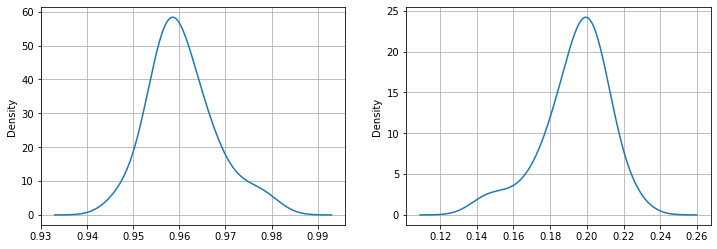

In [61]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

stats_df.iloc[:, 0].plot.kde(ax=axs[0])
stats_df.iloc[:, 1].plot.kde(ax=axs[1])

axs[0].grid()
axs[1].grid()

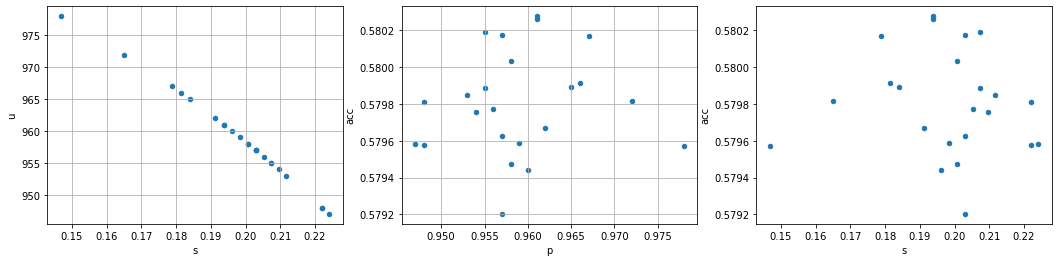

In [51]:
fig, axs = plt.subplots(1,3, figsize=(18,4))

stats_df.plot.scatter(x='s', y='u', ax=axs[0])
stats_df.plot.scatter('p', 'acc', ax=axs[1])
stats_df.plot.scatter('s', 'acc', ax=axs[2])

axs[0].grid()
axs[1].grid()

plt.show()

# Alternative Sampling Method

In [13]:
y = memory_df['reward']  + (memory_df['ttl_reward'] * memory_df['decay_reward']) - memory_df['reward2'] - (memory_df['ttl_reward2'] * memory_df['decay_reward2'])
x = memory_df[['round', 'obs', 'action', 'action2']]

In [27]:
pd.Series(le().fit_transform(y), index=y.index).value_counts().sort_values().index[0]

1

In [100]:
y.value_counts()

 0.000000    3303744
-1.000000     274235
 0.571429     260523
 0.857143     260523
 1.428571     260523
 2.714286     260523
 0.285714     260523
 1.142857     260523
 0.888889     239631
 1.111111     239631
 1.333333     239631
 0.666667     239631
 2.777778     239631
 1.555556     239631
 0.444444     239631
 0.222222     239631
-1.500000     187383
-0.250000     187383
-0.500000     187383
-0.750000     187383
-1.250000     187383
-2.750000     187383
 0.800000      95143
 0.400000      95143
 1.200000      95143
 2.600000      95143
-0.666667      86852
-1.333333      86852
-0.333333      86852
-2.666667      86852
dtype: int64

In [143]:
np.arange(0,10,3)

array([0, 3, 6, 9])

In [53]:

num_eps_old = 1

num_eps = int(input('Number of mathes per iteration: ')) + num_eps_old
test_set = input('Choose test values ("1" for equally spaced, "2" for quadratically spaced): ')
mode = input('Type "plot" to visualize victory proportion in real time: ')
keep = input('Want to reuse the set? ')
if input('Type "exit" to leave')=='exit': pd.levantaoerro
ep=0

sizes = (list(np.arange(3.3e6, 0.5e6, -int((3.3e6-0.5e6)/15))) if test_set != '2' else [3300000/(1.175**i) for i in range(1,30)])

y = memory_df['reward']  + (memory_df['ttl_reward'] * memory_df['decay_reward']) - memory_df['reward2'] - (memory_df['ttl_reward2'] * memory_df['decay_reward2'])
x = memory_df[['round', 'obs', 'action', 'action2']]

if keep=='no': stats = []
for sample_size in sizes:
    
    yfi = pd.concat([y[y==y.value_counts().sort_values().index[0]].sample(int(sample_size)), y[y!=y.value_counts().sort_values().index[0]]], axis=0)
    xf = x.loc[yfi.index]
    yf = pd.Series(le().fit_transform(yfi))
    
    clear_output(wait=True)
    print('iteration: ', str(sizes.index(sample_size)+1)+'/'+str(len(sizes)), ' -  games: ', str(0)+'/'+str(num_eps), ' -  Training Random Extra Trees Model...')
    
    msk_new = np.random.rand(len(yf))<0.8
    msk = msk_new
    x_train, x_test, y_train, y_test = xf[msk], xf[~msk], yf[msk], yf[~msk]

    #et = etr(n_estimators=50)
    #rf = rfr(n_estimators=50)
    #bg = BaggingRegressor(n_estimators=50)

    et = etc(verbose=1, n_jobs=-1, n_estimators=1)
    #et.set_params(n_estimators=10)
    et.fit(x_train,y_train)
    acc = acc_scr(y_test, et.predict(x_test))
    
#---------   Jogo da Velha ---------------------
    
    memory1 = []
    num_eps_old = 1

    scrs=[]

    num_eps = num_eps
    for ep in range(num_eps_old, num_eps):

        clear_output(wait=True)
        if ep in range(num_eps_old, num_eps, int(num_eps/40)+1): print('iteration: ', str(sizes.index(sample_size)+1)+'/'+str(len(sizes)), ' -  games: ', str(ep+1)+'/'+str(num_eps), ' -  Testing Model...')

        table = np.array([[0,0,0], [0,0,0], [0,0,0]])
        table_flat = table.ravel().tolist()

        ep_memory = []

        play_cnt = 0
        obs = []
        winner=0
        reward=0
        action_history = []
        action1, action2 = 0, -1

        done=False
        while not done:

        #-------- Action 1 ------------

            play_cnt+=1
            #obs = le_obj.transform(np.array([(int(''.join([str(j) for j in action_history[1:][:-1]])) if len(action_history)!=1 else 0)]))[0]   
            #obs = (int(''.join([str(j) for j in action_history[1:][:-1]])) if len(action_history)!=1 else 0)   
            obs = (int(''.join([str(j) for j in action_history])) if len(action_history)!=0 else 0)   
            pred_in = [[play_cnt, obs, i, action2] for i in range(9)]       

        #------

            action1 = np.argmax(et.predict(pred_in))

            choice_cnt=0
            while action1 in action_history+[9]:
                action1 = pd.Series(et.predict(pred_in)).sort_values(ascending=False).index[choice_cnt]
                choice_cnt+=1

            action_history.append(action1)       
            table_flat[action1]='o'

        #-------------------------------------------------------

            #action1 = int(np.random.sample()*10)
            #while action1 in action_history+[9]:
             #   action1 = int(np.random.sample()*10)

            #action_history.append(action1)
            #table_flat[action1]='o' 
            #play_cnt+=1

        #---------------- Checking victory -------------------------

            table = np.array(table_flat).reshape(3,3)

            for i in range(3):
                if (table[i].tolist()==['o', 'o', 'o']) or (table[:, i].tolist()==['o', 'o', 'o']) or (np.diag(table).tolist()==['o', 'o', 'o']) or (np.diag(table.T).tolist()==['o', 'o', 'o']):
                    winner='o'
                    done=True 
                    reward=1

            #print(table)
            #print('winner', winner)
            #print('done', done)
            #print('reward', reward)
            #if input()=='exit': break
            #clear_output(wait=True)

    #        ep_memory.append([ep, play_cnt, obs, action1, reward])
            ep_memory.append([ep, reward])

            if 0 not in table_flat or reward==1: break

        #------------------------------ Action 2 ---------------------------------------

            #print(table)
            #action2 = int(input())
            #if action2=='exit': break

            action2 = int(np.random.sample()*10)
            while action2 in action_history+[9]:
                action2 = int(np.random.sample()*10)

            action_history.append(action2)
            table_flat[action2]='x' 
            play_cnt+=1

        #---------------------------------------------------------------------------

            #play_cnt+=1
            #obs = le_obj.transform(np.array([(int(''.join([str(j) for j in action_history[1:][:-1]])) if len(action_history)!=1 else 0)]))[0]   
            #obs = (int(''.join([str(j) for j in action_history])) if len(action_history)!=0 else 0)   
            #pred_in = [[play_cnt, obs, i] for i in range(9)]       

            #action2 = np.argmax(et.predict(pred_in))

            #choice_cnt=0
            #while action2 in action_history:
             #   action2 = pd.Series(et.predict(pred_in)).sort_values(ascending=False).index[choice_cnt]
              #  choice_cnt+=1
            #if action1 != np.argmax(et.predict(pred_in)): random_cnt+=1

            #action_history.append(action2)       
            #table_flat[action2]='x'

        #---------------------------------------------------------------- Checking victory condition --------------

            table = np.array(table_flat).reshape(3,3)

            for i in range(3):
                if (table[i].tolist()==['x', 'x', 'x']) or (table[:, i].tolist()==['x', 'x', 'x']) or (np.diag(table).tolist()==['x','x','x']) or (np.diag(table.T).tolist()==['x', 'x', 'x']):
                    winner='x'
                    done=True

            if 0 not in table_flat: break

    #------------ Total and Decay Rewards ------------

        #for i, row in enumerate(ep_memory):

         #   ep_memory[i].append(reward)
          #  ep_memory[i].append(reward*i/len(ep_memory))

        memory1.extend(ep_memory)

    #----- Plotting ----------

        if mode=='plot':

            scrs.append([ep, pd.DataFrame(memory1, columns=['ep', 'reward']).groupby('ep').sum()['reward'].mean()])
            pd.DataFrame(scrs, columns=['ep', 'acc']).set_index('ep').plot()
            plt.grid()
            plt.show()
            plt.pause(0.001)

    #---------- Dataframe Conversion ---------------

    num_eps_old = ep+1

    #memory1_df = pd.DataFrame(memory1, columns=['ep', 'round', 'obs', 'action', 'reward', 'ttl_reward', 'decay_reward'])     
    memory1_df = pd.DataFrame(memory1, columns=['ep', 'reward'])     
    
    u = memory1_df.groupby('ep').sum().mean()[0] * len(memory1_df.groupby('ep').sum())
    p = memory1_df.groupby('ep').sum().mean()[0]
    n = len(memory1_df.groupby('ep').sum())
    s = memory1_df.groupby('ep').sum().std()[0]
    stats.append([int(sample_size), p, s, n, u, acc])
    
    #print(times)
    
stats_df = pd.DataFrame(stats, columns=['sample_size', 'p', 's', 'n', 'u', 'acc'])
print('Done!')

Done!


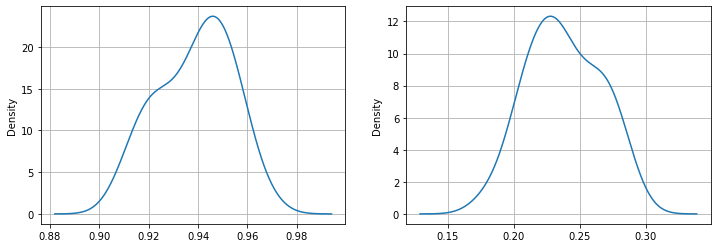

In [56]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

stats_df.iloc[:, 1].plot.kde(ax=axs[0])
stats_df.iloc[:, 2].plot.kde(ax=axs[1])

axs[0].grid()
axs[1].grid()

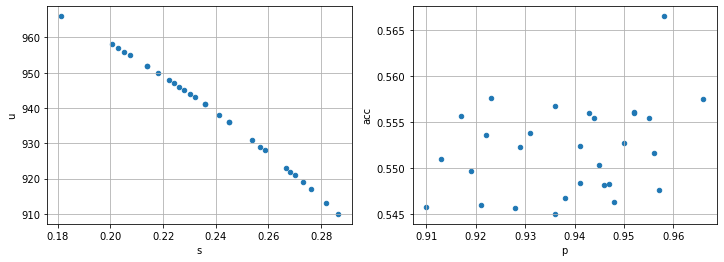

In [57]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

stats_df.plot.scatter(x='s', y='u', ax=axs[0])
stats_df.plot.scatter('p', 'acc', ax=axs[1])

axs[0].grid()
axs[1].grid()

plt.show()

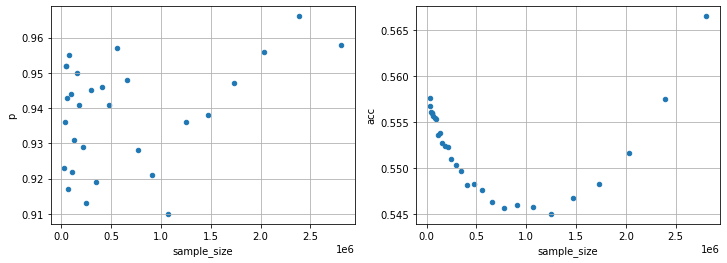

In [58]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

stats_df.plot.scatter(x='sample_size', y='p', ax=axs[0])
stats_df.plot.scatter('sample_size', 'acc', ax=axs[1])

axs[0].grid()
axs[1].grid()

plt.show()

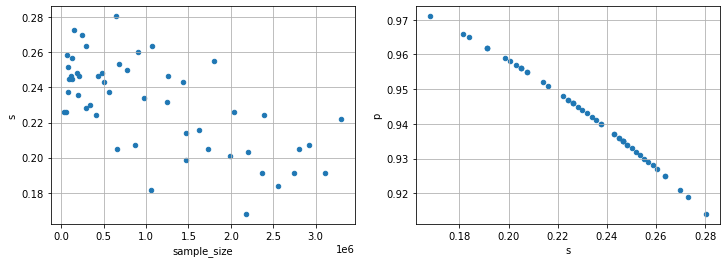

In [153]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

stats_df.plot.scatter(x='sample_size', y='s', ax=axs[0])
stats_df.plot.scatter('s', 'p', ax=axs[1])

axs[0].grid()
axs[1].grid()

plt.show()

Text(0, 0.5, 'Victories')

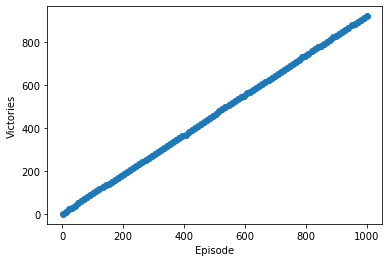

In [70]:
plt.scatter([i for i in np.linspace(memory1_df['ep'].min(),
                                    memory1_df['ep'].max(), 100)],
            [memory1_df[memory1_df['ep']<i].groupby('ep').sum()['reward'].sum() for i in np.linspace(memory1_df['ep'].min(),
                                                                                                     memory1_df['ep'].max(),
                                                                                                     100)])
plt.xlabel('Episode')
plt.ylabel('Victories')

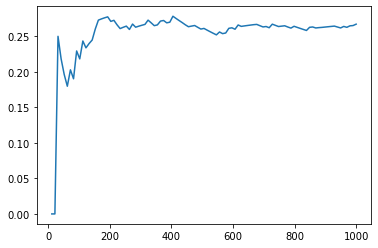

In [63]:
plt.plot([i for i in np.linspace(memory1_df['ep'].min(), memory1_df['ep'].max(), 100)], [memory1_df[memory1_df['ep']<j].groupby('ep').sum()['reward'].std() for j in np.linspace(memory1_df['ep'].min(), memory1_df['ep'].max(), 100)])

In [61]:
stats_df.describe()

sample_size          p          s       n           u        acc
count  2.900000e+01  29.000000  29.000000    29.0   29.000000  29.000000
mean   6.441927e+05   0.938759   0.237922  1000.0  938.758621   0.551988
std    7.693642e+05   0.014963   0.027405     0.0   14.963420   0.004953
min    3.071900e+04   0.910000   0.181320  1000.0  910.000000   0.544977
25%    9.499000e+04   0.928000   0.218054  1000.0  928.000000   0.548115
50%    2.937280e+05   0.941000   0.235743  1000.0  941.000000   0.552238
75%    9.082610e+05   0.950000   0.258617  1000.0  950.000000   0.555629
max    2.808510e+06   0.966000   0.286325  1000.0  966.000000   0.566520

In [46]:
u = memory1_df.groupby('ep').sum().mean()[0] * len(memory1_df.groupby('ep').sum())
p = memory1_df.groupby('ep').sum().mean()[0]
n = len(memory1_df.groupby('ep').sum())
#var = p*n*(1-p)

print('p =', p)
print('n =', n)
print('u =', u)

p = 0.965
n = 200
u = 193.0


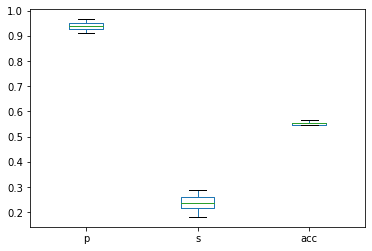

In [81]:
stats_df.iloc[:, [1,2,5]].plot.box()

# Evaluating Impact of Train Size in model

In [5]:
size_dict = {}

In [59]:
size_scrs = []
yi = memory_df['reward']  + (memory_df['ttl_reward'] * memory_df['decay_reward']) - memory_df['reward2'] - (memory_df['ttl_reward2'] * memory_df['decay_reward2'])
xi = memory_df[['round', 'obs', 'action', 'action2']]
name = '+-(a+b*c)'

In [37]:

yi = memory_df['ttl_reward']
xi = memory_df[['round', 'obs', 'action', 'action2']]
name = 'ttl_reward'


In [4]:
name = 'decay_reward'
yi = memory_df[name]
xi = memory_df[['round', 'obs', 'action', 'action2']]


In [51]:
y = yi.sample(sample_size)
x = xi.loc[y.index].copy()
y = pd.Series(le().fit_transform(y))    

msk_new = np.random.rand(len(y))<0.8
msk = msk_new
x_train, x_test, y_train, y_test = x[msk], x[~msk], y[msk], y[~msk]


In [ ]:
[x_test[y_test==y_uni] for y_uni in y_test.unique()]

In [69]:
(y_test==0).values

array([False, False, False, ..., False, False, False])

In [60]:
size_dict = {}

In [144]:
n_intervals = int(input('How many train sets?'))
size_scrs = []
cnt=0

for proportion in np.linspace(0.01, 1, n_intervals+1):
    
    cnt+=1
    sample_size = int(round( len(yi)*proportion, 0 ))
    
    y = yi.sample(sample_size)
    x = xi.loc[y.index].copy()
    y = pd.Series(le().fit_transform(y), index=y.index)    
    
    msk_new = np.random.rand(len(y))<0.8
    msk = msk_new
    x_train, x_test, y_train, y_test = x[msk], x[~msk], y[msk], y[~msk]

    #et = etr(n_estimators=50)
    #rf = rfr(n_estimators=50)
    #bg = BaggingRegressor(n_estimators=50)
    
    clear_output(wait=True)
    print('Fitting to '+str(round(proportion, 2))+' of the data ('+str(sample_size)+' rows)...  ('+str(cnt)+'/'+str(n_intervals+1)+')')
    
    et = etc(verbose=0, n_estimators=1)
    et.fit(x_train,y_train)

    clear_output(wait=True)
#    print('Predicting and Scoring ('+str(cnt)+'/'+str(n_intervals+1)+')')
    size_scr = acc_scr(y_test, et.predict(x_test))
    
    class_scrs = [acc_scr(y_test[y_test==y_uni], et.predict(x_test[(y_test==y_uni)])) for y_uni in sorted(y_test.unique())]
    
    
    size_scrs.append([proportion, sample_size, size_scr]+class_scrs)

size_df = pd.DataFrame(size_scrs, columns=['p', 'sample_size', 'acc']+['acc - class '+str(y_uni) for y_uni in sorted(y_test.unique())])
size_dict[name] = size_df
print('Done!')

Done!


In [12]:
def sample_size_score(xi, yi, name, keep=False, size_scrs=False, size_dict=False):

    n_intervals = int(input('How many train sets?'))
    if not keep: size_scrs = []
    cnt=0

    for proportion in np.linspace(0.01, 1, n_intervals+1):

        cnt+=1
        sample_size = int(round( len(yi)*proportion, 0 ))

        y = yi.sample(sample_size)
        x = xi.loc[y.index].copy()
        y = pd.Series(le().fit_transform(y), index=y.index)    

        msk_new = np.random.rand(len(y))<0.8
        msk = msk_new
        x_train, x_test, y_train, y_test = x[msk], x[~msk], y[msk], y[~msk]

        #et = etr(n_estimators=50)
        #rf = rfr(n_estimators=50)
        #bg = BaggingRegressor(n_estimators=50)

        clear_output(wait=True)
        print('Fitting to '+str(round(proportion, 2))+' of the data ('+str(sample_size)+' rows)...  ('+str(cnt)+'/'+str(n_intervals+1)+')')

        et = etc(verbose=0, n_estimators=1)
        et.fit(x_train,y_train)

        clear_output(wait=True)
    #    print('Predicting and Scoring ('+str(cnt)+'/'+str(n_intervals+1)+')')
        size_scr = acc_scr(y_test, et.predict(x_test))

        class_scrs = [acc_scr(y_test[y_test==y_uni], et.predict(x_test[(y_test==y_uni)])) for y_uni in sorted(y_test.unique())]


        size_scrs.append([proportion, sample_size, size_scr]+class_scrs)

    size_df = pd.DataFrame(size_scrs, columns=['p', 'sample_size', 'acc']+['acc - class '+str(y_uni) for y_uni in sorted(y_test.unique())])
    if keep: size_dict[name] = size_df
    print('Done!')
    
    if keep: return size_scrs, size_dict, size_df
    else: return size_df

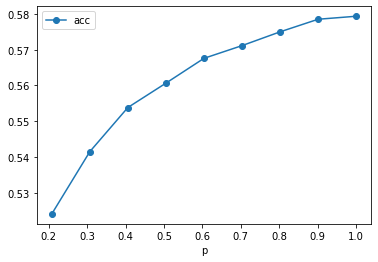

In [145]:
size_df.iloc[2:].plot(x='p', y='acc', marker='o')

In [76]:
class_cols = size_df.columns[3:]

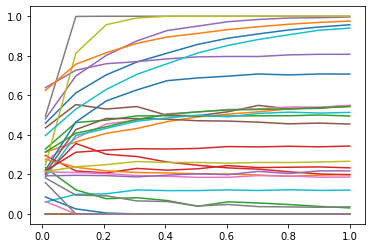

In [170]:
plt.plot(size_df['p'], size_df[class_cols])
plt.show()

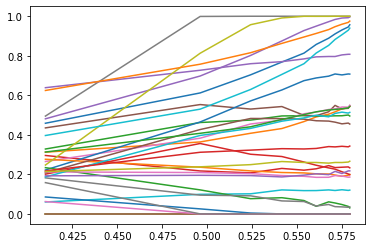

In [171]:
plt.plot(size_df['acc'], size_df[class_cols])
plt.show()

In [194]:
index = [i[-2:] for i in size_df.columns[size_df.mean()>0.77]][1:]

In [198]:
[sorted(yi.unique())[int(i)] for i in index]

[0.0, 1.4285714285714286, -0.5, -2.666666666666667, 0.8888888888888888, 0.4]

In [ ]:
size_df[yi.isin()]

# Scoring First Player: Avg and Std winning rate when playing multiple times

In [9]:
#size_dict = dict()

In [5]:

yi = memory_df['reward']  + (memory_df['ttl_reward'] * memory_df['decay_reward']) - memory_df['reward2'] - (memory_df['ttl_reward2'] * memory_df['decay_reward2'])
xi = memory_df[['round', 'obs', 'action', 'action2']]

name = '+-(a + b*c)'

In [35]:

n_intervals = int(input('How many train sets?'))
num_eps = int(input('Number of mathes per iteration: ')) + 1
mode = 'Not plotting'
if input('Type "exit" to leave')=='exit': pd.raiseerror

size_scrs = []
cnt=0

for proportion in np.linspace(0.01, 1, n_intervals+1):

#------------ Sampling and Model Training ---------------------

    cnt+=1
    sample_size = int(round( len(yi)*proportion, 0 ))
    
    y = yi.sample(sample_size)
    x = xi.loc[y.index].copy()
    y = pd.Series(le().fit_transform(y))    
    
    msk_new = np.random.rand(len(y))<0.8
    msk = msk_new
    x_train, x_test, y_train, y_test = x[msk], x[~msk], y[msk], y[~msk]

    #et = etr(n_estimators=50)
    #rf = rfr(n_estimators=50)
    #bg = BaggingRegressor(n_estimators=50)
    
    clear_output(wait=True)
    print('Fitting to '+str(round(proportion, 2))+' of the data ('+str(sample_size)+' rows)...  ('+str(cnt)+'/'+str(n_intervals+1)+')')
    
    et = etc(verbose=0, n_estimators=1)
    et.fit(x_train,y_train)

    size_scr = acc_scr(y_test, et.predict(x_test))

#--------- Playing -------------------------------------------


    memory1 = []
    num_eps_old = 1
    scrs=[]

    num_eps = num_eps
    for ep in range(num_eps_old, num_eps):

        clear_output(wait=True)
        if ep in range(num_eps_old, num_eps, int(num_eps/40)+1): print('iteration: ', str(cnt)+'/'+str(n_intervals+1), ' -  games: ', str(ep)+'/'+str(num_eps))

        table = np.array([[0,0,0], [0,0,0], [0,0,0]])
        table_flat = table.ravel().tolist()

        ep_memory = []

        play_cnt = 0
        obs = []
        winner=0
        reward=0
        action_history = []
        action1, action2 = 0, -1

        done=False
        while not done:

        #-------- Action 1 ------------

            play_cnt+=1
            #obs = le_obj.transform(np.array([(int(''.join([str(j) for j in action_history[1:][:-1]])) if len(action_history)!=1 else 0)]))[0]   
            #obs = (int(''.join([str(j) for j in action_history[1:][:-1]])) if len(action_history)!=1 else 0)   
            obs = (int(''.join([str(j) for j in action_history])) if len(action_history)!=0 else 0)   
            pred_in = [[play_cnt, obs, i, action2] for i in range(9)]       

        #------

            action1 = np.argmax(et.predict(pred_in))

            choice_cnt=0
            while action1 in action_history+[9]:
                action1 = pd.Series(et.predict(pred_in)).sort_values(ascending=False).index[choice_cnt]
                choice_cnt+=1

            action_history.append(action1)       
            table_flat[action1]='o'

        #-------------------------------------------------------

            #action1 = int(np.random.sample()*10)
            #while action1 in action_history+[9]:
             #   action1 = int(np.random.sample()*10)

            #action_history.append(action1)
            #table_flat[action1]='o' 
            #play_cnt+=1


        #---------------- Checking victory -------------------------

            table = np.array(table_flat).reshape(3,3)

            for i in range(3):
                if (table[i].tolist()==['o', 'o', 'o']) or (table[:, i].tolist()==['o', 'o', 'o']) or (np.diag(table).tolist()==['o', 'o', 'o']) or (np.diag(table.T).tolist()==['o', 'o', 'o']):
                    winner='o'
                    done=True 
                    reward=1


            #print(table)
            #print('winner', winner)
            #print('done', done)
            #print('reward', reward)
            #if input()=='exit': break
            #clear_output(wait=True)


    #        ep_memory.append([ep, play_cnt, obs, action1, reward])
            ep_memory.append([ep, reward])

            if 0 not in table_flat or reward==1: break

        #------------------------------ Action 2 - Random ---------------------------------------


            #print(table)
            #action2 = int(input())
            #if action2=='exit': break

            action2 = int(np.random.sample()*10)
            while action2 in action_history+[9]:
                action2 = int(np.random.sample()*10)

            action_history.append(action2)
            table_flat[action2]='x' 
            play_cnt+=1

        #------------------------------- Action 2 - Model --------------------------------------------

            #play_cnt+=1
            #obs = le_obj.transform(np.array([(int(''.join([str(j) for j in action_history[1:][:-1]])) if len(action_history)!=1 else 0)]))[0]   
            #obs = (int(''.join([str(j) for j in action_history])) if len(action_history)!=0 else 0)   
            #pred_in = [[play_cnt, obs, i] for i in range(9)]       

            #action2 = np.argmax(et.predict(pred_in))

            #choice_cnt=0
            #while action2 in action_history:
             #   action2 = pd.Series(et.predict(pred_in)).sort_values(ascending=False).index[choice_cnt]
              #  choice_cnt+=1
            #if action1 != np.argmax(et.predict(pred_in)): random_cnt+=1

            #action_history.append(action2)       
            #table_flat[action2]='x'

        #---------------------------------------------------------------- Checking victory condition --------------

            table = np.array(table_flat).reshape(3,3)

            for i in range(3):
                if (table[i].tolist()==['x', 'x', 'x']) or (table[:, i].tolist()==['x', 'x', 'x']) or (np.diag(table).tolist()==['x','x','x']) or (np.diag(table.T).tolist()==['x', 'x', 'x']):
                    winner='x'
                    done=True

            if 0 not in table_flat: break

    #------------ Total and Decay Rewards ------------

        #for i, row in enumerate(ep_memory):

         #   ep_memory[i].append(reward)
          #  ep_memory[i].append(reward*i/len(ep_memory))

        memory1.extend(ep_memory)

    #----- Plotting ----------

        if mode=='plot':

            scrs.append([ep, pd.DataFrame(memory1, columns=['ep', 'reward']).groupby('ep').sum()['reward'].mean()])
            pd.DataFrame(scrs, columns=['ep', 'acc']).set_index('ep').plot()
            plt.grid()
            plt.show()
            plt.pause(0.001)

    #---------- Dataframe Conversion ---------------

    
    num_eps_old = ep+1

    #memory1_df = pd.DataFrame(memory1, columns=['ep', 'round', 'obs', 'action', 'reward', 'ttl_reward', 'decay_reward'])     
    memory1_df = pd.DataFrame(memory1, columns=['ep', 'reward'])     
    
    u = memory1_df.groupby('ep').sum().mean()[0] * len(memory1_df.groupby('ep').sum())
    p = memory1_df.groupby('ep').sum().mean()[0]
    n = len(memory1_df.groupby('ep').sum())
    s = memory1_df.groupby('ep').sum().std()[0]
    
    size_scrs.append([proportion, sample_size, size_scr, p, s, n, u])

#------------------------------------------------------------------------------------------------------------------------------------

size_df = pd.DataFrame(size_scrs, columns=['proportion', 'sample_size', 'acc', 'p', 's', 'n', 'u'])
size_dict[name] = size_df

print('Done!')



Done!


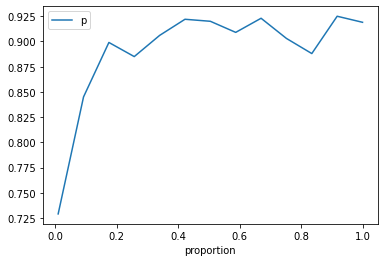

In [36]:
size_df.plot('proportion', 'p')

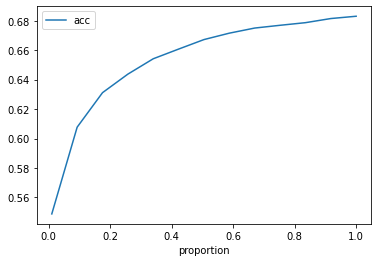

In [37]:
size_df.plot('proportion', 'acc')

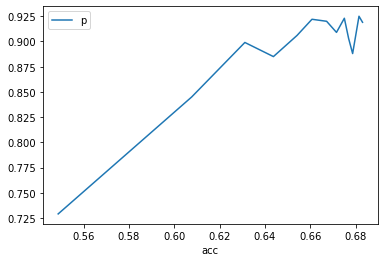

In [38]:
size_df.plot('acc', 'p')

NameError: name 'size_df' is not defined

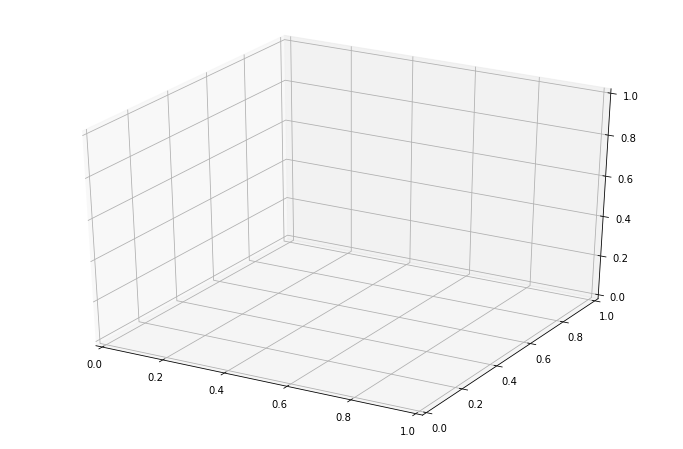

In [896]:


for angle in range(1,360,10):
    fig = plt.figure(figsize=(12,8))
    ax0 = fig.add_subplot(1,1,1,projection='3d')

    ax0.plot(size_df['acc'], size_df['proportion'], size_df['p'])

    ax0.view_init(30, angle)
    plt.show()
    plt.pause(0.01)
    clear_output(wait=True)

In [16]:
size_df

proportion  sample_size       acc      p         s     n      u
0       0.010        89104  0.542531  0.748  0.434379  1000  748.0
1       0.208      1853372  0.636033  0.888  0.315524  1000  888.0
2       0.406      3617640  0.659979  0.900  0.300150  1000  900.0
3       0.604      5381908  0.671717  0.899  0.301480  1000  899.0
4       0.802      7146175  0.678925  0.922  0.268306  1000  922.0
5       1.000      8910443  0.682332  0.904  0.294739  1000  904.0

# Comparing Reward Systems

In [53]:
a = memory_df['reward']
b = memory_df['ttl_reward']
c =  memory_df['decay_reward']
d = memory_df['reward2']
e = memory_df['ttl_reward2']
f =  memory_df['decay_reward2']

In [ ]:
range?

In [ ]:
x = memory_df[['round', 'obs', 'action', 'action2']]
x = memory_df[['round', 'obs', 'action', 'action2', 'fatal_move', 'fatal_move2', 'player']]

In [54]:
y = a  + (b * c) - d - (e * f)
    
y = pd.Series(le().fit_transform(y))

In [58]:
    #  win_rate = 0.9724

    y = a  + c/2
    x = memory_df[['round', 'obs', 'action', 'action2']]
    y = pd.Series(le().fit_transform(y))
    
    name='reward+decay'

In [59]:
    msk_new = np.random.rand(len(y))<0.8
    msk = msk_new
    x_train, x_test, y_train, y_test = x[msk], x[~msk], y[msk], y[~msk]

    #et = etr(n_estimators=50)
    #rf = rfr(n_estimators=50)
    #bg = BaggingRegressor(n_estimators=50)

    et = etc(verbose=1, n_jobs=-1, n_estimators=1)

    #et.set_params(n_estimators=10)
    et.fit(x_train,y_train)

    #cm(y_test, et.predict(x_test)), print(cr(y_test, et.predict(x_test)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.3s finished


ExtraTreesClassifier(n_estimators=1, n_jobs=-1, verbose=1)

In [62]:
stats_df, stats_dict = play_model(et, stats_dict, name, times=10)

iteration:  9/10  -  games:  989/1001
